# Notebook Objective and Setup

BGG08 contains the Collaborative Filtering model.

Th CF is tested in both memory and model-based modes, on both the user's real ratings data and the synthesized data sets.

Using testing results, we select the most efficient recommendation system and make our business recommendations.

## Business Objective

Build a content recommender for BoardGameGeek with a goal of addressing challenges that are both common to recommenders in general, and specific to BGG:

- Cost of acquiring and maintaining data
- Cold Start problems where new users and items are not a part of the system
- Catalog coverage problems where popularity bias results in items of the catalog that are not in the recommendation system
- Sparse matrix issue where a combination of many items, many users, and few ratings results in low user/item crossover for identifying neighbors
- BGG specific problem where reimplementatons/reskins of games result in separated user profiles when they should be similar
- Computational cost/time limitations when issuing recommendations

## Package Imports

In [1]:
import pandas as pd
import numpy as np
import requests
import regex as re
import time
import os
import gc
import json
import copy
from statistics import mean
from statistics import median

# ignore warnings (gets rid of Pandas copy warnings)
import warnings

warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 30)


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from scipy import spatial

# scoring and algorithm selection packages
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

"""from surprise import KNNWithMeans, SVD, Dataset, Reader, dump, accuracy, NMF, BaselineOnly
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import KFold
from surprise.prediction_algorithms.matrix_factorization import SVD, SVDpp, NMF
from surprise.prediction_algorithms.slope_one import SlopeOne
from surprise.prediction_algorithms.co_clustering import CoClustering
from surprise.prediction_algorithms.random_pred import NormalPredictor
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise.model_selection.search import GridSearchCV"""

'from surprise import KNNWithMeans, SVD, Dataset, Reader, dump, accuracy, NMF, BaselineOnly\nfrom surprise.model_selection.validation import cross_validate\nfrom surprise.model_selection import KFold\nfrom surprise.prediction_algorithms.matrix_factorization import SVD, SVDpp, NMF\nfrom surprise.prediction_algorithms.slope_one import SlopeOne\nfrom surprise.prediction_algorithms.co_clustering import CoClustering\nfrom surprise.prediction_algorithms.random_pred import NormalPredictor\nfrom surprise.prediction_algorithms.baseline_only import BaselineOnly\nfrom surprise.model_selection.search import GridSearchCV'

## Notebook Functions

In [2]:
def get_user_similarity(this_dictionary, user_a, all_users_ratings, user_items, v):
    """
    Takes in a user and dictionary of other users and their game ratings.
    Finds users_b who have an intersection of at least v rated items (both have rated the same v items).
    Calculates the cosine distance between user_a and each qualifying user_b.
    Stores similarity to users_b in similarity_dictionary and returns similarity_dictionary.

    Inputs:
    this_dictionary: existing similarities dictionary in case a similarity already exists between users
    user_a: The user that we are finding neighbors for
    all_users_ratings: all users in the system
    user_items: the items that user_a has rated
    v: number of items the users must have in common to have their distance scored and recorded

    Outputs:
    similarity_dictionary: dictionary with similarity between user_a and each other users with a set match

    """

    # start a list for the user distances
    similarity_dictionary = {}

    # for each user b in the dictionary:
    for user_b in all_users_ratings:

        if user_b == user_a:
            continue

        # toggle this OFF if NOT grid searching
        if user_b in this_dictionary[user_a]:
            # append the distance to the
            similarity_dictionary[user_b] = this_dictionary[user_b][user_a]
            pass
        ## END OF STUFF TO TOGGLE

        else:

            # get a list of the user b reviewed items
            other_user_items = list(all_users_ratings[user_b].keys())

            # determine the intersection of the items for user a and user b
            intersection_set = set.intersection(set(user_items), set(other_user_items))

            if len(intersection_set) > v:

                # toggle this ON if NOT grid searching
                # if user_b in this_dictionary[user_a]:
                # append the distance to the
                # similarity_dictionary[user_b] = this_dictionary[user_b][user_a]
                # pass

                # else:
                ## END OF STUFF TO TOGGLE

                # make list to store each user a and user b ratings
                user_a_ratings = []
                user_b_ratings = []

                # for each item in the intersection set of mutually reviewed items
                for item in intersection_set:

                    # append user a ratings for the items
                    user_a_ratings.append(all_users_ratings[user_a][item])
                    # append user b ratings for the items
                    user_b_ratings.append(all_users_ratings[user_b][item])

                # calculate spatial distance between the two users
                users_similarity = 1 - (
                    spatial.distance.cosine(user_a_ratings, user_b_ratings)
                )

                # append the distance to the
                this_dictionary[user_a][user_b] = users_similarity
                this_dictionary[user_b][user_a] = users_similarity

                # append the distance to the
                similarity_dictionary[user_b] = users_similarity

            else:
                continue

    return similarity_dictionary

In [3]:
def get_estimated_ratings(user_ratings_dictionary, my_neighbors, user_mean, n):
    """
    Takes in a distance dictionary and the user_a mean.
    Finds the k closest users

    Inputs:
    all_users_ratings: dictionary of all ratings to be used, can be real or synthetic
    similarity_dictionary: dictionary of distances between user_a and each qualifying user_b
    user_mean: the rating mean of user_a
    k: number of neighbors to consider for making ratings predictions
    n: number of minimum neighbors that rated a potential item for it to be recommended
    synth=True: if using synthetic ratings or actual values

    Outputs:
    user_predicted_ratings: Estimated item ratings for user_a
    """

    user_predicted_ratings = {}

    start = time.time()

    weighted_ratings = {}

    temp_dataframe = pd.DataFrame()

    # for each user in my neighbors:
    for neighbor in my_neighbors:
        neighbor_name = userid_lookup_table[neighbor]

        weighted_ratings[neighbor] = {}

        # for each item they rated:
        for item in user_ratings_dictionary[neighbor_name]:
            # weight their rating by similarity
            weighted_ratings[neighbor][item] = round(
                (user_ratings_dictionary[neighbor_name][item] * my_neighbors[neighbor]),
                1,
            )

    temp_work = pd.DataFrame(weighted_ratings).T
    over_n = temp_work.dropna(thresh=n, axis=1)
    df2 = (
        round((over_n.loc[:, round(over_n.mean(axis=0), 1) > 0].mean()), 1).sort_values(
            ascending=False
        )
        + user_mean
    )

    user_predicted_ratings = df2.to_dict()

    # print a report about the user
    total_ratings_created = len(user_predicted_ratings)
    print("Predicted " + str(total_ratings_created) + " ratings")

    return user_predicted_ratings

In [4]:
def score_ratings(user_real_dict, user_predicted_ratings, user_mean):
    """
    Takes in actual ratings and predictions
    Gets the intersection of items that user actually rated, and prediction for that item
    Gets MAE and RMSE of actuals vs predictions
    Get recall (% of user's relevant items predicted as recommended)

    Inputs:
    user_real_dict: single user's actual ratings, use REAL ratings dictionary only
    predicted_dictionary: dictionary of single user's predicted ratings
    user_mean: user's mean rating

    Outputs:
    user_mae, user_rmse: user's MAE and RMSE
    recall: % of user's actual relevant items that were predicted and correctly recommended

    """
    # Make a list of all predicted item ids for user
    predicted_items = list(user_predicted_ratings.keys())
    # print(predicted_items)

    # make a list of all actual rated item ids for user
    actual_rated_items = list(user_real_dict.keys())

    # the intersection of items both rated and predicted
    real_rated_and_predicted = list(
        set.intersection(set(actual_rated_items), set(predicted_items))
    )

    # make a dictionary for new recommendations
    all_recommendations = {}

    # make list for recommended items
    recommended_items = []

    # for each item in the recommentation list,
    for item in predicted_items:

        # if the item is rated higher than the user_mean (user mean)
        if user_predicted_ratings[item] > user_mean:

            # append to the recommendations dictionary
            all_recommendations[item] = user_predicted_ratings[item]

            # append to the recommendations list
            recommended_items.append(item)

    # recommended = # of recommended items
    recommended = len(recommended_items)

    # relevant items are user rated items that have a true value over the user's mean
    # start at 0 and will add
    relevant = 0

    # recommended items that are relevant are items where the recommendation and the real value are over the user's mean
    # start at 0 and will add
    rec_and_rel = 0

    # for each item that was both actually rated and predicted:
    for item in real_rated_and_predicted:
        # get the real item rating
        item_rating = user_real_dict[item] + user_mean
        # if the item was rated over the user's mean:
        if item_rating > user_mean:
            # add 1 to relevant items
            relevant += 1
        # if the item is in the recommended list:
        if item in recommended_items:
            # if the prediction is over the user mean:
            if user_predicted_ratings[item] > user_mean:
                # add one to rec and rel items
                rec_and_rel += 1

    # if there were no recommendations or relevant items, recall is 0
    if recommended == 0:
        recall = 0
    elif relevant == 0:
        recall = 0
    # otherwise, calculate recall
    else:
        recall = round((rec_and_rel / relevant) * 100, 2)

    # MAE and RMSE:

    # make lists for actuals and predictions
    y_actual = []
    y_preds = []

    # for items in the real and predicted intersection,
    for item in real_rated_and_predicted:
        # append the scores to real and predicted lists
        y_actual.append(user_real_dict[item])
        y_preds.append(user_predicted_ratings[item])

    # if there were no predictions, skip this
    if len(y_preds) == 0:
        print(
            "No ratings for actual predicted items. Cannot calculate MAE for this user."
        )
        user_mae, user_rmse = None, None

    # otherwise, calculate mae and rmse
    else:
        user_mae = mean_absolute_error(y_preds, y_actual)
        user_rmse = np.sqrt(mean_squared_error(y_preds, y_actual))

    return user_mae, user_rmse, recall, actual_rated_items, recommended_items

In [5]:
def get_user_predictions(resources_pack, user_set, n, synth):
    """
    Gets predictions for a set of users

    For each user, makes a list of the user's reviewed items
    Calls on get_user_similarity() to find other users with v items in common
    Calls on get_estimated_ratings() to get predictions based on k neighbors
    Gets MAE and RMSE on predictions for items user actually rated
    Stores all predictions to dictionary

    Inputs:
    resources_pack: collection of three dictionaries:
        all_users_ratings: dictionary of all ratings to be used, can be real or synthetic
        real_user_ratings: dictionary of actual ratings, use REAL ratings dictionary only
        this_dictionary: ongoing similarities dictionary which is populated as users iterate
    user_set: list of users to get predictions for
    parameters: collection of three parameters:
        v: number of required items in the intersection of two user rating sets to consider a neighbor
        k: number of neighbors to consider for neighborhood
        n: number of neighbors in neighborhood that must have rated an item for a rating to be produced

    Outputs:
    global_mae, global_rmse: MAE and RMSE for the user set
    global_recall: recall for these users
    predicted_ratings: dictionary of user predictions
    all_recommended_items: set of items that were recommended
    """

    # start the timer
    global_start = time.time()

    # unpack the resources pack
    all_users_ratings = resources_pack[0]
    real_users_ratings = resources_pack[1]

    # set up the predicted ratings for these users
    predicted_ratings = {}

    # set up the scoring lists for these users
    global_mae_list = []
    global_rmse_list = []
    global_recall_list = []
    number_recommended = []

    # set storage for recommended items
    all_recommended_items = []

    # for the user we are calculating
    for user_a in user_set:

        # report on user
        print("Calculating " + user_a)

        # get the user's mean rating
        user_mean = user_means[user_a]

        my_neighbors = similarity_storage_real[user_a]

        # call get_estimated_ratings to get predictions for user_a
        user_predicted_ratings = get_estimated_ratings(
            all_users_ratings, my_neighbors, user_mean, n
        )

        # if there were no user predicted ratings:
        if len(user_predicted_ratings) == 0:
            print("There were NO COMPS for this user")
            global_mae_list.append(0)
            global_rmse_list.append(0)
            global_recall_list.append(0)
            number_recommended.append(0)
            continue

        else:
            # store the predicted ratings for the user_a
            predicted_ratings[user_a] = user_predicted_ratings

            # get user scores
            user_mae, user_rmse, user_recall, actual_rated_items, recommended_items = (
                score_ratings(
                    real_users_ratings[user_a], user_predicted_ratings, user_mean
                )
            )

            recommended_length = len(recommended_items)

            # check if there were valid user scores; if none, skip the scoring additojn
            if user_mae == None:
                continue
            # otherwise append the scores to the score lists
            else:
                global_mae_list.append(user_mae)
                global_rmse_list.append(user_rmse)
                global_recall_list.append(user_recall)
                number_recommended.append(recommended_length)

        # add the recommended items to the all_recommended_items set
        all_recommended_items += recommended_items
        all_recommended_items = list(set(all_recommended_items))

    global_mae = mean(global_mae_list)
    global_rmse = mean(global_rmse_list)
    global_recall = mean(global_recall_list)
    global_recommended_mean = mean(number_recommended)
    global_recommended_median = median(number_recommended)

    global_scores = [
        global_mae,
        global_rmse,
        global_recall,
        global_recommended_mean,
        global_recommended_median,
    ]

    end_time = time.time() - global_start

    print("MAE for set of users: " + str(global_mae))
    print("RMSE for set of users: " + str(global_rmse))
    print("Recall for set of users: " + str(global_recall))
    print(
        "Average/Median Number Recommended Items: "
        + str(global_recommended_mean)
        + ", "
        + str(global_recommended_median)
    )
    print("Time elapsed: " + str(end_time))

    return global_scores, predicted_ratings, all_recommended_items

In [6]:
# We will use IQR to remove our outliers with the following function


def iqr_outliers(column, iqr_rate):
    """return the lower range and upper range for a column based on IQR*rate
    Inputs:
    column: the column to find iqr
    iqr_rate: iqr rate to determine lower and upper bounds

    Outputs:
    lower_range, upper_range: lower and upper bounds for column"""
    Q1, Q3 = np.percentile(column, [25, 75])  # get the lower and upper quartiles
    iqr = Q3 - Q1  # find the interquartile range
    lower_range = Q1 - (iqr_rate * iqr)  # find the lower range based on iqr rate
    upper_range = Q3 + (iqr_rate * iqr)  # find the upper range based on iqr rate
    return lower_range, upper_range

## Load Data

##### Split Train/Val/Test User Lists

In [7]:
# Opening JSON file
with open("real_ratings/real_user_ratings_scaled.json") as json_file:
    real_user_ratings_dictionary_scaled = json.load(json_file)

In [8]:
# get list of users
users_list = list(real_user_ratings_dictionary_scaled.keys())

In [9]:
val_users = users_list[:1000]

In [10]:
# make train/val/test split
# train_users, remainder = train_test_split(users_list, test_size=.025, random_state=42)
# val_users, test_users = train_test_split(remainder, test_size=.5, random_state=42)

# len(train_users), len(val_users), len(test_users)

In [11]:
# Opening JSON file
# with open('real_ratings/real_user_ratings_dictionary_unscaled.json') as json_file:
#    real_user_ratings_dictionary_unscaled = json.load(json_file)

##### Game BGGId: Name Lookup Table

In [12]:
# dictionary of game IDs-Names

# Load games
games = pd.read_pickle("data_cleaned/games.pkl")

# lists of game ids and game names
game_ids = list(games["BGGId"])
game_names = list(games["Name"])

# make lookup dictionary
game_id_lookup = {}

# store ids and names in lookup dictionary
for key, item in zip(game_ids, game_names):
    game_id_lookup[key] = item


del games
gc.collect()

game_id_lookup

{1: 'Die Macher',
 2: 'Dragonmaster',
 3: 'Samurai',
 4: 'Tal der Könige',
 5: 'Acquire',
 6: 'Mare Mediterraneum',
 7: 'Cathedral',
 8: 'Lords of Creation',
 9: 'El Caballero',
 10: 'Elfenland',
 11: 'Bohnanza',
 12: 'Ra',
 13: 'Catan',
 14: 'Basari',
 15: 'Cosmic Encounter',
 16: 'MarraCash',
 17: 'Button Men',
 18: 'RoboRally',
 19: 'Wacky Wacky West',
 20: 'Full Metal Planète',
 21: 'Gateway to the Stars',
 22: 'Magic Realm',
 23: 'Divine Right',
 24: 'Twilight Imperium',
 25: 'Battlemist',
 26: 'Age of Renaissance',
 27: 'Supremacy: The Game of the Superpowers',
 28: 'Illuminati',
 29: 'Terrain Vague',
 30: 'Dark Tower',
 31: 'Dark World',
 32: 'Buffalo Chess',
 34: 'Arkham Horror',
 36: 'Federation & Empire',
 37: 'Dragon Masters',
 38: 'Runes',
 39: 'Darkover',
 40: 'Borderlands',
 41: "Can't Stop",
 42: 'Tigris & Euphrates',
 43: 'Airlines',
 44: 'David & Goliath',
 45: 'Perudo',
 46: 'Medici',
 47: 'Chinatown',
 48: 'Krieg und Frieden',
 49: 'Mamma Mia!',
 50: 'Lost Cities',
 

##### Item ID: Mean Lookup Table

In [13]:
with open("data_cleaned/item_means.json") as json_file:
    item_mean_lookup = json.load(json_file)

len(item_mean_lookup)

21925

In [14]:
# Opening JSON file
"""with open('data_cleaned/user_means.json') as json_file:
    user_mean_lookup = json.load(json_file)

len(user_mean_lookup)"""

"with open('data_cleaned/user_means.json') as json_file:\n    user_mean_lookup = json.load(json_file)\n\nlen(user_mean_lookup)"

# Tests with Real Data

## Visualizations

Create a visualization showing the number of users vs number of games rated, with a line at the median. We want to show the relatively few ratings and the long tail on the ratings distribution.

In [15]:
# total users in system
len(real_user_ratings_dictionary_scaled)

272136

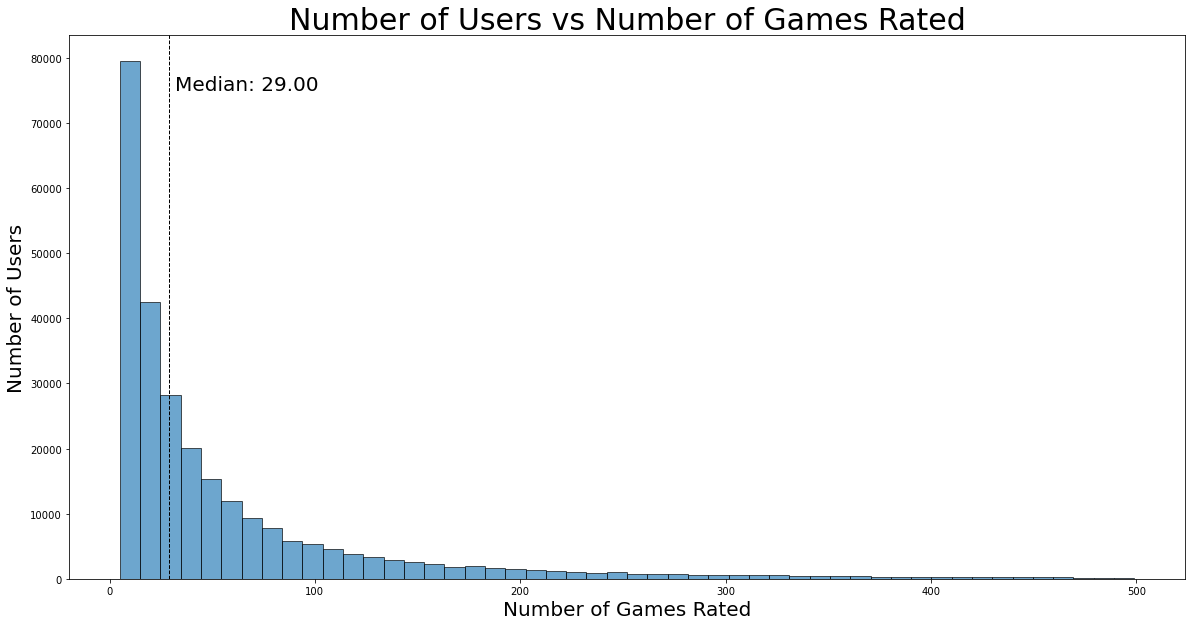

''

In [16]:
num_ratings = {}

for user in real_user_ratings_dictionary_scaled:
    num_ratings[user] = len(real_user_ratings_dictionary_scaled[user])

num_ratings_df = pd.DataFrame(
    num_ratings.values(), index=(num_ratings.keys())
).reset_index()

fix, ax = plt.subplots(figsize=(20, 10))

x = num_ratings_df.loc[num_ratings_df[0] < 500][0]
med = num_ratings_df[0].median()

result = plt.hist(x, bins=50, edgecolor="k", alpha=0.65)
plt.axvline(med, color="k", linestyle="dashed", linewidth=1)

plt.title("Number of Users vs Number of Games Rated", fontsize=30)
plt.xlabel("Number of Games Rated", fontsize=20)
plt.ylabel("Number of Users", fontsize=20)

min_ylim, max_ylim = plt.ylim()
plt.text(med * 1.1, max_ylim * 0.9, "Median: {:.2f}".format(med), fontsize=20)

# plt.savefig('images/usersvsrated.png')
plt.show();

In [17]:
# how many users under the median?

num_under_median = num_ratings_df.loc[num_ratings_df[0] <= 43][0].count()
num_under_median_perc = round((num_under_median / num_ratings_df.shape[0] * 100), 2)
print(
    str(num_under_median)
    + " users with 29 or fewer ratings (median), comprising "
    + str(num_under_median_perc)
    + "% of users."
)

168612 users with 29 or fewer ratings (median), comprising 61.96% of users.


In [18]:
# how many users under 10 ratings?

num_under_10 = num_ratings_df.loc[num_ratings_df[0] <= 10][0].count()
num_under_10_perc = round(num_under_10 / num_ratings_df.shape[0] * 100, 2)
print(
    str(num_under_10)
    + " users with 10 or fewer ratings (median), comprising "
    + str(num_under_10_perc)
    + "% of users."
)

54980 users with 10 or fewer ratings (median), comprising 20.2% of users.


In [19]:
# make lists of users under and over the median from the dataframe
users_under_median = list(num_ratings_df.loc[num_ratings_df[0] <= 27]["index"])
users_over_median = list(num_ratings_df.loc[num_ratings_df[0] > 27]["index"])

# now make a new list of validation users that are under and over the median
val_under_median = [item for item in users_under_median if item in val_users]
val_over_median = [item for item in users_over_median if item in val_users]

## Memory Based

Use statistical techniques on the dataset to calculate the predictions.

In plain english, the memory model works by finding a subset of neighbors where we have v items in common. Then we calculate our cosine similarity with each member of the subset, using only our items in common. After picking the closest k neighbors, we make recommendations using items with at least n ratings within the subset.

We have several parameters to tune for the memory-based model for each of our data sets. They are:

* v: How many items do we need to have in common to be neighbors?
* k: How many closest neighbors do I want to consider for making new recommendations?
* n: How many of the k neighbors need to have rated an item in order for a rating to be produced for me?

Steps:

* For each user_a that we want to make recommendations for:

    * Find users_b who have rated v items in common
    * for each user_b:
    
        * Calculate intersection of ratings for user_a and user_b with v minimum items
        * calculate cosine similarity between user_a and user_b
    
    * Determine k closest neighbors_k based on cosine similarity
    * for each item_i in the games dictionary,
        
        * if neighbor_k rated item_i, get their rating (weighted by their similarity)
        * predicted rating for item_i is average of all neighbor's ratings
    
    * get accuracy metrics for user_a based on predictions vs actual for user_a rated items
    * sort predicted rating items and show x top recommendations

How do I evaluate my recommender? What we really want is a high RECALL in addition to a "reasonable" error. With that in mind it's more important to make sure that a user's actual items are correctly categorized as "recommended", defined as being over the user's mean. We're also interested in a good amount of catalog coverage, and still a reasonable error. To that end, our evaluation metric is a custom metric based on weighted scores of error, recall, and coverage.

In [20]:
# Opening JSON file
with open("data_cleaned/user_means.json") as json_file:
    user_means = json.load(json_file)

In [21]:
# Opening JSON file
# with open('data_cleaned/userid_lookup_table.json') as json_file:
#    userid_lookup_table = json.load(json_file)

In [22]:
with open("data_cleaned/game_id_lookup.json") as json_file:
    game_id_lookup = json.load(json_file)

In [23]:
# Opening JSON file
with open("data_cleaned/user_blocks_lookup.json") as json_file:
    user_blocks_lookup = json.load(json_file)

In [24]:
# Opening JSON file
with open("data_cleaned/item_similarities_real_full_75.json") as json_file:
    similarity_storage = json.load(json_file)

In [25]:
item = "174430"

In [26]:
my_neighbors = similarity_storage[item]
my_neighbors

{'24323': 0.8589004874229431,
 '37370': 0.7688533663749695,
 '12369': 0.8207623958587646,
 '10188': 0.8594716787338257,
 '21967': 0.7656087875366211,
 '171665': 0.7841165065765381,
 '32794': 0.8542642593383789,
 '272711': 0.7788279056549072,
 '34065': 0.8969394564628601,
 '155745': 0.8485232591629028,
 '66517': 0.8754836916923523,
 '148356': 0.8440971374511719,
 '8122': 0.7570739388465881,
 '18248': 0.7615071535110474,
 '20920': 0.7585046887397766,
 '14151': 0.764789342880249,
 '147919': 0.8118882179260254,
 '176523': 0.8878955245018005,
 '103039': 0.9414306282997131,
 '17073': 0.8081917762756348,
 '9345': 0.7850950360298157,
 '13412': 0.7670131325721741,
 '6219': 0.7808981537818909,
 '7185': 0.7574548721313477,
 '7186': 0.8135390281677246,
 '31715': 0.765607476234436,
 '49391': 0.8071927428245544,
 '284430': 0.7887157201766968,
 '297374': 0.7749769687652588,
 '207398': 0.7740635275840759,
 '272502': 0.9063159227371216,
 '312738': 0.7796225547790527,
 '11525': 0.791217565536499,
 '2114

In [27]:
my_name = game_id_lookup[item]
my_name

'Gloomhaven'

### Predict items for people:

In [29]:
user = "Threnody"

In [49]:
raw_user_recommendations = {}
best_similarity = {}

for item in real_user_ratings_dictionary_scaled[user]:

    print(real_user_ratings_dictionary_scaled[user][item])

    for like_item in similarity_storage[item]:

        like_item_name = game_id_lookup[like_item]
        similarity = round(similarity_storage[item][like_item], 2)

        est_rating = round(
            (
                real_user_ratings_dictionary_scaled[user][item] / 10 * similarity
                + item_mean_lookup[like_item]
            ),
            1,
        )

        if est_rating > 10:
            est_rating = 10

        print(
            est_rating,
            like_item,
            like_item_name,
            similarity,
            item,
            game_id_lookup[item],
        )

        if like_item in best_similarity:
            print("Key exists already")
            if best_similarity[like_item] > similarity:
                continue
            else:
                print("Replacing rating with better estimate")
                best_similarity[like_item] = similarity
                raw_user_recommendations[like_item_name] = est_rating
        else:
            best_similarity[like_item] = similarity
            raw_user_recommendations[like_item_name] = est_rating

-2
7.7 205896 Rising Sun 0.76 25190 Pink Godzilla Dev Kit
7.0 176396 Quadropolis 0.76 25190 Pink Godzilla Dev Kit
8.0 199792 Everdell 0.84 25190 Pink Godzilla Dev Kit
7.3 184921 Bunny Kingdom 0.78 25190 Pink Godzilla Dev Kit
6.7 244536 Tiny Epic Zombies 0.95 25190 Pink Godzilla Dev Kit
6.1 117942 Zooloretto: The Dice Game 0.84 25190 Pink Godzilla Dev Kit
6.6 144826 Zombie 15' 0.8 25190 Pink Godzilla Dev Kit
6.5 280789 Pandemic: Rapid Response 0.83 25190 Pink Godzilla Dev Kit
6.0 159406 Portal: The Uncooperative Cake Acquisition Game 0.91 25190 Pink Godzilla Dev Kit
7.3 286096 Tapestry 0.94 25190 Pink Godzilla Dev Kit
7.0 177639 Raptor 0.84 25190 Pink Godzilla Dev Kit
7.1 195162 Plague Inc.: The Board Game 0.8 25190 Pink Godzilla Dev Kit
6.5 692 Wizard Kings 0.92 25190 Pink Godzilla Dev Kit
6.4 132428 BioShock Infinite: The Siege of Columbia 0.91 25190 Pink Godzilla Dev Kit
5.6 216 Atlanteon 0.94 25190 Pink Godzilla Dev Kit
5.1 14535 SPANC: Space Pirate Amazon Ninja Catgirls 0.76 25190 

Replacing rating with better estimate
6.0 11179 Semper Victor 0.79 3076 Puerto Rico
6.1 27480 Command Decision: Test of Battle 0.89 3076 Puerto Rico
6.0 307715 High Noon 0.91 3076 Puerto Rico
6.5 236861 Full Moon Jacket 0.82 3076 Puerto Rico
4.3 252990 Gift Party 0.89 3076 Puerto Rico
3.7 8514 Forgotten Axis: The Romanian Campaign 0.81 3076 Puerto Rico
4.7 235293 Apocalypse Z: The Board Game 0.8 3076 Puerto Rico
5.4 292333 Cowboys II: Cowboys & Indians Edition 0.84 3076 Puerto Rico
4.6 73230 Showdown: The Coming Indo-Pakistani War 0.92 3076 Puerto Rico
Key exists already
Replacing rating with better estimate
5.1 306029 Dark Force Incursion 0.81 3076 Puerto Rico
6.7 281257 Aeolis 0.97 3076 Puerto Rico
6.7 260524 Beyond Humanity: Colonies 0.76 3076 Puerto Rico
7.6 165694 The Cones of Dunshire 0.76 3076 Puerto Rico
5.5 248154 Gunfighter 0.79 3076 Puerto Rico
6.2 269980 Catan: Big Box 0.82 3076 Puerto Rico
Key exists already
Replacing rating with better estimate
5.1 248722 Daring Contest 0

6.3 92465 Sporz Original Outbreak 0.78 14996 Ticket to Ride: Europe
7.7 42415 Dungeon Crawl 0.99 14996 Ticket to Ride: Europe
Key exists already
Replacing rating with better estimate
6.1 5743 Win Place Show 0.76 14996 Ticket to Ride: Europe
6.2 190553 Munchkin 1+2 0.79 14996 Ticket to Ride: Europe
7.5 149705 Croquet: A Cardboard Game 0.95 14996 Ticket to Ride: Europe
6.7 141920 Supremacy 2020 0.82 14996 Ticket to Ride: Europe
Key exists already
-11
3.3 145764 Zero Hour: Survival Horror Card Game 0.77 266192 Wingspan
Key exists already
5.6 149459 Assaultous 0.83 266192 Wingspan
5.1 21457 Cover Up 0.75 266192 Wingspan
6.6 35425 Mutants and Death Ray Guns 0.8 266192 Wingspan
5.2 184861 Hawken: Real-Time Card Game – Scout vs. Grenadier 0.84 266192 Wingspan
5.5 12202 Battle of the Atlantic 0.9 266192 Wingspan
5.1 113456 POWER 0.81 266192 Wingspan
5.5 169652 Turbo Rally Card Racing: Thunder Track 0.75 266192 Wingspan
5.8 176884 Reign: The Card Game 0.79 266192 Wingspan
4.9 159858 Speakeasy 0

Key exists already
Replacing rating with better estimate
6.2 237630 Cortex Challenge 2: Kids 0.78 70323 King of Tokyo
8.5 281257 Aeolis 0.8 70323 King of Tokyo
Key exists already
7.2 140995 Colonial Space Wars: New Horizons 0.86 70323 King of Tokyo
6.9 289397 Crazy Taco 0.81 70323 King of Tokyo
5.7 26292 Bzura 1939 0.88 70323 King of Tokyo
5.6 29226 El Zorro del Desierto: Norte de Africa 1941-1942 0.82 70323 King of Tokyo
8.3 225084 Winged Victory 0.86 70323 King of Tokyo
Key exists already
Replacing rating with better estimate
6.1 244531 Flicky Spaceships 0.77 70323 King of Tokyo
7.0 267179 Port Gdańsk 0.76 70323 King of Tokyo
5.4 5679 Mario Party-e 0.8 70323 King of Tokyo
5.2 106935 Ichigorilla 0.77 70323 King of Tokyo
6.4 156406 The Chronicles of Dragon Wing 0.83 70323 King of Tokyo
7.7 311702 Piratas! (3ª Edição) 0.79 70323 King of Tokyo
Key exists already
7.5 298278 Catan: 25 Jahre Jubiläums-Edition 0.77 70323 King of Tokyo
Key exists already
8.4 284640 Star Breach 0.81 70323 King

3.8 16158 Wangaratta 0.87 237182 Root
5.0 1274 Cue Me! 0.88 237182 Root
Key exists already
Replacing rating with better estimate
4.5 4586 Bärenspiel 0.8 237182 Root
6.7 260282 Pet Evil 0.83 237182 Root
Key exists already
Replacing rating with better estimate
4.0 26986 Retro 0.9 237182 Root
3.7 31848 Wall Street 0.77 237182 Root
5.3 330555 5 Minuten Puzzle 0.79 237182 Root
6.1 306072 Merchants of Qultah 0.84 237182 Root
Key exists already
5.9 101463 Paletto 0.76 237182 Root
3.7 18562 World Championship Dodge Ball 0.76 237182 Root
3.7 282080 Posing Pandas 0.77 237182 Root
4.6 5039 The Battle for North Africa: War in the Desert, 1940-42 0.85 237182 Root
5.4 213500 1672: The Lost Crew 0.77 237182 Root
4.1 11641 Lemony Snicket's A Series of Unfortunate Events: The Catastrophic Card Game 0.84 237182 Root
4.6 8997 Scattergories Junior 0.8 237182 Root
5.3 14715 Dueling Nobles 0.93 237182 Root
4.9 122069 Land of Enin 0.8 237182 Root
4.3 25526 Monopoly: Batman 0.77 237182 Root
5.7 41198 Trafalga

3.4 39389 Turtle Shells 0.84 320 Scrabble
2.4 69275 Yakari Wettlaufspiel 0.89 320 Scrabble
3.8 4625 Millennium: The Era of Invasion 0.93 320 Scrabble
4.2 15000 Word Basket 0.78 320 Scrabble
4.0 39245 Neu 0.78 320 Scrabble
3.3 14314 Deus Vult! 0.77 320 Scrabble
4.4 5197 Helltank Destroyer 0.77 320 Scrabble
2.7 5108 The Disneyland Game 0.8 320 Scrabble
3.6 168278 Firefly: Tall Card 0.77 320 Scrabble
6.4 269456 Interceptor Ace: Daylight Air Defense Over Germany, 1943-44 0.76 320 Scrabble
5.7 256939 Zeppelin Raider: Imperial German Naval Airships 0.86 320 Scrabble
5.9 317418 The North: Provenance 0.78 320 Scrabble
Key exists already
4.2 59309 Orchard: Memo Game 0.85 320 Scrabble
4.5 12747 Scarabeo 0.76 320 Scrabble
5.0 13995 La Bataille d'Espagnol: Talavera 0.92 320 Scrabble
5.1 10394 Avalanche: The Salerno Landings 0.86 320 Scrabble
4.8 11699 Red Steel: Clash Of Armor At Kishinev 0.77 320 Scrabble
4.4 11766 SS Amerika 0.75 320 Scrabble
Key exists already
4.9 8577 Home Before the Leaves Fa

7.4 256962 TANKS: The Modern Age – M1 vs T-64 Starter Set 0.87 41114 The Resistance
Key exists already
Replacing rating with better estimate
7.4 82863 Gruntz 15mm Sci-Fi 0.95 41114 The Resistance
Key exists already
Replacing rating with better estimate
5.7 10471 The Franco-Prussian War: August 1 to September 2, 1870 0.87 41114 The Resistance
6.5 8743 Saipan: Conquest of the Marianas, June 1944 0.9 41114 The Resistance
Key exists already
Replacing rating with better estimate
7.1 18687 Las Navas de Tolosa, 1212 0.83 41114 The Resistance
Key exists already
5.6 18908 Cactus Throne: The Mexican War of 1862-1867 0.88 41114 The Resistance
7.3 20774 The Battle of the Little Bighorn 0.94 41114 The Resistance
Key exists already
Replacing rating with better estimate
5.1 4365 Dark Victory: The Battle of the Alamo 0.79 41114 The Resistance
7.1 26855 5150 0.82 41114 The Resistance
5.8 168220 Deal, Gentlemen Collectionneurs 0.84 41114 The Resistance
7.4 206087 Garden Gnomes: Violent Vendetta 0.77 411

6.2 8033 Search & Destroy: Tactical Combat Vietnam – 1965-1966 0.75 18602 Caylus
Key exists already
6.1 7931 Remember Gordon! The Battle of Omdurman 0.76 18602 Caylus
6.8 5864 The Flight of the Goeben: World War I Naval Operations in the Mediterranean 0.78 18602 Caylus
5.4 274053 Vintage Racers 0.78 18602 Caylus
Key exists already
5.5 9398 War Games Rules  3000 BC to 1485 AD 0.8 18602 Caylus
Key exists already
5.5 8001 Tahiti:  Clan Warfare, Polynesia 750 AD 0.75 18602 Caylus
5.7 104239 bezzerwizzer kompakt 0.76 18602 Caylus
5.5 11177 Cardmaster: Adventure Design Deck 0.78 18602 Caylus
5.3 66457 House of Spirits 0.79 18602 Caylus
6.4 194234 Adventure Time Card Wars: Fionna vs Cake 0.91 18602 Caylus
6.2 199007 Adventure Time Card Wars: Doubles Tournament 0.89 18602 Caylus
Key exists already
Replacing rating with better estimate
6.6 27359 Aeronautica Imperialis 0.82 18602 Caylus
5.4 42627 MidEvil Deluxe 0.75 18602 Caylus
6.2 90002 Meatgrinder: Battle for  Xuân Lộc 1975 0.88 18602 Caylus


8.5 21935 Chu Shogi 0.76 169786 Scythe
5.8 9633 Barbie Queen of the Prom Game 0.77 169786 Scythe
6.9 242649 War Vikings 0.89 169786 Scythe
Key exists already
Replacing rating with better estimate
7.7 288087 Berridos 0.94 169786 Scythe
Key exists already
Replacing rating with better estimate
7.7 166991 Addictive Alchemy 0.9 169786 Scythe
Key exists already
Replacing rating with better estimate
8.5 211693 Thug Life the Game 0.96 169786 Scythe
Key exists already
Replacing rating with better estimate
7.1 139607 Runicards 0.76 169786 Scythe
Key exists already
6.2 36381 Taxi 0.76 169786 Scythe
Key exists already
6
7.5 37370 Seii Taishogun 0.86 148228 Splendor
Key exists already
Replacing rating with better estimate
8.5 308762 Mystic Vale: Essential Edition 0.85 148228 Splendor
Key exists already
7.7 218489 Clutch Baseball 0.84 148228 Splendor
7.1 198668 Top Hats And Treachery 0.8 148228 Splendor
7.6 109285 Nations in Arms: Valmy to Waterloo 0.77 148228 Splendor
Key exists already
7.9 26474 C

4.9 227221 Click Click Boom 0.92 1406 Monopoly
Key exists already
Replacing rating with better estimate
1.1 155582 ERA 0.8 1406 Monopoly
5.7 322560 Maeshowe: an Orkney Saga 0.79 1406 Monopoly
4.8 224454 Numeracy Legends and The Rainbow Unicorn 0.89 1406 Monopoly
Key exists already
Replacing rating with better estimate
7.0 244076 Cosmos 0.82 1406 Monopoly
6.0 173269 Aquarium 0.81 1406 Monopoly
4.6 114284 Monopoly: Futurama Collector's Edition 0.83 1406 Monopoly
Key exists already
4.7 183508 Monopoly: Fallout Collector's Edition 0.8 1406 Monopoly
Key exists already
5.7 196256 TRIUMPH: A card-arranging strategy game 0.86 1406 Monopoly
Key exists already
5.1 237630 Cortex Challenge 2: Kids 0.78 1406 Monopoly
Key exists already
Replacing rating with better estimate
5.1 259727 Owly Tribe 0.88 1406 Monopoly
Key exists already
Replacing rating with better estimate
5.1 203002 Zampa La Granja 0.83 1406 Monopoly
4.4 200188 Monster Misfits 0.83 1406 Monopoly
Key exists already
5.9 171124 Hero's Jo

5.0 3042 Survival / The Barbarian 0.87 170216 Blood Rage
Key exists already
Replacing rating with better estimate
5.6 3047 Rails Through the Rockies 0.89 170216 Blood Rage
5.8 5054 War in the Falklands 0.78 170216 Blood Rage
6.4 56195 Galaktico 0.88 170216 Blood Rage
8.1 242227 Nightfighter Ace: Air Defense Over Germany, 1943-44 0.79 170216 Blood Rage
5.5 7194 Centipede 0.93 170216 Blood Rage
Key exists already
Replacing rating with better estimate
5.0 4951 PAC-MAN Card Game 0.86 170216 Blood Rage
Key exists already
Replacing rating with better estimate
5.8 10631 Age of Heroes 0.83 170216 Blood Rage
6.4 5480 Drive on Stalingrad: Battle for Southern Russia Game 0.84 170216 Blood Rage
6.4 5992 Operation Grenade: The Battle for the Rhineland 23 Feb. - 5 Mar. '45 0.86 170216 Blood Rage
6.0 2988 Sticks & Stones 0.88 170216 Blood Rage
Key exists already
Replacing rating with better estimate
5.9 4317 Mayday 0.78 170216 Blood Rage
6.6 7639 Their Finest Hour 0.78 170216 Blood Rage
Key exists al

5.8 8317 The Sands of War 0.83 146508 T.I.M.E Stories
6.6 214758 N: The Napoleonic Wars 0.87 146508 T.I.M.E Stories
5.9 155943 Stac 0.85 146508 T.I.M.E Stories
5.7 4020 Race For Tunis 0.76 146508 T.I.M.E Stories
Key exists already
5.5 9152 The Damned Die Hard: Philippines '41 0.93 146508 T.I.M.E Stories
Key exists already
5.0 9512 Chancellorsville: Pinnacle of Victory, April 30 - May 5, 1863 0.84 146508 T.I.M.E Stories
4.8 7541 Killer Angels 0.94 146508 T.I.M.E Stories
Key exists already
Replacing rating with better estimate
5.6 4677 Lee Invades the North 0.78 146508 T.I.M.E Stories
6.0 4293 The Great Redoubt: A Game of the Battle of Borodino 0.88 146508 T.I.M.E Stories
Key exists already
5.7 34195 Kawaguchi's Gamble: Edson's Ridge – The Battle for Guadalcanal 0.94 146508 T.I.M.E Stories
Key exists already
Replacing rating with better estimate
6.1 25994 Sea Lords on the Mekong Delta 0.85 146508 T.I.M.E Stories
Key exists already
Replacing rating with better estimate
5.8 96266 Aether Ca

5.3 5860 Descent on Crete: May 1941 0.9 224517 Brass: Birmingham
Key exists already
Replacing rating with better estimate
5.2 27876 The Dragon's Wrath 0.75 224517 Brass: Birmingham
6.7 7092 Battles for the Ardennes 0.89 224517 Brass: Birmingham
6.1 93895 Dwarf King's Hold: Dead Rising 0.79 224517 Brass: Birmingham
5.0 2637 Rome At War I: Hannibal at Bay 0.86 224517 Brass: Birmingham
Key exists already
4.7 5890 1863 0.88 224517 Brass: Birmingham
6.4 100798 Dwarf King's Hold: Green Menace 0.95 224517 Brass: Birmingham
5.2 62979 Alchemicus 0.97 224517 Brass: Birmingham
5.5 3925 Elefant Hunt 0.87 224517 Brass: Birmingham
Key exists already
Replacing rating with better estimate
5.4 6742 Dungeons & Dragons Chainmail 0.82 224517 Brass: Birmingham
6.7 285902 Riot Quest 0.78 224517 Brass: Birmingham
Key exists already
7.3 194078 Operation Mercury: The Invasion of Crete 0.96 224517 Brass: Birmingham
Key exists already
Replacing rating with better estimate
7.4 177861 Paths to Hell 0.86 224517 Bra

5.4 246729 450 Things to Do in Your Life 0.78 10547 Betrayal at House on the Hill
Key exists already
Replacing rating with better estimate
6.9 241761 Timeline: Histoire de France 0.82 10547 Betrayal at House on the Hill
7.0 266129 Timeline: Science Museum 0.83 10547 Betrayal at House on the Hill
Key exists already
Replacing rating with better estimate
4.8 16987 Diggity Dog 0.84 10547 Betrayal at House on the Hill
5.4 4586 Bärenspiel 0.77 10547 Betrayal at House on the Hill
Key exists already
5.6 175868 Metro 2033: Breakthrough 0.79 10547 Betrayal at House on the Hill
6.0 156430 Agents Secrets 0.81 10547 Betrayal at House on the Hill
Key exists already
6.0 159865 Tark Mees Taskus 0.79 10547 Betrayal at House on the Hill
5.6 165711 Pizzeria Italia 0.95 10547 Betrayal at House on the Hill
4.9 25248 Dragon 0.99 10547 Betrayal at House on the Hill
6.3 100278 Tripolo 0.87 10547 Betrayal at House on the Hill
Key exists already
Replacing rating with better estimate
5.1 100670 Défis Nature 0.77

7.7 41611 Advanced Pacific Theater of Operations 0.85 11 Bohnanza
Key exists already
7.2 67084 The War: Europe 1939-1945 0.81 11 Bohnanza
Key exists already
7.0 185383 Grant's Gamble: Wilderness Campaign of 1864 0.96 11 Bohnanza
Key exists already
Replacing rating with better estimate
7.8 29383 GD '42: Grossdeutschland 0.87 11 Bohnanza
7.4 12266 Barren Victory 0.76 11 Bohnanza
Key exists already
6.6 6890 The Last Blitzkrieg 0.76 11 Bohnanza
7.1 128794 Toulon, 1793 0.88 11 Bohnanza
Key exists already
Replacing rating with better estimate
7.7 32150 Ambush Alley! A Game of Modern Urban Combat 0.94 11 Bohnanza
Key exists already
Replacing rating with better estimate
7.6 106978 World at War: America Conquered 0.85 11 Bohnanza
Key exists already
Replacing rating with better estimate
7.0 98975 Boudicca: The Warrior Queen 0.78 11 Bohnanza
Key exists already
7.7 59008 Canadian Crucible: Brigade Fortress at Norrey 0.9 11 Bohnanza
7.8 67421 ASG Golf 0.75 11 Bohnanza
Key exists already
5.7 11473 T

5.8 8426 Man to Man 0.76 3955 BANG!
Key exists already
6.7 120509 Olympic & Coronet 0.91 3955 BANG!
Key exists already
Replacing rating with better estimate
6.5 72200 Red Dragon / Green Crescent 0.87 3955 BANG!
4.2 88957 Avatar: The Board Game 0.77 3955 BANG!
5.3 235695 Frontier: The Card Game 0.87 3955 BANG!
Key exists already
Replacing rating with better estimate
5.9 261738 Blankout 0.79 3955 BANG!
Key exists already
Replacing rating with better estimate
6.9 286790 Studies in Sorcery 0.76 3955 BANG!
5.4 188793 Game of Thrones: The Trivia Game 0.86 3955 BANG!
4.6 3232 Fraggle Rock 0.89 3955 BANG!
Key exists already
7.3 4884 The Legend Begins 0.8 3955 BANG!
Key exists already
6.9 11429 The Rising Sun: Command at Sea Volume I 0.82 3955 BANG!
7.1 118559 Syracuse (415/413 av. J.-C.) 0.79 3955 BANG!
Key exists already
6.4 128666 BANG! 10th Anniversary 0.9 3955 BANG!
6.6 280430 Crimes in History: H. H. Holmes' Murder Castle 0.83 3955 BANG!
Key exists already
Replacing rating with better est

6.6 201281 Apocalypse: The Game of Nuclear Devastation 0.83 199792 Everdell
6.1 20302 Punch! 0.79 199792 Everdell
4.9 1221 Crossed Wires 0.86 199792 Everdell
6.0 28522 Finger Ball 0.78 199792 Everdell
4.6 19456 Frog Game 0.75 199792 Everdell
7.0 13995 La Bataille d'Espagnol: Talavera 0.87 199792 Everdell
Key exists already
5.9 2988 Sticks & Stones 0.83 199792 Everdell
Key exists already
5.8 8326 The Fall of Rome 0.93 199792 Everdell
6.6 7840 The Defense of Rorke's Drift 0.76 199792 Everdell
5.6 2098 Heresy 0.82 199792 Everdell
5.2 3271 Battlesuit 0.95 199792 Everdell
6.6 7922 The 6 Days of Glory 0.78 199792 Everdell
Key exists already
5.9 2483 Viking Gods 0.82 199792 Everdell
6.8 11188 Superstar Pro Wrestling Game 0.87 199792 Everdell
Key exists already
7.0 12736 The Battle for Dresden 1813 0.88 199792 Everdell
5.4 14567 Pro Foto-Football 0.95 199792 Everdell
Key exists already
Replacing rating with better estimate
6.0 3245 Cerberus: The Proxima Centauri Campaign 0.85 199792 Everdell
5

8.3 163097 Beyond the Rhine: The Campaign for Northwest Europe 0.88 27162 Kingsburg
Key exists already
Replacing rating with better estimate
7.8 265226 Mint Tin Mini Skulduggery 0.84 27162 Kingsburg
7.4 29379 Ici, c'est la France! The Algerian War of Independence 1954 - 1962 0.93 27162 Kingsburg
Key exists already
Replacing rating with better estimate
5.4 231837 Action Cats! 0.76 27162 Kingsburg
Key exists already
7.8 301572 The Great Crisis of Frederick II 0.82 27162 Kingsburg
Key exists already
Replacing rating with better estimate
8.3 280162 From Salerno to Rome: World War II – The Italian Campaign, 1943-1944 0.76 27162 Kingsburg
Key exists already
8.2 286358 Commands & Colors Tricorne: Jacobite Rising 0.76 27162 Kingsburg
Key exists already
7.7 321537 Soviet Dawn: The Russian Civil War 1918-1921 – Deluxe Edition 0.78 27162 Kingsburg
Key exists already
5.6 227847 Brezhnev's War: NATO vs. the Warsaw Pact in Germany, 1980 0.83 27162 Kingsburg
Key exists already
6.5 251137 Vietnam: Rum

6.8 9376 Renegade Legion: Prefect 0.79 50381 Cards Against Humanity
Key exists already
6.6 7033 Kadesh:  Mobile Warfare in the Ancient Middle East 0.95 50381 Cards Against Humanity
Key exists already
Replacing rating with better estimate
7.6 130997 Flames of War: Open Fire! 0.82 50381 Cards Against Humanity
6.5 229319 Human Interface: Be a Better Human 0.78 50381 Cards Against Humanity
Key exists already
7.8 231036 Warhammer 40,000: Know No Fear 0.76 50381 Cards Against Humanity
Key exists already
5.5 183481 Rackare! 0.88 50381 Cards Against Humanity
8.0 169926 To the Strongest! 0.83 50381 Cards Against Humanity
Key exists already
6.1 7522 Wave of Terror 0.81 50381 Cards Against Humanity
Key exists already
6.1 4259 The Trojan War: The Game of Gods & Heroes 0.76 50381 Cards Against Humanity
Key exists already
6.6 5835 Command Decision 0.78 50381 Cards Against Humanity
Key exists already
7.6 5418 Victory By Any Means: Campaign Guide 0.85 50381 Cards Against Humanity
Key exists already
6.

6.9 3694 Great Medieval Battles: Four Battles from the Middle Ages 0.9 192291 Sushi Go Party!
Key exists already
Replacing rating with better estimate
7.0 12111 Grand National 0.76 192291 Sushi Go Party!
Key exists already
6.6 12811 Strat-O-Matic College Football 0.82 192291 Sushi Go Party!
Key exists already
5.7 15112 Subbuteo Rugby 0.84 192291 Sushi Go Party!
6.2 17352 Subbuteo Cricket 0.79 192291 Sushi Go Party!
Key exists already
5.2 2724 Apache: A Game of the Old West 0.87 192291 Sushi Go Party!
6.1 2606 Dover Patrol 0.8 192291 Sushi Go Party!
5.1 3867 The Hammer of Thor: The Game of Norse Mythology 0.77 192291 Sushi Go Party!
Key exists already
6.6 373 Wrott & Swindlers 0.77 192291 Sushi Go Party!
4.5 1610 The Worlds of Boris Vallejo 0.91 192291 Sushi Go Party!
Key exists already
Replacing rating with better estimate
6.0 6805 Air Empire 0.84 192291 Sushi Go Party!
6.8 7934 Imperial Governor & Strategos 0.78 192291 Sushi Go Party!
Key exists already
6.8 6642 Western Front Tank Lea

4.3 152247 Quizmysteriet 0.79 3 Samurai
Key exists already
Replacing rating with better estimate
5.5 219208 Poison 0.77 3 Samurai
Key exists already
5.1 212042 Gnomes and Associates 0.84 3 Samurai
Key exists already
2.9 168687 Pete the Cat Groovy Buttons Game 0.9 3 Samurai
Key exists already
5.5 258725 Lord of the Fries: Superdeluxe Edition 0.75 3 Samurai
Key exists already
3.6 39898 Word Pirates! 0.86 3 Samurai
3.0 39372 The Crazy Cat Lady Game 0.79 3 Samurai
Key exists already
6.7 38562 Song of Arthur and Merlin 0.98 3 Samurai
Key exists already
Replacing rating with better estimate
4.2 159437 iGranie z Gruzem 0.78 3 Samurai
4.9 256399 Game to Pick a Game: The Gateway Edition 0.91 3 Samurai
4.5 156746 Kombat Kittens 0.9 3 Samurai
Key exists already
6.0 235841 Telma 0.77 3 Samurai
Key exists already
3.4 13935 7 Deadly Sins 0.95 3 Samurai
Key exists already
4.5 202945 Zona Mágica 0.89 3 Samurai
5.0 259638 10 Latidos 0.89 3 Samurai
Key exists already
Replacing rating with better estimat

5.6 40416 Martians!!! 0.79 218603 Photosynthesis
6.8 190577 Get Adler! Deduction Card Game 0.8 218603 Photosynthesis
6.5 15159 Coloretto 0.76 218603 Photosynthesis
Key exists already
7.9 245224 La Belle Époque 0.8 218603 Photosynthesis
Key exists already
6.2 6885 Rebels & Redcoats: Volume I 0.89 218603 Photosynthesis
6.0 113324 Dungeon Delver 0.75 218603 Photosynthesis
Key exists already
4.2 9173 Spite 0.76 218603 Photosynthesis
Key exists already
6.5 129311 Khyber Rifles: Britannia in Afghanistan 0.85 218603 Photosynthesis
Key exists already
Replacing rating with better estimate
6.4 27945 Storm Over Taierzhuang 0.9 218603 Photosynthesis
Key exists already
Replacing rating with better estimate
6.6 101539 First Bull Run: 150th Anniversary Edition 0.77 218603 Photosynthesis
Key exists already
5.3 11826 Cyberpunk: The Collectible Card Game 0.83 218603 Photosynthesis
Key exists already
6.5 219564 Final War 0.82 218603 Photosynthesis
Key exists already
Replacing rating with better estimate


Replacing rating with better estimate
5.8 4276 Across the Potomac 0.89 43443 Castle Panic
5.8 8405 Hamburger Hill 0.84 43443 Castle Panic
Key exists already
5.4 18945 Downfall: If the U.S. Invaded Japan, 1945 0.78 43443 Castle Panic
6.2 15391 Death in the Trenches: The Great War, 1914-1918 0.81 43443 Castle Panic
Key exists already
6.5 6720 Warplan Dropshot 0.81 43443 Castle Panic
Key exists already
6.1 4960 Gazala 0.81 43443 Castle Panic
Key exists already
Replacing rating with better estimate
6.2 130014 Hinge of Fate 0.95 43443 Castle Panic
Key exists already
Replacing rating with better estimate
6.7 39067 June '44: The Struggle for Normandy, 1944 0.87 43443 Castle Panic
Key exists already
Replacing rating with better estimate
7.9 263223 Next War: Vietnam 0.77 43443 Castle Panic
7.4 291952 Jeff Davis: The Confederacy at War 0.85 43443 Castle Panic
Key exists already
Replacing rating with better estimate
7.2 118688 Sleepers 0.79 43443 Castle Panic
5.1 18875 Alsace 1945 0.84 43443 Cast

7.3 291952 Jeff Davis: The Confederacy at War 0.8 172818 Above and Below
Key exists already
6.9 118688 Sleepers 0.94 172818 Above and Below
Key exists already
Replacing rating with better estimate
5.0 11292 Blood & Steel 0.95 172818 Above and Below
Key exists already
Replacing rating with better estimate
5.5 131346 New York Kings 0.85 172818 Above and Below
7.2 324639 The Road 0.97 172818 Above and Below
Key exists already
Replacing rating with better estimate
5.7 6559 Glory II: Across the Rappahannock 0.85 172818 Above and Below
Key exists already
3.4 3538 Gnome Tribes 0.87 172818 Above and Below
Key exists already
5.9 34195 Kawaguchi's Gamble: Edson's Ridge – The Battle for Guadalcanal 0.87 172818 Above and Below
Key exists already
6.4 172484 Bestiary of Sigillum 0.78 172818 Above and Below
6.3 26697 Shenandoah: Jackson's Valley Campaign 0.77 172818 Above and Below
Key exists already
7.9 150446 World in Flames Deluxe Edition 0.91 172818 Above and Below
Key exists already
Replacing ra

5.8 243101 Monopoly: Stranger Things 0.75 124708 Mice and Mystics
Key exists already
5.4 218460 Giant UNO 0.85 124708 Mice and Mystics
Key exists already
Replacing rating with better estimate
6.1 19039 Fullmetal Alchemist: Trading Card Game 0.77 124708 Mice and Mystics
Key exists already
5.5 18857 Cluedo: Magnetic Pocket Edition 0.82 124708 Mice and Mystics
5.0 13982 Sorry!: Pokémon 0.76 124708 Mice and Mystics
6.0 17836 Warhammer English Civil War 0.89 124708 Mice and Mystics
Key exists already
5.9 5858 Clue II: Murder in Disguise VCR Mystery Game 0.79 124708 Mice and Mystics
5.7 113544 Monopoly: Klingon Edition 0.93 124708 Mice and Mystics
Key exists already
5.7 171126 Clue: Supernatural 0.77 124708 Mice and Mystics
Key exists already
5.9 180147 Clue: Doctor Who 0.76 124708 Mice and Mystics
Key exists already
5.2 163724 My Monopoly 0.84 124708 Mice and Mystics
Key exists already
5.1 35262 Monopoly: Here & Now Electronic Banking 0.93 124708 Mice and Mystics
Key exists already
Replacin

7.0 223947 Enemies of Rome 0.76 182028 Through the Ages: A New Story of Civilization
Key exists already
7.6 303544 Bill & Ted's Riff in Time 0.82 182028 Through the Ages: A New Story of Civilization
Key exists already
Replacing rating with better estimate
6.0 140988 ElfQuest Adventure Game 0.9 182028 Through the Ages: A New Story of Civilization
Key exists already
Replacing rating with better estimate
7.1 73091 Momentum 0.76 182028 Through the Ages: A New Story of Civilization
7.0 20204 Drunter und Drüber 0.92 182028 Through the Ages: A New Story of Civilization
Key exists already
Replacing rating with better estimate
7.0 301946 Bivouac 0.87 182028 Through the Ages: A New Story of Civilization
Key exists already
Replacing rating with better estimate
8.0 335528 Marvel Villainous: Mischief & Malice 0.81 182028 Through the Ages: A New Story of Civilization
7.6 102253 Spearpoint 1943: Eastern Front 0.76 182028 Through the Ages: A New Story of Civilization
Key exists already
6.5 124757 Famo

Key exists already
Replacing rating with better estimate
6.8 17397 Savannah 0.96 239188 Chronicles of Crime
7.1 18615 Warmaster Ancients 0.79 239188 Chronicles of Crime
Key exists already
7.4 18606 Birds of Prey: Air Combat in the Jet Age 0.75 239188 Chronicles of Crime
Key exists already
6.9 21324 Abande 0.91 239188 Chronicles of Crime
Key exists already
Replacing rating with better estimate
7.0 20590 Second World War at Sea: Bismarck 0.96 239188 Chronicles of Crime
Key exists already
Replacing rating with better estimate
6.8 5400 Changgi 0.93 239188 Chronicles of Crime
6.6 4357 Aspern-Essling: Napoleon on the Danube, 1809 0.86 239188 Chronicles of Crime
6.9 7114 Second World War at Sea: SOPAC 0.8 239188 Chronicles of Crime
Key exists already
Replacing rating with better estimate
7.8 46669 1914: Offensive à outrance 0.86 239188 Chronicles of Crime
7.8 35476 Barbarossa: Crimea 0.85 239188 Chronicles of Crime
Key exists already
7.4 42396 The Eagle and The Star 0.81 239188 Chronicles of 

6.2 267989 Tempus Imperium 0.85 182874 Grand Austria Hotel
Key exists already
Replacing rating with better estimate
6.2 41529 Creepers 0.76 182874 Grand Austria Hotel
Key exists already
Replacing rating with better estimate
7.3 11997 *Star 0.78 182874 Grand Austria Hotel
Key exists already
4.5 14422 Pride and Prejudice: The Game 0.77 182874 Grand Austria Hotel
Key exists already
6.6 252141 Monster Slayers of Slawia 0.85 182874 Grand Austria Hotel
Key exists already
5.0 83453 Best of British 0.86 182874 Grand Austria Hotel
Key exists already
7.1 305270 Chronicles of Waral 0.88 182874 Grand Austria Hotel
Key exists already
Replacing rating with better estimate
7.5 237798 The Wilson Wolfe Affair 0.89 182874 Grand Austria Hotel
Key exists already
Replacing rating with better estimate
6.2 5743 Win Place Show 0.78 182874 Grand Austria Hotel
Key exists already
7.2 248830 Guardians of Xobos 0.76 182874 Grand Austria Hotel
Key exists already
6.0 44715 Pega o Pinguim! 0.8 182874 Grand Austria Ho

5.1 315058 Disney Shadowed Kingdom 0.89 148949 Istanbul
Key exists already
Replacing rating with better estimate
7.8 287258 Secret Night at Davis Manor 0.8 148949 Istanbul
Key exists already
Replacing rating with better estimate
7.0 206594 Witch Slapped! 0.9 148949 Istanbul
7.5 271002 Myraclia 0.79 148949 Istanbul
5.6 191133 Monopoly: Here & Now World Edition 0.78 148949 Istanbul
Key exists already
7.4 255396 Vamp on the Batwalk 0.87 148949 Istanbul
Key exists already
Replacing rating with better estimate
8.3 265771 Dance Card! 0.84 148949 Istanbul
Key exists already
6.7 259727 Owly Tribe 0.79 148949 Istanbul
Key exists already
8.4 296644 Dawn's Early Light: The War of 1812 0.75 148949 Istanbul
Key exists already
6.5 200825 Glyph 0.81 148949 Istanbul
Key exists already
Replacing rating with better estimate
5.8 237572 Butts in Space: The Card Game 0.86 148949 Istanbul
Key exists already
9.6 85147 Wings of the Motherland 0.89 148949 Istanbul
Key exists already
Replacing rating with bette

Key exists already
9.3 240905 Death Valley: Battles for the Shenandoah 0.76 131357 Coup
Key exists already
6.8 215609 Monopoly: Pokémon Johto Edition 0.88 131357 Coup
Key exists already
5.9 268948 Monopoly: Friends The TV Series 0.89 131357 Coup
Key exists already
8.2 233085 Coup Deluxe:  Mobile Edition 0.98 131357 Coup
Key exists already
Replacing rating with better estimate
5.7 14347 UNO: Disney Princess 0.76 131357 Coup
Key exists already
5.0 14459 Monopoly: New Zealand 0.75 131357 Coup
Key exists already
4.9 13132 Monopoly Junior: Dig 'n Dinos 0.77 131357 Coup
Key exists already
6.9 17836 Warhammer English Civil War 0.77 131357 Coup
Key exists already
6.0 155912 Monopoly: Marvel Comics Collectors Edition 0.77 131357 Coup
Key exists already
6.2 163724 My Monopoly 0.89 131357 Coup
Key exists already
6.0 32464 Sorry! The Simpsons Edition 0.76 131357 Coup
Key exists already
7.9 64896 Formula D 0.78 131357 Coup
Key exists already
8.1 158408 Coup: Deluxe Edition 0.85 131357 Coup
8.5 8576

5.7 4316 Belter: Mining the Asteroids, 2076 0.87 219513 Bärenpark
Key exists already
4.9 5621 Bleeding Sherwood 0.86 219513 Bärenpark
Key exists already
5.3 5156 Crime Solvers 0.76 219513 Bärenpark
Key exists already
5.1 168278 Firefly: Tall Card 0.88 219513 Bärenpark
Key exists already
5.5 1832 Spree! 0.75 219513 Bärenpark
5.7 577 Parts Unknown 0.78 219513 Bärenpark
5.8 11695 Defiant Russia 0.98 219513 Bärenpark
Key exists already
Replacing rating with better estimate
4.6 20624 Captain Bones Gold 0.83 219513 Bärenpark
7.5 317418 The North: Provenance 0.75 219513 Bärenpark
Key exists already
7.4 333516 EXIT: Das Spiel + Puzzle – Das dunkle Schloss 0.77 219513 Bärenpark
Key exists already
4.6 10275 The X-Files Trivia Game 0.79 219513 Bärenpark
Key exists already
5.8 2756 Alien Contact: Extraterrestrial Empires in Conflict 0.95 219513 Bärenpark
Key exists already
4.2 3502 Star of the Guardians 0.96 219513 Bärenpark
Key exists already
Replacing rating with better estimate
4.5 1488 Trailer

Key exists already
7.3 54457 The Arduous Beginning 0.86 199561 Sagrada
Key exists already
7.5 68816 Storming the Reich: D-Day to the Ruhr 0.78 199561 Sagrada
Key exists already
5.2 246345 Ninja Rush 0.75 199561 Sagrada
Key exists already
6.1 9610 Travspelet med V65 0.9 199561 Sagrada
5.9 129272 Prime Wars 0.77 199561 Sagrada
Key exists already
6.4 93402 Kart sur Glace 0.85 199561 Sagrada
Key exists already
Replacing rating with better estimate
6.4 261112 Predator: Partida de Caza 0.83 199561 Sagrada
Key exists already
6.4 9070 Blood Race 0.97 199561 Sagrada
Key exists already
Replacing rating with better estimate
6.7 254029 Grand Dog Park 0.75 199561 Sagrada
Key exists already
5.8 171385 Shuffle My Little Pony 0.81 199561 Sagrada
6.3 52626 Family Alias 0.76 199561 Sagrada
Key exists already
6.6 277410 Magazynier 0.8 199561 Sagrada
8.2 233018 Red Star/White Eagle: The Russo-Polish War, 1920 – Designer Signature Edition 0.79 199561 Sagrada
Key exists already
7.4 306072 Merchants of Qulta

5.1 300908 Imagine Famille 0.89 2921 The Game of Life
Key exists already
Replacing rating with better estimate
5.7 210412 Magic: The Gathering – Duel Decks: Elspeth vs. Kiora 0.79 2921 The Game of Life
5.0 59650 Hatalom Kártyái Kártyajáték 0.84 2921 The Game of Life
Key exists already
4.0 11446 La Ruta del Tesoro 0.76 2921 The Game of Life
2.4 32789 Bogoss 0.87 2921 The Game of Life
Key exists already
Replacing rating with better estimate
3.2 43171 Black Stories Junior: White Stories 0.76 2921 The Game of Life
Key exists already
Replacing rating with better estimate
2.6 18562 World Championship Dodge Ball 0.86 2921 The Game of Life
Key exists already
Replacing rating with better estimate
4.5 24475 Balam 0.95 2921 The Game of Life
4.6 273336 Wizard Kittens 0.77 2921 The Game of Life
3.5 242289 Cat Chaos Card Game: Celebrity Edition 0.82 2921 The Game of Life
Key exists already
Replacing rating with better estimate
4.7 168834 Rocca Rails 0.77 2921 The Game of Life
3.7 214903 Doggy Go! (i

5.0 9062 Borodino '41 0.83 9216 Goa
Key exists already
5.5 22227 No Prisoners: The Campaigns of Lawrence of Arabia, 1915-1918 0.86 9216 Goa
5.6 17430 The Old Contemptibles 0.76 9216 Goa
Key exists already
6.3 6721 Victory in Vietnam 0.78 9216 Goa
Key exists already
5.5 4970 Decision in France 0.83 9216 Goa
Key exists already
5.0 57834 Counter-Attack! Arras 0.75 9216 Goa
Key exists already
6.9 220331 Saipan: The Bloody Rock 0.78 9216 Goa
Key exists already
6.1 261160 The Fulda Gap: The Battle for the Center 0.87 9216 Goa
Key exists already
5.9 16972 Alexandria, 1801 0.96 9216 Goa
Key exists already
Replacing rating with better estimate
4.4 11292 Blood & Steel 0.87 9216 Goa
Key exists already
5.9 7635 Torch 0.81 9216 Goa
Key exists already
5.2 5933 Red Sky Morning 0.84 9216 Goa
Key exists already
5.9 118336 Paul Koenig's Market-Garden: Eindhoven Bridge 0.81 9216 Goa
Key exists already
5.3 4020 Race For Tunis 0.79 9216 Goa
Key exists already
6.4 163319 Gallipoli, 1915: Churchill's Greates

6.1 21457 Cover Up 0.81 236457 Architects of the West Kingdom
Key exists already
5.7 147472 Shooting Star 0.81 236457 Architects of the West Kingdom
Key exists already
7.8 236931 Battle Hymn Vol. 1: Gettysburg and Pea Ridge 0.82 236457 Architects of the West Kingdom
Key exists already
6.0 33624 Trivial Pursuit: Deluxe 0.76 236457 Architects of the West Kingdom
8.2 308762 Mystic Vale: Essential Edition 0.93 236457 Architects of the West Kingdom
Key exists already
4.2 22516 Snout! The Pass The Pigs Card Game 0.81 236457 Architects of the West Kingdom
Key exists already
4.2 21881 Family Guy Trivia Game 0.86 236457 Architects of the West Kingdom
Key exists already
Replacing rating with better estimate
4.7 899 Movie Mania 0.87 236457 Architects of the West Kingdom
5.1 33023 Trivial Pursuit: Greatest Hits 0.79 236457 Architects of the West Kingdom
Key exists already
5.5 61475 Trivial Pursuit: The Beatles Collector's Edition 0.77 236457 Architects of the West Kingdom
Key exists already
8.2 15

Key exists already
Replacing rating with better estimate
7.0 12896 La Bataille des Quatre Bras 0.76 220877 Rajas of the Ganges
6.5 7614 A World at War 0.79 220877 Rajas of the Ganges
Key exists already
Replacing rating with better estimate
7.8 215565 Roads to Gettysburg II: Lee Strikes North 0.83 220877 Rajas of the Ganges
6.1 3992 Advanced Tobruk 0.98 220877 Rajas of the Ganges
6.9 39328 Baltic Gap: Summer 1944 0.78 220877 Rajas of the Ganges
6.5 6203 Enemy at the Gates 0.92 220877 Rajas of the Ganges
Key exists already
Replacing rating with better estimate
5.7 40550 Star Trek Customizable Card Game (Second Edition) 0.76 220877 Rajas of the Ganges
6.2 11274 Devil's Horsemen 0.91 220877 Rajas of the Ganges
Key exists already
Replacing rating with better estimate
6.2 180809 Victoriana 0.87 220877 Rajas of the Ganges
5.7 150049 Risk: Mass Effect Galaxy at War Edition 0.84 220877 Rajas of the Ganges
5.3 3008 Wicketz 0.79 220877 Rajas of the Ganges
Key exists already
5.6 198668 Top Hats An

5.5 192496 Clash of the Cards 0.77 220877 Rajas of the Ganges
Key exists already
5.4 195214 Monster Lab Card Game 0.79 220877 Rajas of the Ganges
Key exists already
5.2 41712 Desafino 0.86 220877 Rajas of the Ganges
Key exists already
5.9 190828 I Love Portugal 0.95 220877 Rajas of the Ganges
Key exists already
Replacing rating with better estimate
6
7.6 317313 Warhammer Age of Sigmar: Crypt Hunters 0.85 104006 Village
Key exists already
4.7 145764 Zero Hour: Survival Horror Card Game 0.81 104006 Village
Key exists already
6.1 10574 Rock Jocks 0.87 104006 Village
6.7 66641 Grave Robbers III: Suburban Slashers from Sunnydale Street 0.76 104006 Village
Key exists already
5.5 24141 Monopoly: Family Guy 0.78 104006 Village
Key exists already
7.5 134834 Voldétour 0.81 104006 Village
Key exists already
6.0 238825 Cards Against Downtime 0.8 104006 Village
Key exists already
6.7 5637 APBA Pro Football 0.75 104006 Village
8.2 9356 Pacific Fleet 0.87 104006 Village
Key exists already
7.1 258751 

5.2 4325 Conflict 0.83 247763 Underwater Cities
Key exists already
Replacing rating with better estimate
4.2 4345 Beer: The  Card Game 0.92 247763 Underwater Cities
Key exists already
Replacing rating with better estimate
4.3 125765 Rock Paper Scissors Lizard Spock Dice 0.83 247763 Underwater Cities
5.0 64706 Monopoly Free Parking Mini Game 0.79 247763 Underwater Cities
Key exists already
5.7 3954 Baseball Strategy 0.82 247763 Underwater Cities
5.9 577 Parts Unknown 0.77 247763 Underwater Cities
Key exists already
6.3 753 Panzerkrieg: von Manstein & HeeresGruppe Süd 0.87 247763 Underwater Cities
Key exists already
7.1 193105 Utopia Engine: Beast Hunter 0.79 247763 Underwater Cities
Key exists already
Replacing rating with better estimate
7.5 320881 Aurelian: Restorer of the World 0.76 247763 Underwater Cities
Key exists already
5.5 3047 Rails Through the Rockies 0.93 247763 Underwater Cities
Key exists already
Replacing rating with better estimate
6.7 3241 Jack The Ripper 0.83 247763 U

7.2 242589 NATO Air Commander 0.9 198994 Hero Realms
7.2 333516 EXIT: Das Spiel + Puzzle – Das dunkle Schloss 0.89 198994 Hero Realms
Key exists already
5.0 10593 Hepta 0.77 198994 Hero Realms
6.7 23818 1847: Pfalz 0.79 198994 Hero Realms
5.8 806 West Riding 0.87 198994 Hero Realms
Key exists already
Replacing rating with better estimate
6.5 7579 Veld Railroads 0.94 198994 Hero Realms
Key exists already
Replacing rating with better estimate
5.7 7102 City of Sorcerers 0.84 198994 Hero Realms
Key exists already
Replacing rating with better estimate
5.9 4494 Phase Line Smash 0.77 198994 Hero Realms
Key exists already
5.5 179320 High Command Rapid Engagement 0.8 198994 Hero Realms
6.5 103830 Morelli 0.99 198994 Hero Realms
Key exists already
Replacing rating with better estimate
6.7 42660 1886 0.77 198994 Hero Realms
6.5 74678 West Riding Revisited 0.76 198994 Hero Realms
6.9 182880 Catan: Big Box 0.75 198994 Hero Realms
Key exists already
6.3 201281 Apocalypse: The Game of Nuclear Devasta

8.2 176560 Mechwarrior: Age of Destruction Starter Pack 0.84 193738 Great Western Trail
Key exists already
8.1 117558 Escape: Fighting for Freedom 0.98 193738 Great Western Trail
Key exists already
Replacing rating with better estimate
5.8 185375 Stormweavers 0.76 193738 Great Western Trail
Key exists already
6.6 43775 Monopoly: Onyx Edition 0.94 193738 Great Western Trail
Key exists already
Replacing rating with better estimate
7.4 288664 Straszydła 0.79 193738 Great Western Trail
Key exists already
6.0 62811 Two Bridges 0.81 193738 Great Western Trail
Key exists already
7.7 141920 Supremacy 2020 0.84 193738 Great Western Trail
Key exists already
-36
2.6 192696 Orphans & Ashes 0.78 2425 Battleship
Key exists already
3.0 169513 Dorasure 0.91 2425 Battleship
3.7 251153 Alpenzian 0.88 2425 Battleship
Key exists already
Replacing rating with better estimate
2.9 143520 Monster Mansion 0.75 2425 Battleship
1.4 145764 Zero Hour: Survival Horror Card Game 0.78 2425 Battleship
Key exists alrea

3.2 227265 Kleiner Fuchs Tierarzt 0.82 2425 Battleship
Key exists already
Replacing rating with better estimate
3.5 258725 Lord of the Fries: Superdeluxe Edition 0.82 2425 Battleship
Key exists already
3.9 112532 Feed the ducks 0.89 2425 Battleship
Key exists already
5.2 254683 Dodos Riding Dinos 0.78 2425 Battleship
Key exists already
Replacing rating with better estimate
2.0 167589 Cut the Rope: The Card Game 0.86 2425 Battleship
Key exists already
Replacing rating with better estimate
2.6 34096 Hotel 0.87 2425 Battleship
Key exists already
1.4 35482 Mini Cat & Mouse 0.84 2425 Battleship
Key exists already
Replacing rating with better estimate
2.5 240004 Find the Pickle 0.78 2425 Battleship
Key exists already
3.5 282224 Cinephile 0.92 2425 Battleship
1.0 39372 The Crazy Cat Lady Game 0.88 2425 Battleship
Key exists already
Replacing rating with better estimate
2.6 156746 Kombat Kittens 0.87 2425 Battleship
Key exists already
3.5 291048 Lord of the Chords: The Geekiest, Punniest Music

6.3 21457 Cover Up 0.93 170042 Raiders of the North Sea
Key exists already
Replacing rating with better estimate
7.7 208337 Forestaurant 0.86 170042 Raiders of the North Sea
5.6 10949 La Maldición del Templo Cristal 0.86 170042 Raiders of the North Sea
Key exists already
6.3 1650 The Lord of the Rings Adventure Game 0.8 170042 Raiders of the North Sea
Key exists already
4.8 4126 Dixie: The Second War Between the States 0.8 170042 Raiders of the North Sea
Key exists already
7.8 254157 Last Days: Zombie Apocalypse 0.76 170042 Raiders of the North Sea
Key exists already
8.0 246895 DC Comics Dice Masters: Justice Campaign Box 0.86 170042 Raiders of the North Sea
Key exists already
Replacing rating with better estimate
4.5 11248 The Vampire Game 0.94 170042 Raiders of the North Sea
Key exists already
Replacing rating with better estimate
5.4 10673 Monopoly: America Special Edition 0.85 170042 Raiders of the North Sea
Key exists already
4.2 12436 Ogre Bash 0.93 170042 Raiders of the North Se

5.8 94633 Conquest Tactics 0.84 555 The Princes of Florence
Key exists already
Replacing rating with better estimate
7.7 47484 Strange Aeons 0.76 555 The Princes of Florence
Key exists already
7.4 29055 Down in Flames: Locked-On 0.78 555 The Princes of Florence
Key exists already
5.0 198147 Awful Fantasy: The Card Game 0.91 555 The Princes of Florence
5.7 163099 V-Wars 0.76 555 The Princes of Florence
5.7 283161 Chocobo Party Up! 0.88 555 The Princes of Florence
Key exists already
Replacing rating with better estimate
5.6 325830 Don't Talk to Strangers 0.87 555 The Princes of Florence
Key exists already
7.9 344258 That Time You Killed Me 0.81 555 The Princes of Florence
6.3 223946 War of Supremacy 0.87 555 The Princes of Florence
Key exists already
Replacing rating with better estimate
7.9 294986 Necromolds: Monster Battles 0.76 555 The Princes of Florence
Key exists already
6.9 230966 Stone Daze 0.82 555 The Princes of Florence
Key exists already
6.9 230860 Faza 0.8 555 The Princes of

5.7 41894 Activity professional! 0.82 188834 Secret Hitler
Key exists already
6.1 12539 Amnesia 0.84 188834 Secret Hitler
Key exists already
Replacing rating with better estimate
6.4 174696 Hexx & Hopp 0.76 188834 Secret Hitler
6.4 192268 Cool am Pool 0.78 188834 Secret Hitler
Key exists already
Replacing rating with better estimate
6.4 207063 Donkey Derby 0.86 188834 Secret Hitler
Key exists already
Replacing rating with better estimate
7.4 261265 Monster-Bande 0.86 188834 Secret Hitler
Key exists already
6.0 11972 Monte Rolla 0.81 188834 Secret Hitler
6.4 8589 Viele Dinge 0.86 188834 Secret Hitler
Key exists already
6.9 8902 Das Quiz des 20. Jahrhunderts 0.82 188834 Secret Hitler
Key exists already
5.4 9929 Touch and Go 0.96 188834 Secret Hitler
Key exists already
Replacing rating with better estimate
5.1 3329 Hans Dampf 0.96 188834 Secret Hitler
Key exists already
Replacing rating with better estimate
5.6 1977 Tor 0.76 188834 Secret Hitler
Key exists already
Replacing rating with be

6.3 264858 Moonshine Empire 0.8 278 Catan Card Game
Key exists already
6.6 284269 Taxi Derby 0.76 278 Catan Card Game
6.6 303669 Magic Rabbit 0.75 278 Catan Card Game
Key exists already
6.4 325829 Let's Summon Demons 0.79 278 Catan Card Game
6.0 296419 Sherlock Holmes: Baker Street Irregulars 0.83 278 Catan Card Game
5.2 287580 Space Bowl 0.84 278 Catan Card Game
Key exists already
Replacing rating with better estimate
5.9 204201 Windup War 0.76 278 Catan Card Game
6.4 315670 Animal Upon Animal: Dinos 0.93 278 Catan Card Game
5.3 241489 Happy Bunny 0.93 278 Catan Card Game
6.0 199497 Squirmish 0.76 278 Catan Card Game
Key exists already
5.1 337932 Taco Bell Party Pack Card Game 0.95 278 Catan Card Game
Key exists already
Replacing rating with better estimate
5.4 272325 Sprint! 0.81 278 Catan Card Game
Key exists already
7.2 274075 The Quest Kids 0.76 278 Catan Card Game
5.3 197433 Miskatonic School for Boys 0.83 278 Catan Card Game
Key exists already
Replacing rating with better estima

6.6 11510 Robert at Bannockburn: The Battle of Bannockburn, 1314 0.96 20100 Wits & Wagers
Key exists already
7.0 8834 Dynamo: Dunkirk, 1940 0.94 20100 Wits & Wagers
Key exists already
Replacing rating with better estimate
4.7 9416 Westminster: The Election Game 0.82 20100 Wits & Wagers
Key exists already
6.8 13645 O'Connor's Offensive 0.87 20100 Wits & Wagers
Key exists already
5.8 13495 High Finance 0.89 20100 Wits & Wagers
Key exists already
Replacing rating with better estimate
6.7 3229 The Game of Medici: Arms, Loves and Betrayals in XVth Century Europe 0.86 20100 Wits & Wagers
Key exists already
6.2 6939 The Battle of Guilford Courthouse 0.98 20100 Wits & Wagers
Key exists already
Replacing rating with better estimate
6.6 6826 The Campaigns of Robert E. Lee 0.89 20100 Wits & Wagers
Key exists already
6.6 6832 The Siege of Minas Tirith 0.8 20100 Wits & Wagers
Key exists already
5.9 6005 Korea: The Mobile War 0.81 20100 Wits & Wagers
Key exists already
Replacing rating with better e

3.5 153780 Black Sheep and White Sheep 0.91 2375 Sequence
5.3 154243 Menu Mash-Up 0.81 2375 Sequence
Key exists already
3.7 166509 Pinocchio: True or False 0.77 2375 Sequence
5.1 165719 Super Fantasy: Night of the Badly Dead 0.84 2375 Sequence
4.8 39536 Cat & Fish 0.85 2375 Sequence
Key exists already
Replacing rating with better estimate
4.5 41148 Fuzzy Tiger 0.78 2375 Sequence
4.5 40657 Funny Business 0.77 2375 Sequence
Key exists already
4.4 38679 Tenka 0.92 2375 Sequence
Key exists already
Replacing rating with better estimate
4.2 26446 LovePigs (Porcellini) 0.94 2375 Sequence
Key exists already
Replacing rating with better estimate
3.7 25642 Kasl 0.8 2375 Sequence
Key exists already
Replacing rating with better estimate
3.2 31068 Bulp! 0.89 2375 Sequence
Key exists already
Replacing rating with better estimate
4.4 28596 GridIron Master 0.87 2375 Sequence
Key exists already
Replacing rating with better estimate
4.0 81561 Monkey See Monkey Do 0.8 2375 Sequence
4.0 85389 Vampire Were

5.3 181031 Sweet Spot 0.84 2375 Sequence
Key exists already
Replacing rating with better estimate
4.0 12737 Goofy Golf Machine 0.79 2375 Sequence
Key exists already
4.7 262899 La Petite Mort 0.82 2375 Sequence
Key exists already
Replacing rating with better estimate
4.5 195869 C'est mon Fort! 0.85 2375 Sequence
Key exists already
3.5 204142 Cheers 0.8 2375 Sequence
Key exists already
2.0 22770 Mad Libs Card Game 0.85 2375 Sequence
Key exists already
Replacing rating with better estimate
4.5 281919 Mice To Meet You 0.9 2375 Sequence
Key exists already
4.7 230063 Love Formula 0.82 2375 Sequence
Key exists already
5.2 255356 Werwölfe 0.95 2375 Sequence
Key exists already
Replacing rating with better estimate
5.8 74311 The Hardest Days 0.86 2375 Sequence
Key exists already
Replacing rating with better estimate
4.0 12600 G.I. Joe TCG 0.83 2375 Sequence
Key exists already
Replacing rating with better estimate
4.3 19802 Martian Backgammon 0.82 2375 Sequence
Key exists already
5.4 108459 Strat

Key exists already
6.5 2442 Tiles 0.85 158899 Colt Express
Key exists already
Replacing rating with better estimate
5.5 3486 Bataclan 0.86 158899 Colt Express
Key exists already
5.9 4649 Tower Siege 0.78 158899 Colt Express
Key exists already
8.8 242227 Nightfighter Ace: Air Defense Over Germany, 1943-44 0.77 158899 Colt Express
Key exists already
6.2 7194 Centipede 0.77 158899 Colt Express
Key exists already
5.7 5084 Berzerk 0.81 158899 Colt Express
Key exists already
6.8 4125 The Punic Wars: Rome vs Carthage, 264-146 B.C. 0.85 158899 Colt Express
Key exists already
7.4 7922 The 6 Days of Glory 0.78 158899 Colt Express
Key exists already
7.3 8109 The Battle of Lobositz 0.86 158899 Colt Express
Key exists already
6.5 9569 The Last Starfighter Combat Game 0.84 158899 Colt Express
Key exists already
5.7 18063 Goldrush 0.81 158899 Colt Express
Key exists already
6.0 2724 Apache: A Game of the Old West 0.93 158899 Colt Express
Key exists already
7.8 3612 Pro Football Fantasm 0.87 158899 Co

7.2 232827 Rick and Morty: 100 Días 0.81 156129 Deception: Murder in Hong Kong
Key exists already
5.7 7868 Quadtria 0.78 156129 Deception: Murder in Hong Kong
Key exists already
5.7 5026 Don't Wake the Dragon! 0.83 156129 Deception: Murder in Hong Kong
Key exists already
6.6 161881 Fin Finaud questionne tout 0.77 156129 Deception: Murder in Hong Kong
Key exists already
5.7 6678 Cube Checkers 0.92 156129 Deception: Murder in Hong Kong
Key exists already
5.7 33569 Wildcraft! 0.77 156129 Deception: Murder in Hong Kong
Key exists already
7.4 332181 IQ Files: Pecados 0.8 156129 Deception: Murder in Hong Kong
Key exists already
7.5 209225 Vikingjarl 0.85 156129 Deception: Murder in Hong Kong
Key exists already
7.3 241486 Kang 0.91 156129 Deception: Murder in Hong Kong
Key exists already
Replacing rating with better estimate
7.4 254759 Corruptia 0.79 156129 Deception: Murder in Hong Kong
Key exists already
8.1 280475 Element: Silver 0.77 156129 Deception: Murder in Hong Kong
Key exists alread

4.5 156461 Animal Suspect 0.76 232405 Western Legends
Key exists already
Replacing rating with better estimate
5.9 167552 Build Up 0.75 232405 Western Legends
Key exists already
3.2 24901 Bunny Hop 0.78 232405 Western Legends
Key exists already
Replacing rating with better estimate
3.5 25248 Dragon 0.86 232405 Western Legends
Key exists already
4.0 102750 Math Dice Jr. 0.93 232405 Western Legends
Key exists already
Replacing rating with better estimate
4.8 55828 Mees, kes teadis ussisõnu 0.78 232405 Western Legends
Key exists already
4.6 192237 Specific 0.75 232405 Western Legends
Key exists already
5.3 256957 Monkey Temple 0.77 232405 Western Legends
Key exists already
5.5 5464 Calypso 0.85 232405 Western Legends
3.7 87929 Ninjago 0.79 232405 Western Legends
Key exists already
5.7 319107 Sebastian Fitzek Killercruise 0.76 232405 Western Legends
4.6 82577 i9n 0.86 232405 Western Legends
6.6 251228 Radetzky's March: The Hundred Hours Campaign 0.76 232405 Western Legends
Key exists alrea

6.8 330593 Go for Gold 0.82 38453 Space Alert
Key exists already
7.4 328859 Hula-Hoo! 0.87 38453 Space Alert
Key exists already
6.3 326804 Rorschach 0.84 38453 Space Alert
Key exists already
Replacing rating with better estimate
8.4 277931 King of Indecision 0.83 38453 Space Alert
Key exists already
7.0 6038 Shogun Triumphant 0.76 38453 Space Alert
Key exists already
5.2 8327 Men At Arms 0.86 38453 Space Alert
Key exists already
Replacing rating with better estimate
7.0 8283 Blood & Thunder: Tactical Combat on the Eastern Front 0.91 38453 Space Alert
Key exists already
Replacing rating with better estimate
6.8 8424 Panzer '44: Tactical Armored Combat, Europe, 1944-45 0.8 38453 Space Alert
Key exists already
6.5 20409 History of War: Pacific Edition 0.76 38453 Space Alert
Key exists already
6.2 2385 Sold! The Antique Dealer Game 0.75 38453 Space Alert
Key exists already
6.2 3682 Go For The Green 0.88 38453 Space Alert
Key exists already
Replacing rating with better estimate
6.5 4171 Sai

6.6 172159 King's Champion 0.82 215 Tichu
Key exists already
2.7 289363 Ms. Monopoly 0.88 215 Tichu
Key exists already
7.3 243581 Mephisto: The Card Game 0.83 215 Tichu
Key exists already
7.6 20899 Settlers of Catan: Rockman Edition 0.83 215 Tichu
Key exists already
6.2 77454 Trivial Pursuit: Tim Burton's The Nightmare Before Christmas Quick Play Collector's Edition 0.84 215 Tichu
Key exists already
8.1 329873 GROVE: A 9 card solitaire game 0.92 215 Tichu
Key exists already
Replacing rating with better estimate
6.6 200527 Moogh 0.87 215 Tichu
5.4 22380 CSI: Senses 0.81 215 Tichu
Key exists already
8.3 265771 Dance Card! 0.96 215 Tichu
Key exists already
Replacing rating with better estimate
7.1 265202 Bag of Dungeon: A Fantasy Adventure Game 0.82 215 Tichu
Key exists already
7.3 204397 Warhammer Age of Sigmar: Storm of Sigmar 0.81 215 Tichu
Key exists already
8.7 258242 Magnate: The First City 0.77 215 Tichu
6.0 178028 Sort it Out! 0.76 215 Tichu
7.2 190047 Into the Black: Boarding Par

6.5 103975 Ortus 0.84 74 Apples to Apples
6.3 6529 Panzer Grenadier: Airborne 0.87 74 Apples to Apples
Key exists already
Replacing rating with better estimate
6.2 274053 Vintage Racers 0.87 74 Apples to Apples
Key exists already
Replacing rating with better estimate
6.1 35137 Bezzerwizzer Familieudgave 0.86 74 Apples to Apples
Key exists already
6.7 85468 Anno Domini: Fussball 0.97 74 Apples to Apples
Key exists already
Replacing rating with better estimate
7.2 100798 Dwarf King's Hold: Green Menace 0.8 74 Apples to Apples
Key exists already
6.1 62979 Alchemicus 0.94 74 Apples to Apples
Key exists already
6.2 182869 Hong 0.78 74 Apples to Apples
7.3 174431 Wipers Salient 0.84 74 Apples to Apples
Key exists already
7.2 258376 The Refuge: Terror from the Deep 0.81 74 Apples to Apples
6.5 261738 Blankout 0.87 74 Apples to Apples
Key exists already
Replacing rating with better estimate
6.5 21503 S.P.Q.RisiKo! 0.93 74 Apples to Apples
Key exists already
Replacing rating with better estimat

7.2 10822 The Seven Years World War 0.92 126042 Nations
Key exists already
Replacing rating with better estimate
7.9 9640 Bloody Roads South 0.87 126042 Nations
Key exists already
8.2 263301 Imperium Romanum 0.98 126042 Nations
Key exists already
Replacing rating with better estimate
8.4 118537 Fortress Sevastopol 0.78 126042 Nations
Key exists already
8.4 133689 Fall Blau: Army Group South, June to December 1942 0.88 126042 Nations
Key exists already
7.7 176478 No Man's Land: Trench Warfare 1914-1918 0.76 126042 Nations
Key exists already
7.6 92759 Russian Civil War 1918-1922 (Second Edition) 0.78 126042 Nations
Key exists already
7.4 85124 The Battle of Stalingrad 0.77 126042 Nations
Key exists already
8.5 220331 Saipan: The Bloody Rock 0.91 126042 Nations
Key exists already
Replacing rating with better estimate
7.8 261160 The Fulda Gap: The Battle for the Center 0.86 126042 Nations
Key exists already
6.9 200888 Med Sirocco 0.83 126042 Nations
Key exists already
7.9 11287 Quantum 0.7

6.1 148117 All Hands on Deck! 0.86 281259 The Isle of Cats
Key exists already
6.0 146245 Kings of Artifice 0.79 281259 The Isle of Cats
Key exists already
6.1 146247 Showdown: Icons 0.86 281259 The Isle of Cats
Key exists already
Replacing rating with better estimate
6.7 170583 Capture: A Medieval Wargame 0.79 281259 The Isle of Cats
Key exists already
6.9 183404 In A Bind Jr 0.86 281259 The Isle of Cats
Key exists already
5.8 167723 Bin'Fa: The Tao of War 0.91 281259 The Isle of Cats
Key exists already
Replacing rating with better estimate
7.0 49397 Battleground Fantasy Warfare: Men of Hawkshold 0.81 281259 The Isle of Cats
5.8 66044 Scary Tales: Prince Charming vs. Hansel 0.9 281259 The Isle of Cats
Key exists already
Replacing rating with better estimate
7.9 29875 Barbarossa: Kiev to Rostov, 1941 1.0 281259 The Isle of Cats
Key exists already
Replacing rating with better estimate
5.3 20634 MiniMonFa (MiniMonsterFantasy) 0.9 281259 The Isle of Cats
Key exists already
6.1 224011 Gold 

6.7 190553 Munchkin 1+2 0.77 281259 The Isle of Cats
Key exists already
5.8 130388 Hungry Hungry Hipsters 0.84 281259 The Isle of Cats
Key exists already
Replacing rating with better estimate
6.8 155203 Nobody is Perfect: 20th Anniversary Edition 0.77 281259 The Isle of Cats
Key exists already
6.5 192496 Clash of the Cards 0.8 281259 The Isle of Cats
Key exists already
6.5 195214 Monster Lab Card Game 0.81 281259 The Isle of Cats
Key exists already
5
6.0 232250 Pictopia: Harry Potter Edition 0.85 150312 Welcome to the Dungeon
Key exists already
Replacing rating with better estimate
6.4 287839 8 Bit Attack 0.87 150312 Welcome to the Dungeon
8.4 241203 Ascension: Year Four Collector's Edition 0.78 150312 Welcome to the Dungeon
6.0 123506 Wonderland 0.86 150312 Welcome to the Dungeon
Key exists already
6.0 19030 Frankenstein 0.86 150312 Welcome to the Dungeon
Key exists already
6.0 3338 Nimm's Leich! 0.75 150312 Welcome to the Dungeon
7.2 103783 Frigiti 0.77 150312 Welcome to the Dungeon


6.7 236205 The Mansky Caper 0.77 10 Elfenland
Key exists already
6.5 241829 Movie Empire 0.81 10 Elfenland
Key exists already
Replacing rating with better estimate
6.4 226736 Good Little Martian 0.76 10 Elfenland
Key exists already
6.3 281477 Lawrence of Arabia: The Arab Revolt 1917-18 0.75 10 Elfenland
Key exists already
6.9 226081 Greener 0.76 10 Elfenland
Key exists already
7.0 238277 Kamigami Battles: River of Souls 0.88 10 Elfenland
Key exists already
Replacing rating with better estimate
7.2 314019 Solar Storm: Deluxe Edition 0.85 10 Elfenland
Key exists already
Replacing rating with better estimate
7.5 267397 Fired Up 0.77 10 Elfenland
Key exists already
6.9 266769 Jinja 0.82 10 Elfenland
Key exists already
7.1 198608 A Wing and a Prayer: Bombing the Reich 0.84 10 Elfenland
Key exists already
8.0 310880 Battle for Germany: Deluxe Edition 0.79 10 Elfenland
Key exists already
6.9 264221 Mini Miners 0.84 10 Elfenland
Key exists already
Replacing rating with better estimate
5.8 2012

6.4 30102 The Aztec Market 0.9 590 Mille Bornes
Key exists already
Replacing rating with better estimate
4.4 31068 Bulp! 0.83 590 Mille Bornes
Key exists already
3.9 88872 Rising Kings 0.76 590 Mille Bornes
Key exists already
5.2 90972 Mermaid Beach 0.78 590 Mille Bornes
Key exists already
4.5 76551 Hirelings: The Ascent 0.76 590 Mille Bornes
Key exists already
6.9 49394 Battleground Fantasy Warfare: Dwarves of Runegard 0.79 590 Mille Bornes
Key exists already
6.8 49038 Battleground Fantasy Warfare: Umenzi Tribesmen 0.77 590 Mille Bornes
Key exists already
5.0 69904 Quack in the Box 0.86 590 Mille Bornes
Key exists already
5.4 74203 Dungeon Venture 0.83 590 Mille Bornes
Key exists already
Replacing rating with better estimate
6.4 274426 Pangea 0.81 590 Mille Bornes
6.7 291874 Dwergar 0.8 590 Mille Bornes
7.3 295535 Dark Ages: Heritage of Charlemagne 0.81 590 Mille Bornes
5.8 221805 Breaking Bad: The Board Game 0.78 590 Mille Bornes
Key exists already
5.7 182259 Creepy Falls 0.95 590 Mi

6.5 7267 Warlords: China in Disarray, 1916-1950 0.83 183394 Viticulture Essential Edition
Key exists already
Replacing rating with better estimate
5.5 4904 Wicket The Ewok 0.94 183394 Viticulture Essential Edition
Key exists already
Replacing rating with better estimate
5.6 4181 Tri-Trac 0.75 183394 Viticulture Essential Edition
Key exists already
5.5 5794 Landyland 0.87 183394 Viticulture Essential Edition
Key exists already
6.5 39435 Iron Man Battling Card Game 0.78 183394 Viticulture Essential Edition
Key exists already
6.9 31074 Flagship: Coyote Stands 0.76 183394 Viticulture Essential Edition
Key exists already
7.0 16268 Miss Monster 0.83 183394 Viticulture Essential Edition
Key exists already
Replacing rating with better estimate
6.8 957 PanzerZug 0.89 183394 Viticulture Essential Edition
Key exists already
5.9 762 Formula C Minus 0.82 183394 Viticulture Essential Edition
Key exists already
6.8 1750 Knots 0.81 183394 Viticulture Essential Edition
Key exists already
7.0 4494 Phase

6.0 4676 Rush for Glory 0.83 163967 Tiny Epic Galaxies
Key exists already
5.5 5051 La Grande Armee: Campaigns of Napoleon, 1805-1815 0.79 163967 Tiny Epic Galaxies
Key exists already
7.8 4964 Close Assault: A Man-to-Man Game of Squad Tactics and Command – Europe 1939-1945 0.84 163967 Tiny Epic Galaxies
Key exists already
6.5 5994 Tsushima 0.92 163967 Tiny Epic Galaxies
Key exists already
7.9 5058 Operation Crusader 0.96 163967 Tiny Epic Galaxies
Key exists already
Replacing rating with better estimate
7.0 5955 Patton Goes to War 0.87 163967 Tiny Epic Galaxies
Key exists already
Replacing rating with better estimate
4.5 5959 Scrimmage: Tactical Professional Football 0.76 163967 Tiny Epic Galaxies
Key exists already
6.2 5265 Commando 0.88 163967 Tiny Epic Galaxies
Key exists already
4.9 5285 Pro Tennis 0.8 163967 Tiny Epic Galaxies
Key exists already
6.7 5335 The Horse Soldiers: Forrest at Bay 0.83 163967 Tiny Epic Galaxies
Key exists already
7.4 30684 Johnny Reb 0.91 163967 Tiny Epic Ga

6.5 209853 Crazier Eights: Camelot 0.77 116 Guillotine
Key exists already
8.1 301019 Museum: Pictura 0.76 116 Guillotine
Key exists already
7.5 209225 Vikingjarl 0.83 116 Guillotine
Key exists already
6.2 93575 Double Double Dominoes 0.83 116 Guillotine
Key exists already
7.1 167787 Die die DIE 0.79 116 Guillotine
Key exists already
8.2 231812 Warhammer 40,000: Heroes of Black Reach – Drop Zone Demo Kit 0.76 116 Guillotine
Key exists already
8.8 225084 Winged Victory 0.77 116 Guillotine
Key exists already
7.0 159041 Vikings on the Volga 0.79 116 Guillotine
Key exists already
8.0 224288 Daring Dustbunnies 0.83 116 Guillotine
5.9 35896 Succesvol slecht zijn 0.85 116 Guillotine
Key exists already
7.7 243636 Immortal 8 0.83 116 Guillotine
Key exists already
Replacing rating with better estimate
7.6 16874 Vince Lombardi's Game 0.79 116 Guillotine
Key exists already
7.9 189663 Dungeon Solitaire: Labyrinth of Souls 0.87 116 Guillotine
Key exists already
6.6 20732 La conquista del Oeste 0.89 1

6.4 42591 Summer Lightning: The Invasion of Poland 1939 0.85 140 Pit
Key exists already
5.3 177411 Galaxy Command 0.98 140 Pit
Key exists already
Replacing rating with better estimate
6.2 17691 Djambi 0.77 140 Pit
Key exists already
6.8 5830 Bloody 110 0.76 140 Pit
Key exists already
7.6 208700 Heroes of Normandie: The Tactical Card Game 0.91 140 Pit
Key exists already
Replacing rating with better estimate
7.1 26305 General Quarters (Third Edition) 0.9 140 Pit
Key exists already
4.9 249816 Taco vs. Burrito 0.78 140 Pit
5.9 274557 Match Up! Travel 0.86 140 Pit
6.5 322560 Maeshowe: an Orkney Saga 0.95 140 Pit
Key exists already
Replacing rating with better estimate
6.8 314125 Factory 42 0.81 140 Pit
Key exists already
5.6 165044 EverZone: Strategic Battles in the Universe 0.88 140 Pit
Key exists already
Replacing rating with better estimate
6.7 187590 Pralaya 0.78 140 Pit
Key exists already
5.6 293586 Dungeon Party 0.75 140 Pit
Key exists already
4.3 315058 Disney Shadowed Kingdom 0.78 1

Key exists already
8.2 324670 Rocky Mountain Man 0.85 163068 Trickerion: Legends of Illusion
Key exists already
Replacing rating with better estimate
7.8 317418 The North: Provenance 0.82 163068 Trickerion: Legends of Illusion
Key exists already
6.6 207290 Mission Impractical 0.75 163068 Trickerion: Legends of Illusion
8.8 259970 The Lord of the Rings: The Card Game – Two-Player Limited Edition Starter 0.94 163068 Trickerion: Legends of Illusion
Key exists already
Replacing rating with better estimate
5.4 19349 Zahlemann und Söhne 0.87 163068 Trickerion: Legends of Illusion
Key exists already
Replacing rating with better estimate
6.1 14471 The Terminator: CCG 0.96 163068 Trickerion: Legends of Illusion
Key exists already
Replacing rating with better estimate
5.7 3598 Tracks to Telluride 0.78 163068 Trickerion: Legends of Illusion
Key exists already
6.2 7102 City of Sorcerers 0.84 163068 Trickerion: Legends of Illusion
Key exists already
5.0 149611 Greedy Wizards 0.78 163068 Trickerion:

5.6 3843 Tomb Raider Collectible Card Game 0.84 161614 Stockpile
Key exists already
Replacing rating with better estimate
7.1 4342 Screaming Eagles in Holland: The 101st Airborne Division's Defense of Hell's Highway, 22-23 September, 1944 0.84 161614 Stockpile
Key exists already
6.7 3523 Decision At Kasserine: Rommel's Last Chance 0.78 161614 Stockpile
Key exists already
7.2 29379 Ici, c'est la France! The Algerian War of Independence 1954 - 1962 0.76 161614 Stockpile
Key exists already
7.1 298345 Dungeons & Dragons Dice Masters: Trouble in Waterdeep Campaign Box 0.87 161614 Stockpile
Key exists already
Replacing rating with better estimate
6.4 306182 Bandada 0.85 161614 Stockpile
Key exists already
Replacing rating with better estimate
6.7 264566 Card Capture 0.9 161614 Stockpile
Key exists already
5.6 274049 Nope! 0.91 161614 Stockpile
5.9 3829 Trainsport: Switzerland 0.83 161614 Stockpile
4.2 2128 Warlords 0.87 161614 Stockpile
6.6 136229 War Stories: Liberty Road 0.76 161614 Stockp

6.9 151377 Thurn und Taxis Big Box 0.77 15364 Vegas Showdown
Key exists already
7.2 147884 Ore: The Mining Game 0.79 15364 Vegas Showdown
5.0 32684 Scene It? Pirates of the Caribbean 0.84 15364 Vegas Showdown
Key exists already
Replacing rating with better estimate
5.3 37498 Monopoly: The Beatles Collector's Edition 0.79 15364 Vegas Showdown
Key exists already
6.3 37391 Scotland Yard 0.94 15364 Vegas Showdown
Key exists already
Replacing rating with better estimate
5.2 25986 Scene It? Nick 0.85 15364 Vegas Showdown
Key exists already
2.5 27322 Monopoly: Chocolate 0.81 15364 Vegas Showdown
Key exists already
4.7 61916 Quelf Card Game 0.8 15364 Vegas Showdown
Key exists already
4.9 254617 Monopoly Cheaters Edition 0.8 15364 Vegas Showdown
Key exists already
Replacing rating with better estimate
6.5 258437 Bukiet 0.77 15364 Vegas Showdown
Key exists already
6.2 19544 Berserk: Trading Card Game 0.93 15364 Vegas Showdown
5.8 51067 Monopoly: The Nightmare Before Christmas 0.85 15364 Vegas Sh

5.9 140702 Cat Hiding 0.77 15364 Vegas Showdown
Key exists already
6.3 239082 MAUW 0.87 15364 Vegas Showdown
Key exists already
6.3 237217 Speedy Pickers 0.79 15364 Vegas Showdown
Key exists already
Replacing rating with better estimate
5.7 24069 Jogo dos Conquistadores 0.84 15364 Vegas Showdown
Key exists already
7.8 289850 Dwar7s Spring 0.97 15364 Vegas Showdown
Key exists already
Replacing rating with better estimate
5.6 24784 Piraci: Córka Gubernatora 0.81 15364 Vegas Showdown
3.9 32236 Grzybobranie 0.84 15364 Vegas Showdown
Key exists already
Replacing rating with better estimate
6.8 170980 Elven Castle 0.96 15364 Vegas Showdown
Key exists already
Replacing rating with better estimate
6.6 263809 Zombie Bus 0.9 15364 Vegas Showdown
Key exists already
6.0 167579 Hawaiki 0.82 15364 Vegas Showdown
Key exists already
5.5 112844 Swintus 2.0 0.86 15364 Vegas Showdown
6.8 283466 Tanuki Market 0.77 15364 Vegas Showdown
Key exists already
7.1 69543 Lemonade Stall 0.85 15364 Vegas Showdown
K

6.4 6374 Napoleon at the Berezina 0.84 2381 Scattergories
Key exists already
7.4 173270 Ogre / G.E.V. 0.77 2381 Scattergories
Key exists already
7.2 251832 Space Cats Fight Fascism 0.94 2381 Scattergories
Key exists already
Replacing rating with better estimate
6.3 8042 Heavy Gear Tactical 0.78 2381 Scattergories
Key exists already
6.5 4010 Bodyguard Overlord 0.95 2381 Scattergories
6.7 16674 Advanced Tobruk System Basic Game 1a: Screaming Eagles 0.92 2381 Scattergories
Key exists already
7.1 92759 Russian Civil War 1918-1922 (Second Edition) 0.75 2381 Scattergories
Key exists already
5.2 23616 Kakuro Challenge 0.77 2381 Scattergories
Key exists already
7.4 43096 WYPS 0.87 2381 Scattergories
Key exists already
Replacing rating with better estimate
5.5 18875 Alsace 1945 0.82 2381 Scattergories
Key exists already
6.8 129668 Paul Koenig's Market Garden: Nijmegen Bridge 0.75 2381 Scattergories
Key exists already
6.4 7799 Bloodiest Day 0.88 2381 Scattergories
Key exists already
6.3 108080 S

5.7 235940 Chill & Chili 0.85 22345 Yspahan
Key exists already
5.0 14374 Monster Match 0.76 22345 Yspahan
Key exists already
3.2 1175 Movies and Money 0.82 22345 Yspahan
Key exists already
6.0 1355 Willy Waschbär 0.82 22345 Yspahan
Key exists already
6.6 183400 Silly Shenanigans 0.79 22345 Yspahan
Key exists already
Replacing rating with better estimate
6.4 165471 Col-Or-Form 0.76 22345 Yspahan
5.0 167850 Zombie Mania! 0.8 22345 Yspahan
Key exists already
5.0 25270 Stop & Go 0.77 22345 Yspahan
Key exists already
5.8 99166 Monza: Das Kartenspiel 0.87 22345 Yspahan
Key exists already
6.4 220443 Callisto 0.8 22345 Yspahan
7.3 197705 Defense Grid: The Board Game 0.77 22345 Yspahan
6.1 7088 Warangel Card Game 0.8 22345 Yspahan
Key exists already
6.9 254132 Pitchstorm 0.79 22345 Yspahan
Key exists already
4.9 14696 The Horse Race Game 0.85 22345 Yspahan
4.3 165600 What The Face? 0.91 22345 Yspahan
Key exists already
4.5 6436 Echelons of Fury 0.83 22345 Yspahan
Key exists already
Replacing ra

6.0 163048 Yomi: Round 2 0.88 1041 San Marco
Key exists already
Replacing rating with better estimate
5.0 272541 Marvel Fluxx 0.76 1041 San Marco
3.5 214224 Clue: Star Wars 0.87 1041 San Marco
4.1 13767 Scene It? 007 0.78 1041 San Marco
5.6 252576 DC Comics Deck-Building Game: Rivals – Green Lantern vs Sinestro 0.84 1041 San Marco
5.5 313718 Hibachi 0.76 1041 San Marco
5.3 292489 The Rival Networks 0.83 1041 San Marco
Key exists already
4.8 303830 Mass Transit 0.9 1041 San Marco
Key exists already
Replacing rating with better estimate
3.6 32683 Scene It? Harry Potter Second Edition 0.82 1041 San Marco
Key exists already
Replacing rating with better estimate
3.8 54745 Scene It? The Simpsons Deluxe Edition 0.84 1041 San Marco
Key exists already
4.7 233354 Chocolatiers 0.84 1041 San Marco
3.9 283124 Kids Against Maturity 0.82 1041 San Marco
Key exists already
Replacing rating with better estimate
4.4 293728 Inner Compass 0.92 1041 San Marco
2.2 287002 Marram 0.78 1041 San Marco
4.8 300076

7.2 512 Holiday! 0.79 185343 Anachrony
Key exists already
Replacing rating with better estimate
5.0 7600 Star Trek: The Next Generation 0.87 185343 Anachrony
Key exists already
Replacing rating with better estimate
4.2 4925 Survivor: The Australian Outback Card Game 0.81 185343 Anachrony
Key exists already
4.9 121601 Zombie Fried 0.82 185343 Anachrony
Key exists already
Replacing rating with better estimate
4.5 133063 The Lord of the Rings: The Complete Trilogy – Adventure Board Game 0.83 185343 Anachrony
Key exists already
6.0 169045 Star Wars Galactic Dice Game 0.9 185343 Anachrony
Key exists already
4.9 34129 The Beer Game 0.76 185343 Anachrony
Key exists already
5.4 32124 My Little Pony Hide & Seek 0.91 185343 Anachrony
Key exists already
Replacing rating with better estimate
4.9 28100 Deluxe Dirty Minds 0.87 185343 Anachrony
4.5 64611 Monopoly Get Out of Jail Mini Game 0.8 185343 Anachrony
Key exists already
5.9 2458 Battle Cattle: The Card Game 0.75 185343 Anachrony
5.3 752 Maul 

Replacing rating with better estimate
5.3 30723 Die freche Sprech-Hexe 0.76 17329 Animal Upon Animal
Key exists already
6.7 3572 Invasion: America – Death Throes of the Superpower 0.76 17329 Animal Upon Animal
Key exists already
5.9 3527 Iliad: The Most Renowned War Legend 0.91 17329 Animal Upon Animal
Key exists already
Replacing rating with better estimate
7.1 17994 Anno Domini: VIP 0.78 17329 Animal Upon Animal
Key exists already
7.3 17996 Anno Domini: Seefahrer & Flieger 0.81 17329 Animal Upon Animal
Key exists already
Replacing rating with better estimate
5.2 5688 Trolls in the Pantry 0.9 17329 Animal Upon Animal
Key exists already
Replacing rating with better estimate
6.4 103755 Exposaurus 0.93 17329 Animal Upon Animal
Key exists already
Replacing rating with better estimate
7.2 325382 Family Inc. 0.78 17329 Animal Upon Animal
Key exists already
Replacing rating with better estimate
7.0 294237 Goat 'n' Goat 0.78 17329 Animal Upon Animal
Key exists already
7.3 298261 Mekhane 0.89 

5.8 207809 Sultans of Wind 0.79 17223 World of Warcraft: The Boardgame
Key exists already
Replacing rating with better estimate
5.3 249825 GrimmoiR 0.81 17223 World of Warcraft: The Boardgame
5.6 241492 Cubeez 0.82 17223 World of Warcraft: The Boardgame
6.1 264797 Kushi Express 0.83 17223 World of Warcraft: The Boardgame
6.1 260015 Gem Hens 0.9 17223 World of Warcraft: The Boardgame
Key exists already
Replacing rating with better estimate
5.2 259897 Ghostbusters: The Card Game 0.84 17223 World of Warcraft: The Boardgame
Key exists already
Replacing rating with better estimate
5.2 216631 Tower of London 0.81 17223 World of Warcraft: The Boardgame
Key exists already
Replacing rating with better estimate
5.3 261449 Sugar Blast 0.83 17223 World of Warcraft: The Boardgame
Key exists already
6.2 10893 Allegiance: War of Factions 0.81 17223 World of Warcraft: The Boardgame
Key exists already
Replacing rating with better estimate
5.4 8336 Top Speed 0.77 17223 World of Warcraft: The Boardgame
5

5.2 259837 Crescent City Cargo 0.82 118063 Android: Infiltration
4.1 146152 Flash 10 0.81 118063 Android: Infiltration
Key exists already
3.7 35254 Monopoly: Indiana Jones 0.94 118063 Android: Infiltration
Key exists already
3.7 161869 Castle Blast 0.81 118063 Android: Infiltration
3.8 75783 Draco 0.92 118063 Android: Infiltration
Key exists already
6.1 273264 Iron Helm 0.77 118063 Android: Infiltration
Key exists already
Replacing rating with better estimate
4.8 236803 Nickelodeon Splat Attack! 0.82 118063 Android: Infiltration
Key exists already
Replacing rating with better estimate
2.5 11950 Monopoly: Marvel Comics 0.9 118063 Android: Infiltration
Key exists already
Replacing rating with better estimate
4.9 218200 Constellations 0.79 118063 Android: Infiltration
4.4 181268 Munchkin Christmas Lite 0.91 118063 Android: Infiltration
Key exists already
Replacing rating with better estimate
2.4 32670 Barista 0.76 118063 Android: Infiltration
4.8 289427 Stampede 0.87 118063 Android: Infil

1.4 247493 Don't Step In It! 0.82 118063 Android: Infiltration
Key exists already
4.7 203029 Sports Dice: Baseball 0.82 118063 Android: Infiltration
4.3 148592 Bigfootses, The Card Game 0.9 118063 Android: Infiltration
Key exists already
3.6 40938 Race for the Summit 0.84 118063 Android: Infiltration
Key exists already
4.7 99131 The Alamo Remembered 0.75 118063 Android: Infiltration
Key exists already
4.8 42727 Iconica 0.86 118063 Android: Infiltration
Key exists already
4.1 13832 Vulkan! 0.84 118063 Android: Infiltration
Key exists already
Replacing rating with better estimate
3.5 4997 HellRail 0.84 118063 Android: Infiltration
3.3 4441 PornStar 0.81 118063 Android: Infiltration
Key exists already
5.3 137637 Hidden Intruder 0.77 118063 Android: Infiltration
Key exists already
2.6 76319 Unusual Suspects 0.84 118063 Android: Infiltration
Key exists already
Replacing rating with better estimate
3.8 36225 Playbook Football 0.92 118063 Android: Infiltration
Key exists already
Replacing rat

7.1 4831 NFL Strategy 0.82 246784 Cryptid
Key exists already
Replacing rating with better estimate
7.7 6927 Hornet Leader 0.82 246784 Cryptid
Key exists already
Replacing rating with better estimate
7.4 7103 Ace of Aces: Flying Machines 0.92 246784 Cryptid
Key exists already
Replacing rating with better estimate
6.4 754 Domain 0.84 246784 Cryptid
Key exists already
Replacing rating with better estimate
7.2 1784 Dark Cults 0.82 246784 Cryptid
Key exists already
Replacing rating with better estimate
8.2 186020 Stawka większa niż życie 0.96 246784 Cryptid
Key exists already
Replacing rating with better estimate
6.2 40964 Unikato 0.77 246784 Cryptid
7.6 103752 Schachen 0.86 246784 Cryptid
6.2 131182 Swintus Junior 0.84 246784 Cryptid
Key exists already
7.1 232661 Ada Lovelace: Consulting Mathematician 0.76 246784 Cryptid
Key exists already
7.1 34118 Ultimate 0.84 246784 Cryptid
Key exists already
4.9 24110 Teraforming 0.77 246784 Cryptid
Key exists already
Replacing rating with better esti

Key exists already
7.0 183400 Silly Shenanigans 0.83 192135 Too Many Bones
Key exists already
Replacing rating with better estimate
6.0 25988 Asalto 0.76 192135 Too Many Bones
Key exists already
6.2 24826 Zatre: Das Kartenspiel 0.78 192135 Too Many Bones
Key exists already
5.3 25158 Pingo Balance 0.83 192135 Too Many Bones
Key exists already
5.6 30723 Die freche Sprech-Hexe 0.86 192135 Too Many Bones
Key exists already
5.9 29694 Die kleine Hexe 0.89 192135 Too Many Bones
Key exists already
Replacing rating with better estimate
6.7 94116 Schlag den Raab: Das 2. Spiel 0.83 192135 Too Many Bones
Key exists already
Replacing rating with better estimate
6.8 88464 Repello 0.96 192135 Too Many Bones
6.9 2480 Tribes 0.83 192135 Too Many Bones
Key exists already
5.7 12420 Throw 'n Go Jenga 0.79 192135 Too Many Bones
Key exists already
5.2 2378 Drachenfels 0.75 192135 Too Many Bones
Key exists already
7.0 3973 Footmania 0.91 192135 Too Many Bones
Key exists already
Replacing rating with better e

7.9 244121 Kings of War: Vanguard 0.9 49 Mamma Mia!
Key exists already
5.9 11357 Brewhouse Bash 0.81 49 Mamma Mia!
Key exists already
7.4 15274 La Bataille de la Moscowa 0.88 49 Mamma Mia!
Key exists already
7.3 13016 White Death: Velikiye Luki, The Stalingrad of the North 0.76 49 Mamma Mia!
Key exists already
6.6 2742 Wings: World War One Plane to Plane Combat 1916-1918 0.93 49 Mamma Mia!
Key exists already
Replacing rating with better estimate
6.5 5485 Atlantic Wall: The Invasion of Europe 0.78 49 Mamma Mia!
Key exists already
7.0 6253 'Wacht am Rhein': The Battle of the Bulge, 16 Dec 44 – 2 Jan 45 0.83 49 Mamma Mia!
Key exists already
5.6 3560 Ice War 0.86 49 Mamma Mia!
Key exists already
Replacing rating with better estimate
6.7 4244 Highway to the Reich: Operation Market-Garden 17-26 September 1944 – 2nd Edition 0.77 49 Mamma Mia!
Key exists already
6.0 3576 Operation Olympic: The Invasion of Japan 1 November 1945 0.78 49 Mamma Mia!
Key exists already
5.8 8727 U.S.N.: The Game of 

Key exists already
6.4 174696 Hexx & Hopp 0.83 24068 Shadow Hunters
Key exists already
Replacing rating with better estimate
6.3 235252 GoTown 0.81 24068 Shadow Hunters
Key exists already
6.6 193134 Memory: The Board Game 0.87 24068 Shadow Hunters
Key exists already
Replacing rating with better estimate
6.0 192245 Shadow Master 0.78 24068 Shadow Hunters
7.1 244080 Fenix 0.98 24068 Shadow Hunters
Key exists already
Replacing rating with better estimate
7.0 234216 Niwa 0.95 24068 Shadow Hunters
Key exists already
Replacing rating with better estimate
5.8 269624 Barnyard Bunch 0.78 24068 Shadow Hunters
Key exists already
7.3 261265 Monster-Bande 0.82 24068 Shadow Hunters
Key exists already
5.2 9929 Touch and Go 0.78 24068 Shadow Hunters
Key exists already
5.6 19475 Spingo 0.8 24068 Shadow Hunters
Key exists already
4.8 2783 Thieves in the Wood 0.88 24068 Shadow Hunters
Key exists already
Replacing rating with better estimate
5.1 6661 Corda 0.78 24068 Shadow Hunters
Key exists already
6.6 

6.7 201510 Gadgeteers 0.77 228341 Pulsar 2849
Key exists already
4.5 2971 Kojak Detective Game 0.94 228341 Pulsar 2849
Key exists already
Replacing rating with better estimate
4.4 3306 Hack Attack 0.82 228341 Pulsar 2849
Key exists already
6.4 1896 The American Dream Game 0.78 228341 Pulsar 2849
Key exists already
6.4 2159 Kimbo 0.78 228341 Pulsar 2849
5.0 1648 Kan-U-Go 0.91 228341 Pulsar 2849
Key exists already
Replacing rating with better estimate
5.2 6886 Capital Adventure 0.94 228341 Pulsar 2849
Key exists already
7.0 5893 Haunted Mansion Game 0.84 228341 Pulsar 2849
Key exists already
Replacing rating with better estimate
8.6 135193 The Eastern Front: 1914-1917 0.93 228341 Pulsar 2849
Key exists already
6.7 163688 Six Sons of the Sultan 0.93 228341 Pulsar 2849
Key exists already
Replacing rating with better estimate
7.0 26539 Rome At War III: Queen of the Celts 0.78 228341 Pulsar 2849
Key exists already
6.1 30852 Transformers Battling Card Game 0.81 228341 Pulsar 2849
Key exists a

5.6 2725 Star Wars: Escape From The Death Star 0.84 201921 Tiny Epic Quest
Key exists already
4.7 5232 Gnip Gnop 0.75 201921 Tiny Epic Quest
6.7 266538 Aftershock: San Francisco & Venice 0.9 201921 Tiny Epic Quest
7.1 264295 Fabulantica 0.79 201921 Tiny Epic Quest
Key exists already
Replacing rating with better estimate
5.5 12304 Deluxe Pass the Pigs 0.77 201921 Tiny Epic Quest
Key exists already
6.9 254138 Swordcrafters Expanded Edition 0.79 201921 Tiny Epic Quest
5.2 19466 Trivial Pursuit: 1980s 0.82 201921 Tiny Epic Quest
Key exists already
Replacing rating with better estimate
8.0 251830 Alhambra: Mega Box 0.93 201921 Tiny Epic Quest
Key exists already
Replacing rating with better estimate
6.0 4764 Casino Yahtzee 0.96 201921 Tiny Epic Quest
Key exists already
Replacing rating with better estimate
6.6 281664 No Return 0.82 201921 Tiny Epic Quest
Key exists already
4.3 9921 Headache 0.83 201921 Tiny Epic Quest
6.9 231624 Exploriana 0.79 201921 Tiny Epic Quest
7.4 276633 Rossio 0.85 2

6.0 772 Ausbrecher AG 0.78 201921 Tiny Epic Quest
Key exists already
Replacing rating with better estimate
6.6 148443 Talo 0.87 201921 Tiny Epic Quest
6.7 220234 Time Breaker 0.76 201921 Tiny Epic Quest
6.4 401 Gold Connection 0.84 201921 Tiny Epic Quest
Key exists already
Replacing rating with better estimate
6.8 1329 Hyle 0.75 201921 Tiny Epic Quest
Key exists already
5.0 452 Mummy Rummy 0.91 201921 Tiny Epic Quest
Key exists already
Replacing rating with better estimate
5.7 291 Courtisans of Versailles 0.78 201921 Tiny Epic Quest
6.5 14940 Figure It 0.78 201921 Tiny Epic Quest
6.0 166931 Ghost Blaster 0.81 201921 Tiny Epic Quest
Key exists already
Replacing rating with better estimate
5.2 556 7 Safari 0.81 201921 Tiny Epic Quest
Key exists already
5.6 194079 ROX 0.78 201921 Tiny Epic Quest
Key exists already
6.4 212382 Yangtze 0.79 201921 Tiny Epic Quest
5.7 1171 Ricochet 0.77 201921 Tiny Epic Quest
5.8 260334 Winston 0.89 201921 Tiny Epic Quest
Key exists already
Replacing rating w

7.6 322696 An Otter Won 0.77 194594 Dice Forge
Key exists already
6.5 270133 Sumo Slam! 0.84 194594 Dice Forge
Key exists already
7.6 269607 Sidekick Saga 0.8 194594 Dice Forge
Key exists already
8.0 5045 Rommel's War 0.87 194594 Dice Forge
Key exists already
9.2 149620 Decision at Elst: An Advanced Squad Leader Starter Kit Historical Module 0.94 194594 Dice Forge
Key exists already
Replacing rating with better estimate
5.7 1653 Coup 0.75 194594 Dice Forge
Key exists already
6.4 123930 Pint Craft 0.89 194594 Dice Forge
Key exists already
5.1 246037 Misdirection 0.79 194594 Dice Forge
8.4 246895 DC Comics Dice Masters: Justice Campaign Box 0.78 194594 Dice Forge
Key exists already
5.6 12624 Trivial Pursuit: 10th Anniversary 0.76 194594 Dice Forge
Key exists already
5.8 8806 Trivial Pursuit: All American Edition 0.83 194594 Dice Forge
Key exists already
6.3 22048 Trivial Pursuit: DVD – Disney Edition 0.9 194594 Dice Forge
Key exists already
6.4 2586 Trivial Pursuit: Game Show 0.82 194594

Key exists already
7.0 217270 Kamasutra 0.79 1198 SET
Key exists already
Replacing rating with better estimate
6.6 10308 The Campaigns of Frederick the Great 0.77 1198 SET
Key exists already
6.3 8220 Civil War 0.79 1198 SET
Key exists already
6.5 19531 Charoodles 0.77 1198 SET
Key exists already
7.1 16271 No Trumpets No Drums: The Vietnam War 1965-1975 0.98 1198 SET
Key exists already
4.6 2971 Kojak Detective Game 0.81 1198 SET
Key exists already
7.2 3935 The Art of Siege 0.76 1198 SET
Key exists already
6.5 3669 Moon Base Clavius 0.96 1198 SET
Key exists already
5.7 3650 The Twilight War 0.97 1198 SET
Key exists already
Replacing rating with better estimate
6.6 1896 The American Dream Game 0.84 1198 SET
Key exists already
7.7 143023 Alea Iacta Est 0.76 1198 SET
Key exists already
4.0 157581 Makin' Bacon 0.91 1198 SET
Key exists already
Replacing rating with better estimate
5.8 36299 Indiana Jones Akator Temple Race Game 0.78 1198 SET
Key exists already
7.5 26250 A las Barricadas! 0.92

4.3 89071 Saturday Night Live: The Game 0.89 206718 Ethnos
Key exists already
6.4 90855 Scavengers 0.8 206718 Ethnos
Key exists already
Replacing rating with better estimate
6.7 94633 Conquest Tactics 0.78 206718 Ethnos
Key exists already
6.5 73759 Kemomimi Panic 0.82 206718 Ethnos
Key exists already
7.7 63868 A las Barricadas! (2nd Edition) 0.76 206718 Ethnos
Key exists already
7.1 258137 Robin Hood 0.76 206718 Ethnos
Key exists already
6.0 39549 Destination Hogwarts 0.86 206718 Ethnos
6.7 8168 Campus 0.92 206718 Ethnos
Key exists already
Replacing rating with better estimate
7.7 38361 Borodino 20 0.99 206718 Ethnos
Key exists already
Replacing rating with better estimate
5.9 5435 North Sea Oil 0.78 206718 Ethnos
Key exists already
8.2 20741 Abbott's New Card Games 0.85 206718 Ethnos
Key exists already
6.5 14377 Windschatten 0.88 206718 Ethnos
Key exists already
7.6 17073 Watten 0.98 206718 Ethnos
Key exists already
Replacing rating with better estimate
5.8 192801 Among Us 0.83 206718

6.7 180853 Zephyr: Winds of Change 0.84 904 Dream Factory
Key exists already
Replacing rating with better estimate
7.6 214484 HEXplore It: The Valley of the Dead King 0.78 904 Dream Factory
5.4 12544 Dungeons & Dragons Adventure Game: Diablo II Edition 0.78 904 Dream Factory
Key exists already
8.2 296694 BattleTech: A Game of Armored Combat 0.83 904 Dream Factory
Key exists already
7.7 283768 BattleTech: Beginner Box 0.82 904 Dream Factory
Key exists already
5.4 158256 Last One Lost 0.77 904 Dream Factory
7.0 55131 Murus Gallicus 0.8 904 Dream Factory
6.8 276161 MOON 0.76 904 Dream Factory
Key exists already
7.8 205439 Flink 0.91 904 Dream Factory
Key exists already
6.2 214213 Light & Dark 0.9 904 Dream Factory
Key exists already
Replacing rating with better estimate
6.6 247294 I Am the Fourth Wall 0.75 904 Dream Factory
Key exists already
5.7 198574 Verticality 0.82 904 Dream Factory
Key exists already
7.0 217353 Assembly 0.75 904 Dream Factory
7.1 177248 Saga of the Northmen 0.9 904 

6.6 175989 Pillars of Eternity: Lords of the Eastern Reach 0.79 891 Cranium
Key exists already
Replacing rating with better estimate
6.5 270237 Red Peak 0.92 891 Cranium
6.6 9350 Das große Fressen 0.77 891 Cranium
Key exists already
6.0 14021 Geister & Gespenster 0.94 891 Cranium
Key exists already
6.6 284107 Zodiac Clash 0.83 891 Cranium
Key exists already
5.4 186295 Pick the Lock 0.96 891 Cranium
Key exists already
Replacing rating with better estimate
6.9 183401 Sleepy Castle 0.8 891 Cranium
Key exists already
6.7 245704 Anchors Aweigh! 0.78 891 Cranium
7.3 221155 Donning the Purple 0.75 891 Cranium
6.1 35017 Chaos Isle: Zombi Deck 0.79 891 Cranium
Key exists already
7.0 28004 Legendary Dungeoneer: Wrath of the Serpent Goddess 0.79 891 Cranium
Key exists already
6.2 147145 Primate Fear 0.77 891 Cranium
Key exists already
6.8 187959 Senseï 0.76 891 Cranium
Key exists already
7.8 245952 Import / Export Captain Edition 0.84 891 Cranium
Key exists already
5.9 244951 Round the World 0.85

6.8 23643 Nine Navies War 0.8 891 Cranium
Key exists already
7.6 16435 General Quarters 0.95 891 Cranium
Key exists already
7.4 5702 Second World War at Sea: Eastern Fleet 0.93 891 Cranium
Key exists already
7.5 114800 Rune Wars 0.9 891 Cranium
Key exists already
Replacing rating with better estimate
7.4 33018 Deathride: Mars-la-Tour 1870 0.87 891 Cranium
Key exists already
7.4 25037 Eagles of the Empire: Spanish Eagles 0.95 891 Cranium
Key exists already
7.7 30795 Babylon 5: A Call to Arms – Second Edition 0.83 891 Cranium
Key exists already
6.7 165812 Nightmare Forest: Dead Run 0.81 891 Cranium
Key exists already
Replacing rating with better estimate
8.6 231920 Holdfast: Tunisia 1942-43 0.87 891 Cranium
Key exists already
Replacing rating with better estimate
8.6 334310 Hellboy: The Board Game – Deluxe Edition 0.75 891 Cranium
Key exists already
7.2 85633 World War II: Barbarossa 1941 0.79 891 Cranium
Key exists already
8.0 327793 30 Monedas 0.78 891 Cranium
Key exists already
7.4 29

5.4 49454 Chicago Gangsters 0.85 249259 War Chest
Key exists already
6.3 751 Minos 0.78 249259 War Chest
6.3 993 An den Ufern des Nils 0.8 249259 War Chest
Key exists already
Replacing rating with better estimate
5.9 91512 Bella Blümchen 0.84 249259 War Chest
Key exists already
Replacing rating with better estimate
6.2 17125 Ars Mysteriorum 0.87 249259 War Chest
5.4 14935 Slow Freight 0.8 249259 War Chest
Key exists already
Replacing rating with better estimate
7.4 10904 New Rules for Classic Games 0.97 249259 War Chest
Key exists already
Replacing rating with better estimate
7.1 9504 Corteo 0.88 249259 War Chest
Key exists already
6.9 24525 Attangle 0.76 249259 War Chest
Key exists already
5.3 4175 Diskwars: Legend of the Five Rings 0.99 249259 War Chest
Key exists already
Replacing rating with better estimate
6.5 768 Keytown 0.82 249259 War Chest
6.8 767 Keywood 0.97 249259 War Chest
6.8 5516 Symbioz 0.85 249259 War Chest
Key exists already
6.2 6646 Excalibur 0.83 249259 War Chest
4.

Key exists already
6.5 321756 Hammer Time 0.75 258036 Between Two Castles of Mad King Ludwig
Key exists already
7.0 297735 Disciple Detective 0.76 258036 Between Two Castles of Mad King Ludwig
Key exists already
5.8 286261 Chrono Corsairs 0.75 258036 Between Two Castles of Mad King Ludwig
Key exists already
7.6 342857 Air, Land, and Sea: Critters at War 0.87 258036 Between Two Castles of Mad King Ludwig
Key exists already
5.3 286141 City Blox 0.77 258036 Between Two Castles of Mad King Ludwig
Key exists already
5.1 206083 Ragers: Champions of the Arena 0.79 258036 Between Two Castles of Mad King Ludwig
Key exists already
5.8 254546 Lost Galaxy: The Intergalactic Card Game 0.75 258036 Between Two Castles of Mad King Ludwig
Key exists already
5.1 246317 Isidore 0.79 258036 Between Two Castles of Mad King Ludwig
Key exists already
Replacing rating with better estimate
7.0 329086 Pebble Rock Delivery Service 0.78 258036 Between Two Castles of Mad King Ludwig
Key exists already
5.7 209893 G

6.8 323784 Ghost Letters 0.78 258036 Between Two Castles of Mad King Ludwig
Key exists already
6.4 263809 Zombie Bus 0.89 258036 Between Two Castles of Mad King Ludwig
Key exists already
7.2 310641 Ostium 0.76 258036 Between Two Castles of Mad King Ludwig
Key exists already
6.4 243697 Cooks & Crooks 0.8 258036 Between Two Castles of Mad King Ludwig
5.3 297345 Family Feud: Platinum Edition 0.88 258036 Between Two Castles of Mad King Ludwig
Key exists already
Replacing rating with better estimate
5.3 253048 Legends of Signum: Battle for Vallor 0.8 258036 Between Two Castles of Mad King Ludwig
Key exists already
5.1 193329 Limite limite 0.9 258036 Between Two Castles of Mad King Ludwig
Key exists already
6.3 94822 Ouro de Tolo 0.91 258036 Between Two Castles of Mad King Ludwig
Key exists already
Replacing rating with better estimate
6.2 301262 Dicycle Race 0.84 258036 Between Two Castles of Mad King Ludwig
Key exists already
6.6 189218 曼荼羅 (Mandara) 0.81 258036 Between Two Castles of Mad 

5.8 16826 Barbarossa Solitaire 0.77 925 Werewolf
Key exists already
Replacing rating with better estimate
5.8 6842 Battles of the Ancient World: Marathon and Granicus 0.77 925 Werewolf
Key exists already
6.1 7082 Battles of the Ancient World Volume III 0.79 925 Werewolf
Key exists already
5.4 40943 bOOLeO 0.88 925 Werewolf
Key exists already
7.1 312182 JamSumo (Second Edition) 0.86 925 Werewolf
Key exists already
5.6 36225 Playbook Football 0.92 925 Werewolf
Key exists already
Replacing rating with better estimate
6.1 129310 Belisarius's War: The Roman Reconquest of Africa, AD 533-534 0.79 925 Werewolf
Key exists already
6.4 232358 Killing Code: Venice Vendetta 0.85 925 Werewolf
Key exists already
5.8 165190 Boom Bokken 0.8 925 Werewolf
Key exists already
7.8 22203 Face to the Mat 0.95 925 Werewolf
Key exists already
Replacing rating with better estimate
5.4 179227 3 Seeds: Reap Where You Sow 0.9 925 Werewolf
Key exists already
Replacing rating with better estimate
6.3 101539 First Bul

5.9 111327 Black Stories: Christmas Edition 0.83 13823 Fairy Tale
Key exists already
6.8 323206 Uk'otoa 0.86 13823 Fairy Tale
Key exists already
7.0 293708 Panic in the Air 0.8 13823 Fairy Tale
Key exists already
5.3 202994 Amasser Dragons 0.83 13823 Fairy Tale
Key exists already
7.3 263168 Paradox University 0.82 13823 Fairy Tale
Key exists already
6.7 274566 Deranged 0.79 13823 Fairy Tale
Key exists already
Replacing rating with better estimate
8.1 16085 Legends of Wrestling 0.96 13823 Fairy Tale
Key exists already
Replacing rating with better estimate
7.0 185813 Murderer's Row 0.78 13823 Fairy Tale
Key exists already
6.5 256640 H.D.P.: Hasta Donde Puedas 0.84 13823 Fairy Tale
Key exists already
8.1 294810 Thalara: The Last Artifacts 0.85 13823 Fairy Tale
Key exists already
7.1 237638 Isles of Terror 0.84 13823 Fairy Tale
Key exists already
7.5 192634 Revolution Road 0.78 13823 Fairy Tale
Key exists already
7.0 25253 Battlefield Evolution: Ultra-Modern Tabletop Combat 0.99 13823 Fair

8.0 283768 BattleTech: Beginner Box 0.82 72321 The Networks
Key exists already
6.5 205263 StoryLine: Scary Tales 0.77 72321 The Networks
Key exists already
7.3 201560 Neverland's Legacy 0.89 72321 The Networks
Key exists already
7.0 15269 The Headlines Game 0.83 72321 The Networks
Key exists already
7.6 41006 Ordo 0.88 72321 The Networks
Key exists already
Replacing rating with better estimate
6.6 42216 Death Note Investigation Card Game 0.85 72321 The Networks
Key exists already
Replacing rating with better estimate
6.3 88147 Adaman 0.84 72321 The Networks
Key exists already
8.2 281260 Veilwraith: A Veil Odyssey Game 0.76 72321 The Networks
Key exists already
5.8 238825 Cards Against Downtime 0.84 72321 The Networks
Key exists already
7.6 295483 ワイルドハントフェス (Wild Hunt Festival) 0.93 72321 The Networks
Key exists already
8.3 20542 Advanced Squad Leader: Starter Kit #3 0.89 72321 The Networks
5.4 1653 Coup 0.79 72321 The Networks
Key exists already
8.6 256780 Exceed: Seventh Cross – Magi

8.1 67421 ASG Golf 0.76 72321 The Networks
Key exists already
7.3 88006 Patton's First Victory: Tunisia 0.98 72321 The Networks
Key exists already
Replacing rating with better estimate
7.2 85633 World War II: Barbarossa 1941 0.8 72321 The Networks
Key exists already
6.4 162070 Populi Turolii 0.79 72321 The Networks
Key exists already
4.6 51512 Super WHY ABC Letter Game 0.83 72321 The Networks
Key exists already
6.3 4082 Can't Stop the Turtles 0.83 72321 The Networks
Key exists already
6.9 210097 Nisyros 0.76 72321 The Networks
Key exists already
5.6 8637 Tears of the Dragon 0.83 72321 The Networks
Key exists already
6.7 29447 Guerra a Muerte 0.76 72321 The Networks
Key exists already
7.0 232358 Killing Code: Venice Vendetta 0.79 72321 The Networks
Key exists already
6.5 150827 Monster City Planners 0.91 72321 The Networks
Key exists already
Replacing rating with better estimate
5.7 11826 Cyberpunk: The Collectible Card Game 0.84 72321 The Networks
Key exists already
8.5 127324 Storm Ho

7.8 231367 Dunkirk: France 1940 0.85 233247 Civilization: A New Dawn
Key exists already
Replacing rating with better estimate
6.9 325704 Escape Room: The Game – 2 Players Horror 0.97 233247 Civilization: A New Dawn
Key exists already
Replacing rating with better estimate
7.0 297666 Jurassic Brunch 0.8 233247 Civilization: A New Dawn
Key exists already
5.6 192311 Fast & Fhtagn 0.82 233247 Civilization: A New Dawn
Key exists already
5.9 287474 The Isle of Pan 0.82 233247 Civilization: A New Dawn
Key exists already
8.1 307191 Four against the Great Old Ones 0.85 233247 Civilization: A New Dawn
Key exists already
Replacing rating with better estimate
8.0 313002 Battle of the Bulge 1944 0.84 233247 Civilization: A New Dawn
Key exists already
6.6 255640 Vikings: Scourge of the North 0.87 233247 Civilization: A New Dawn
Key exists already
8.1 211813 Holdfast: EastFront 1941-45 0.81 233247 Civilization: A New Dawn
Key exists already
7.1 244166 Sherlock Holmes & Moriarty: Associates 0.82 233247

6.2 67499 Schlafmütze 0.82 233247 Civilization: A New Dawn
Key exists already
4.0 22770 Mad Libs Card Game 0.98 233247 Civilization: A New Dawn
Key exists already
Replacing rating with better estimate
6.5 27751 Organic Soup 0.89 233247 Civilization: A New Dawn
Key exists already
Replacing rating with better estimate
7.4 325678 Sherlock: Ensayos Fabianos 0.75 233247 Civilization: A New Dawn
Key exists already
7.4 325681 Sherlock: Asesinato en el Sind Mail 0.94 233247 Civilization: A New Dawn
Key exists already
Replacing rating with better estimate
7.1 307033 Space Marine Adventures: Rise of the Orks 0.98 233247 Civilization: A New Dawn
Key exists already
Replacing rating with better estimate
7.4 255356 Werwölfe 0.79 233247 Civilization: A New Dawn
Key exists already
7.0 10102 Ignorant Armies: The Iran-Iraq War, 1980-88 0.8 233247 Civilization: A New Dawn
Key exists already
7.2 4343 Semper Fi! 0.94 233247 Civilization: A New Dawn
Key exists already
6.3 73251 Leipzig: Napoleon Encircled 0

5.3 212873 Level 8: Das Kartenspiel 0.89 1339 Dungeon!
8.2 197333 Deadzone (Second Edition) 0.8 1339 Dungeon!
Key exists already
6.7 14186 Bao 0.86 1339 Dungeon!
6.3 260635 Until Daylight 0.89 1339 Dungeon!
Key exists already
Replacing rating with better estimate
6.6 257372 The Bears and the Bees 0.84 1339 Dungeon!
Key exists already
Replacing rating with better estimate
6.6 23761 Guadalajara 0.85 1339 Dungeon!
Key exists already
5.6 24387 Dilbert: The Board Game 0.86 1339 Dungeon!
5.5 20832 Halli Galli Junior 0.82 1339 Dungeon!
6.2 297569 Spicy Dice 0.94 1339 Dungeon!
Key exists already
Replacing rating with better estimate
6.1 247199 Fanhunter: Assault 0.9 1339 Dungeon!
Key exists already
8.2 248928 The White Tribe: Rhodesia's War 1966-1980 0.9 1339 Dungeon!
Key exists already
Replacing rating with better estimate
7.6 245994 The Dead Eye 0.76 1339 Dungeon!
Key exists already
3.6 18041 Bunco Party 0.83 1339 Dungeon!
7.6 276337 Napoleon Returns 1815 0.83 1339 Dungeon!
Key exists alread

5.9 3156 The Warriors of Batak 0.77 1339 Dungeon!
Key exists already
6.2 4246 Checkpoint Omega 0.75 1339 Dungeon!
Key exists already
6.6 19304 Rebels & Redcoats: Volume III 0.93 1339 Dungeon!
Key exists already
Replacing rating with better estimate
6.0 14746 Twilight's Last Gleaming 2 0.82 1339 Dungeon!
Key exists already
6.6 17644 Rebels & Redcoats: Volume II 0.89 1339 Dungeon!
Key exists already
6.2 6842 Battles of the Ancient World: Marathon and Granicus 0.76 1339 Dungeon!
Key exists already
6.4 109044 Spline+ 0.85 1339 Dungeon!
Key exists already
5.7 29491 Dipole 0.78 1339 Dungeon!
5.7 29080 Twelve Men's Morris 0.9 1339 Dungeon!
Key exists already
Replacing rating with better estimate
5.9 93164 Spline 0.82 1339 Dungeon!
Key exists already
6.7 73091 Momentum 0.78 1339 Dungeon!
Key exists already
5.9 2958 Let's Buy Hollywood 0.8 1339 Dungeon!
Key exists already
4.7 76319 Unusual Suspects 0.87 1339 Dungeon!
Key exists already
6.7 175636 Dragon Keepers 0.78 1339 Dungeon!
Key exists alr

6.6 251441 Antinomy 0.85 17053 Sleeping Queens
6.1 195275 Ghostbusters: The Board Game II 0.87 17053 Sleeping Queens
Key exists already
Replacing rating with better estimate
6.0 169102 Slaughterville 0.87 17053 Sleeping Queens
Key exists already
7.0 308329 The Batman Who Laughs Rising 0.77 17053 Sleeping Queens
Key exists already
6.6 3967 Battlefleet Gothic 0.78 17053 Sleeping Queens
Key exists already
6.4 155636 Level 7 [Invasion] 0.83 17053 Sleeping Queens
4.6 12642 Army of Darkness Card Game 0.87 17053 Sleeping Queens
Key exists already
6.6 160044 Warhammer 40,000 (Seventh Edition) 0.76 17053 Sleeping Queens
6.5 181209 Mistfall: Kickstarter Edition 0.96 17053 Sleeping Queens
Key exists already
Replacing rating with better estimate
6.4 158535 Spells of Doom 0.86 17053 Sleeping Queens
Key exists already
5.0 194032 Dragon Rapid Fire 0.78 17053 Sleeping Queens
5.4 4983 Der Herr der Ringe: Die Zwei Türme 0.88 17053 Sleeping Queens
Key exists already
Replacing rating with better estimate


6.2 2844 Throneworld 0.84 17053 Sleeping Queens
Key exists already
5.3 2760 Knights of the Dinner Table: Orcs at the Gates 0.8 17053 Sleeping Queens
Key exists already
4.8 1259 Pivot 0.88 17053 Sleeping Queens
Key exists already
Replacing rating with better estimate
5.6 2137 Quest for the Grail 0.96 17053 Sleeping Queens
Key exists already
Replacing rating with better estimate
6.2 124356 Richelieu 0.85 17053 Sleeping Queens
Key exists already
Replacing rating with better estimate
6.5 20000 Anno Domini: Gesundheit und Ernährung 0.82 17053 Sleeping Queens
Key exists already
6.6 17994 Anno Domini: VIP 0.8 17053 Sleeping Queens
Key exists already
4.6 6052 Yorktown: The Siege Which Determined the Birth of the United States 0.81 17053 Sleeping Queens
Key exists already
Replacing rating with better estimate
3.9 25475 Whoopies 0.8 17053 Sleeping Queens
Key exists already
4.5 2100 Myth Fortunes 0.91 17053 Sleeping Queens
Key exists already
6.1 1901 Star Fleet Battle Force 0.75 17053 Sleeping Qu

8.9 74311 The Hardest Days 0.75 84876 The Castles of Burgundy
Key exists already
9.8 308652 Age of Dogfights: WW1 0.88 84876 The Castles of Burgundy
Key exists already
8.2 9113 In Flanders Fields 0.85 84876 The Castles of Burgundy
Key exists already
7.7 20054 Red God of War: The Soviet Operation Mars, 1942 0.78 84876 The Castles of Burgundy
Key exists already
7.9 13388 The Moscow Option: Guderian's Gambit 0.84 84876 The Castles of Burgundy
Key exists already
9.9 16466 Across the Pacific 0.97 84876 The Castles of Burgundy
Key exists already
Replacing rating with better estimate
7.4 2260 Blood and Iron 0.81 84876 The Castles of Burgundy
Key exists already
8.1 36332 Field Command: Singapore 1942 0.86 84876 The Castles of Burgundy
Key exists already
7.8 33086 Biafra! 0.97 84876 The Castles of Burgundy
Key exists already
Replacing rating with better estimate
9.6 223669 Premières Gloires 0.84 84876 The Castles of Burgundy
Key exists already
9.6 263996 Melee & Wizard 0.77 84876 The Castles of

7.3 276161 MOON 1.0 915 Mystery of the Abbey
Key exists already
Replacing rating with better estimate
7.1 247294 I Am the Fourth Wall 0.91 915 Mystery of the Abbey
Key exists already
Replacing rating with better estimate
6.8 262141 Dungeon Brawler 0.8 915 Mystery of the Abbey
Key exists already
7.1 15269 The Headlines Game 0.88 915 Mystery of the Abbey
Key exists already
5.6 165414 Dudab 0.76 915 Mystery of the Abbey
6.5 163186 Ray Master 0.76 915 Mystery of the Abbey
Key exists already
6.6 93493 Perigon 0.81 915 Mystery of the Abbey
Key exists already
7.4 270350 Fickle 0.77 915 Mystery of the Abbey
Key exists already
7.6 217471 Teenage Mutant Ninja Turtles Dice Masters: Heroes in a Half Shell 0.81 915 Mystery of the Abbey
Key exists already
6.8 129417 Scotland Yard 0.77 915 Mystery of the Abbey
Key exists already
7.1 303830 Mass Transit 0.84 915 Mystery of the Abbey
Key exists already
5.5 9725 Monopoly: National Parks Edition 0.8 915 Mystery of the Abbey
Key exists already
7.0 286980 

6.1 32280 Hættuspil 0.87 915 Mystery of the Abbey
Key exists already
Replacing rating with better estimate
5.2 24125 Gangster 0.77 915 Mystery of the Abbey
Key exists already
Replacing rating with better estimate
20
7.0 266079 Galactiquest 0.83 284083 The Crew: The Quest for Planet Nine
Key exists already
8.1 276264 Dominate Grail War: Fate/Stay night on Board Game 0.76 284083 The Crew: The Quest for Planet Nine
Key exists already
7.2 121295 Coven 0.76 284083 The Crew: The Quest for Planet Nine
Key exists already
7.6 202776 Imps: Devilish Duels 0.83 284083 The Crew: The Quest for Planet Nine
Key exists already
8.2 100795 Micro Monsters 0.82 284083 The Crew: The Quest for Planet Nine
7.9 39998 Epic Trading Card Game 0.89 284083 The Crew: The Quest for Planet Nine
Key exists already
6.8 237704 Grande y Peludo 0.78 284083 The Crew: The Quest for Planet Nine
Key exists already
8.7 269607 Sidekick Saga 0.85 284083 The Crew: The Quest for Planet Nine
Key exists already
8.0 93493 Perigon 0.93

6.0 11413 Squint Junior 0.86 224783 Vindication
Key exists already
Replacing rating with better estimate
6.7 12189 The Patrons of Venice 0.79 224783 Vindication
Key exists already
6.0 9420 Hear 'N Seek 0.88 224783 Vindication
Key exists already
5.7 18564 Children of Fire 0.8 224783 Vindication
Key exists already
5.1 19062 CardChess 0.75 224783 Vindication
Key exists already
5.0 14511 SharkPark 0.9 224783 Vindication
Key exists already
Replacing rating with better estimate
5.5 16088 Calaboose 0.8 224783 Vindication
5.4 3701 Smear 0.76 224783 Vindication
Key exists already
5.3 852 Pop Belly 0.96 224783 Vindication
Key exists already
Replacing rating with better estimate
5.4 7552 Whad'Ya Know? 0.86 224783 Vindication
Key exists already
Replacing rating with better estimate
6.8 123923 Super Hero Squad Card Game 0.77 224783 Vindication
Key exists already
5.9 112233 FrankenDie 0.76 224783 Vindication
Key exists already
5.6 113518 Eternas 0.92 224783 Vindication
Key exists already
Replacing r

5.1 11862 Gay Monopoly 0.83 221194 Dinosaur Island
Key exists already
5.2 8599 Monopoly: Star Wars Episode II 0.77 221194 Dinosaur Island
Key exists already
6.0 8393 Monopoly: NHL 0.77 221194 Dinosaur Island
Key exists already
5.7 21124 Monopoly: Disney Theme Park 0.83 221194 Dinosaur Island
Key exists already
6.6 22048 Trivial Pursuit: DVD – Disney Edition 0.78 221194 Dinosaur Island
Key exists already
5.8 13208 Thin Ice 0.92 221194 Dinosaur Island
Key exists already
7.3 3916 How to Host a Murder: Roman Ruins 0.84 221194 Dinosaur Island
Key exists already
7.6 512 Holiday! 0.79 221194 Dinosaur Island
Key exists already
4.9 1959 Myst 0.81 221194 Dinosaur Island
Key exists already
5.4 1725 A Nightmare on Elm Street: The Game 0.81 221194 Dinosaur Island
Key exists already
8.2 1775 Password Plus 0.77 221194 Dinosaur Island
Key exists already
5.7 6959 Monopoly: Elvis Presley 25th Anniversary 0.91 221194 Dinosaur Island
Key exists already
Replacing rating with better estimate
6.5 6233 Trivia

7.7 64769 Desert War: Egypt, 1940 0.86 221194 Dinosaur Island
Key exists already
7.9 134419 The Golden Wilderness 0.83 221194 Dinosaur Island
Key exists already
8.7 262498 Puzzle Dungeon 0.75 221194 Dinosaur Island
Key exists already
8.4 202821 The Fool's Journey 0.86 221194 Dinosaur Island
Key exists already
7.1 242523 Dolly Crush 0.86 221194 Dinosaur Island
Key exists already
8.1 187590 Pralaya 0.81 221194 Dinosaur Island
Key exists already
5.8 1191 Card Caper 0.91 221194 Dinosaur Island
Key exists already
8.4 287258 Secret Night at Davis Manor 0.79 221194 Dinosaur Island
Key exists already
7.5 299028 Dream Catcher 0.9 221194 Dinosaur Island
Key exists already
7.0 40774 Lucky Sock Dip: The Card Game 0.79 221194 Dinosaur Island
Key exists already
8.2 33595 9tka 0.84 221194 Dinosaur Island
Key exists already
Replacing rating with better estimate
7.2 37351 Trivial Pursuit: Genus Edición III (Spain) 0.77 221194 Dinosaur Island
Key exists already
8.2 221122 Churrascaria: A Cutthroat Game 

6.0 2996 Dodge City 0.92 250458 Gùgōng
Key exists already
Replacing rating with better estimate
7.0 3973 Footmania 0.8 250458 Gùgōng
Key exists already
4.8 6605 Track 0.76 250458 Gùgōng
Key exists already
5.3 62633 Undercover in Europa 0.76 250458 Gùgōng
Key exists already
6.1 43041 Black Stories: Movie Edition 0.75 250458 Gùgōng
Key exists already
4.8 8031 Citadel Combat Cards 0.77 250458 Gùgōng
Key exists already
7.0 784 Discretion 0.79 250458 Gùgōng
Key exists already
5.9 118699 Streifen Toni 0.86 250458 Gùgōng
Key exists already
6.7 21479 Knight Moves 0.84 250458 Gùgōng
Key exists already
4.8 165600 What The Face? 0.98 250458 Gùgōng
Key exists already
Replacing rating with better estimate
7.0 128098 Clash of Wills: Shiloh 1862 0.76 250458 Gùgōng
Key exists already
Replacing rating with better estimate
4.9 4694 Friends Trivia Game 0.78 250458 Gùgōng
Key exists already
4.8 110511 Fall of the Roman Empire 0.77 250458 Gùgōng
Key exists already
6.6 66964 The Last of the Independents 0.7

6.0 22048 Trivial Pursuit: DVD – Disney Edition 0.84 253284 Ticket to Ride: New York
Key exists already
5.2 17245 Pepper 0.88 253284 Ticket to Ride: New York
Key exists already
Replacing rating with better estimate
6.3 2210 The Last Spike 0.98 253284 Ticket to Ride: New York
Key exists already
Replacing rating with better estimate
3.7 6785 Big Brother: The Game 0.86 253284 Ticket to Ride: New York
Key exists already
Replacing rating with better estimate
5.9 6233 Trivial Pursuit: Know-It-All Edition 0.95 253284 Ticket to Ride: New York
Key exists already
Replacing rating with better estimate
5.2 7457 Monopoly: Canadian Edition 0.87 253284 Ticket to Ride: New York
Key exists already
6.9 4874 How to Host a Murder: The Chicago Caper 0.83 253284 Ticket to Ride: New York
Key exists already
7.0 4875 How to Host a Murder: The Class of '54 0.76 253284 Ticket to Ride: New York
Key exists already
6.7 4877 How to Host a Murder: The Watersdown Affair 0.84 253284 Ticket to Ride: New York
Key exists 

7.6 313090 Luzon Rails 0.82 253284 Ticket to Ride: New York
Key exists already
8.1 238957 18DO: Dortmund 0.93 253284 Ticket to Ride: New York
Key exists already
Replacing rating with better estimate
6.2 209642 Sherlock Holmes and Moriarty's Web 0.78 253284 Ticket to Ride: New York
Key exists already
7.0 211146 Four Suspects 0.81 253284 Ticket to Ride: New York
Key exists already
7.1 250525 Paleolithic 0.8 253284 Ticket to Ride: New York
Key exists already
6.5 250870 Formosa Flowers 0.76 253284 Ticket to Ride: New York
Key exists already
6.9 328289 Kannste Knicken 0.81 253284 Ticket to Ride: New York
Key exists already
7.0 311209 Wild Cards 0.84 253284 Ticket to Ride: New York
Key exists already
6.5 269440 Botanists 0.86 253284 Ticket to Ride: New York
Key exists already
6.8 271759 Moon-Bots 0.79 253284 Ticket to Ride: New York
Key exists already
7.2 334267 ヒーフー!! (Hii Fuu!!) 0.75 253284 Ticket to Ride: New York
5.0 12243 Ziff Zoff 0.75 253284 Ticket to Ride: New York
Key exists already

5.9 18163 Balancing Moon 0.9 253284 Ticket to Ride: New York
Key exists already
4.7 4834 Judge for Yourself 0.77 253284 Ticket to Ride: New York
Key exists already
7.9 341008 Unlock!: Heroic Adventures – Sherlock Holmes: Der scharlachrote Faden 0.75 253284 Ticket to Ride: New York
Key exists already
7.3 22329 Fatal Frame: The Card Game 0.86 253284 Ticket to Ride: New York
Key exists already
6.3 164930 BANG!: Halo 0.87 253284 Ticket to Ride: New York
Key exists already
Replacing rating with better estimate
5.9 264282 Red Light: A Star is Porn 0.78 253284 Ticket to Ride: New York
6.5 183459 Halfling Feast 0.91 253284 Ticket to Ride: New York
Key exists already
6.6 321711 My Very First Games: Rhino Hero Junior 0.79 253284 Ticket to Ride: New York
Key exists already
6.9 63014 Mapominoes: Asia & Australasia 0.86 253284 Ticket to Ride: New York
Key exists already
7.6 261982 Combo Fighter: VS Pack 1 0.9 253284 Ticket to Ride: New York
Key exists already
7.0 14685 Angus: Batalhas Medievais 0.8

7.4 256486 Polyssimo Challenge 0.86 244536 Tiny Epic Zombies
Key exists already
8.2 246895 DC Comics Dice Masters: Justice Campaign Box 0.77 244536 Tiny Epic Zombies
Key exists already
8.1 338697 CATAN: 3D Edition 0.85 244536 Tiny Epic Zombies
Key exists already
7.0 272803 Monopoly Gamer: Overwatch Collector's Edition 0.92 244536 Tiny Epic Zombies
Key exists already
7.3 260937 Welcome To... Mini 0.88 244536 Tiny Epic Zombies
Key exists already
5.2 10414 Poppa's Pizza Topple 0.89 244536 Tiny Epic Zombies
Key exists already
Replacing rating with better estimate
5.7 10673 Monopoly: America Special Edition 0.86 244536 Tiny Epic Zombies
Key exists already
5.5 8393 Monopoly: NHL 0.86 244536 Tiny Epic Zombies
Key exists already
4.8 19915 Three Men's Morris 0.96 244536 Tiny Epic Zombies
Key exists already
Replacing rating with better estimate
6.9 23954 Pictionary: Party Edition 0.85 244536 Tiny Epic Zombies
Key exists already
Replacing rating with better estimate
6.1 22048 Trivial Pursuit: DVD

Key exists already
Replacing rating with better estimate
7.8 197705 Defense Grid: The Board Game 0.87 244536 Tiny Epic Zombies
Key exists already
5.6 128635 Saqqara 0.88 244536 Tiny Epic Zombies
Key exists already
Replacing rating with better estimate
7.5 3855 Crimson Skies 0.83 244536 Tiny Epic Zombies
Key exists already
Replacing rating with better estimate
7.3 2520 Renegade Legion: Interceptor 0.9 244536 Tiny Epic Zombies
7.3 378 Lancashire Railways 0.8 244536 Tiny Epic Zombies
Key exists already
6.7 286983 Squire: The Collector of the Glorious Rarities 0.91 244536 Tiny Epic Zombies
Key exists already
Replacing rating with better estimate
5.8 8491 Dino Dice 0.82 244536 Tiny Epic Zombies
6.3 8160 Illuminati: Crime Lords 0.76 244536 Tiny Epic Zombies
Key exists already
7.0 867 Morisi 0.92 244536 Tiny Epic Zombies
6.7 2344 Titicaca 0.83 244536 Tiny Epic Zombies
7.1 17995 Anno Domini: Sport 0.9 244536 Tiny Epic Zombies
Key exists already
Replacing rating with better estimate
7.1 20136 R

8.7 260143 Adventures in Neverland 0.76 244536 Tiny Epic Zombies
Key exists already
6.6 24483 Wackee SIX 0.78 244536 Tiny Epic Zombies
Key exists already
7.5 232348 Rise of the Exiled 0.93 244536 Tiny Epic Zombies
Key exists already
7.6 33875 Alkemy 0.87 244536 Tiny Epic Zombies
Key exists already
5.6 32685 Warriors of the Promised Land 0.82 244536 Tiny Epic Zombies
Key exists already
6.8 163040 Det dårlige selskab 0.77 244536 Tiny Epic Zombies
7.0 257080 Fast Food! 0.77 244536 Tiny Epic Zombies
Key exists already
8.4 263351 Abstratus 0.77 244536 Tiny Epic Zombies
Key exists already
3
8.2 261321 Ascension: Deliverance 0.76 195043 Welcome Back to the Dungeon
Key exists already
7.6 290618 Wishland 0.76 195043 Welcome Back to the Dungeon
Key exists already
6.3 226085 Sailor Moon Crystal: Dice Challenge 0.84 195043 Welcome Back to the Dungeon
Key exists already
Replacing rating with better estimate
8.2 241203 Ascension: Year Four Collector's Edition 0.8 195043 Welcome Back to the Dungeon
K

Replacing rating with better estimate
5.5 183481 Rackare! 0.77 195043 Welcome Back to the Dungeon
Key exists already
5.9 29118 Exalted: War for the Throne 0.79 195043 Welcome Back to the Dungeon
Key exists already
5.1 40974 Superpoly 0.8 195043 Welcome Back to the Dungeon
Key exists already
4.6 88556 Duel: Once Upon a Game in the West 0.85 195043 Welcome Back to the Dungeon
6.3 138966 Ici Londres 0.75 195043 Welcome Back to the Dungeon
Key exists already
9.0 317519 Frostgrave: Second Edition 0.77 195043 Welcome Back to the Dungeon
Key exists already
5.6 10293 En Busca Del Imperio Cobra 0.88 195043 Welcome Back to the Dungeon
Key exists already
Replacing rating with better estimate
7.6 304620 World of Tanks Miniatures Game 0.98 195043 Welcome Back to the Dungeon
Key exists already
Replacing rating with better estimate
6.1 298018 Memorinth 0.92 195043 Welcome Back to the Dungeon
Key exists already
Replacing rating with better estimate
5.8 237712 Floppy Ears 0.96 195043 Welcome Back to th

Key exists already
6.8 112840 Mine Shift 0.87 287954 Azul: Summer Pavilion
Key exists already
7.2 172159 King's Champion 0.75 287954 Azul: Summer Pavilion
Key exists already
5.3 33292 Operation 0.8 287954 Azul: Summer Pavilion
Key exists already
8.1 221122 Churrascaria: A Cutthroat Game of Gluttony 0.77 287954 Azul: Summer Pavilion
Key exists already
6.9 35466 With Sword and Shield 0.86 287954 Azul: Summer Pavilion
Key exists already
7.6 173755 Aquaducts 0.77 287954 Azul: Summer Pavilion
Key exists already
7.9 261316 Waroong Wars (Second Edition) 0.82 287954 Azul: Summer Pavilion
Key exists already
6.7 118713 Peek-a-Boo! 0.75 287954 Azul: Summer Pavilion
Key exists already
7.7 195535 The Architect 0.93 287954 Azul: Summer Pavilion
Key exists already
Replacing rating with better estimate
8.0 6448 Murder Mystery Party: A Taste for Wine and Murder 0.88 287954 Azul: Summer Pavilion
Key exists already
Replacing rating with better estimate
6.9 131200 Quarantine Z 0.85 287954 Azul: Summer Pav

6.4 9246 L'Attaque 0.82 132 Caesar & Cleopatra
Key exists already
4.9 18657 Test Match 0.85 132 Caesar & Cleopatra
Key exists already
6.8 22407 1066: End of the Dark Ages 0.99 132 Caesar & Cleopatra
Key exists already
6.8 14196 Ocean Trader 0.77 132 Caesar & Cleopatra
Key exists already
6.1 15112 Subbuteo Rugby 0.79 132 Caesar & Cleopatra
Key exists already
6.2 13072 Airways 0.78 132 Caesar & Cleopatra
Key exists already
4.5 16973 Genial daneben: Das Spiel 0.76 132 Caesar & Cleopatra
Key exists already
7.0 17754 Horror House 0.96 132 Caesar & Cleopatra
Key exists already
6.3 2776 Heavy Gear Fighter 0.77 132 Caesar & Cleopatra
Key exists already
5.0 1610 The Worlds of Boris Vallejo 0.77 132 Caesar & Cleopatra
Key exists already
6.5 6003 Donau Front 0.85 132 Caesar & Cleopatra
Key exists already
7.0 6042 Samurai Sunset 0.85 132 Caesar & Cleopatra
Key exists already
7.0 27618 Classic Statis Pro Baseball 0.77 132 Caesar & Cleopatra
Key exists already
6.9 139728 MCS 0.94 132 Caesar & Cleopa

8.9 5692 Flintloque 0.75 147949 One Night Ultimate Werewolf
Key exists already
8.4 5934 Wahoo! 0.87 147949 One Night Ultimate Werewolf
Key exists already
9.1 162680 War of the Worlds 0.83 147949 One Night Ultimate Werewolf
Key exists already
10 36339 Sharp Practice: Wargame Rules for Large Skirmishes in the Era of Black Powder, 1700 to 1865 0.91 147949 One Night Ultimate Werewolf
Key exists already
9.5 72340 A Bridge Too Far: Operation Market Garden 0.89 147949 One Night Ultimate Werewolf
Key exists already
8.4 168220 Deal, Gentlemen Collectionneurs 0.82 147949 One Night Ultimate Werewolf
Key exists already
10 188885 Grasse 0.82 147949 One Night Ultimate Werewolf
Key exists already
9.1 302914 Dream Cruise 0.78 147949 One Night Ultimate Werewolf
9.3 292917 Mosquito Show 0.78 147949 One Night Ultimate Werewolf
Key exists already
8.9 289494 Drogi do Rzymu 0.77 147949 One Night Ultimate Werewolf
Key exists already
7.1 16158 Wangaratta 0.79 147949 One Night Ultimate Werewolf
Key exists alre

7.5 159502 Island Dice 0.79 227789 Heaven & Ale
Key exists already
8.2 12622 Hour of Glory: Stronghold Kit 0.75 227789 Heaven & Ale
Key exists already
8.4 86406 Star Borders: Humanity 0.91 227789 Heaven & Ale
Key exists already
Replacing rating with better estimate
6.6 157979 Tau Ceti: Planetary Crisis 0.77 227789 Heaven & Ale
Key exists already
8.9 164655 Don't Tread on Me: The American Revolution Solitaire Board Game 0.88 227789 Heaven & Ale
Key exists already
8.2 185383 Grant's Gamble: Wilderness Campaign of 1864 0.83 227789 Heaven & Ale
Key exists already
8.5 315954 Hunt A Killer: Death at the Dive Bar 0.98 227789 Heaven & Ale
Key exists already
Replacing rating with better estimate
9.5 194392 Moscow '41 0.98 227789 Heaven & Ale
Key exists already
8.3 5829 Balkan Front 0.95 227789 Heaven & Ale
Key exists already
Replacing rating with better estimate
7.9 4113 Tigers in the Mist: Ardennes Offensive 0.77 227789 Heaven & Ale
Key exists already
8.4 4200 Black Wednesday: The Battle of Kr

Key exists already
6.5 171663 Attila 0.78 2338 Starship Catan
Key exists already
8.1 292748 Trophies 1.0 2338 Starship Catan
Key exists already
Replacing rating with better estimate
7.2 276641 Super Punch Fighter 0.95 2338 Starship Catan
Key exists already
Replacing rating with better estimate
6.7 17792 ZigZag 0.83 2338 Starship Catan
Key exists already
7.0 220926 Rick and Morty: Anatomy Park – The Game 0.77 2338 Starship Catan
Key exists already
7.4 172207 Unspeakable Words: Deluxe Edition 0.8 2338 Starship Catan
Key exists already
Replacing rating with better estimate
7.9 238090 Speakeasy Blues 0.8 2338 Starship Catan
7.9 300523 Biblios: Quill and Parchment 0.75 2338 Starship Catan
Key exists already
7.7 235365 Doctor Who Fluxx 0.77 2338 Starship Catan
Key exists already
6.1 134255 Angry Birds: Star Wars – Jenga Death Star Game 0.93 2338 Starship Catan
Key exists already
Replacing rating with better estimate
6.0 24141 Monopoly: Family Guy 0.79 2338 Starship Catan
Key exists already
7

6.6 3693 Empires at War 0.93 2338 Starship Catan
Key exists already
Replacing rating with better estimate
7.5 1277 Fish & Chips 0.83 2338 Starship Catan
Key exists already
Replacing rating with better estimate
6.4 5890 1863 0.89 2338 Starship Catan
Key exists already
Replacing rating with better estimate
6.9 35137 Bezzerwizzer Familieudgave 0.79 2338 Starship Catan
Key exists already
7.2 36698 The Crusades 0.81 2338 Starship Catan
Key exists already
Replacing rating with better estimate
8.5 191387 Star Trek: The Dice Game 0.85 2338 Starship Catan
Key exists already
7.1 208800 Ceres: Operation Stolen Base 0.91 2338 Starship Catan
Key exists already
7.2 129308 Border War: Angola Raiders 0.87 2338 Starship Catan
Key exists already
8.4 48863 The BattleTech Compendium 0.77 2338 Starship Catan
Key exists already
8.3 69278 Nuklear Winter '68 0.81 2338 Starship Catan
Key exists already
7.2 166260 Demonslayer: Siege of Mt. Kunlun 0.79 2338 Starship Catan
Key exists already
8.6 23977 Hell Dorado

7.5 3177 Battle for Armageddon 0.78 244711 Newton
Key exists already
6.8 143780 Texas Zombies 0.83 244711 Newton
Key exists already
8.7 20731 Capes & Cowls: The Superhero Board Game 0.75 244711 Newton
Key exists already
5.2 69544 Ik Hou van Holland Spel 0.83 244711 Newton
Key exists already
9.0 302965 Akros 0.83 244711 Newton
Key exists already
7.1 7378 Sprouts 0.82 244711 Newton
Key exists already
6.5 7493 Caves & Claws 0.79 244711 Newton
7.1 186461 Hunt: The Unknown Quarry 0.89 244711 Newton
Key exists already
8.2 20269 Pikemen 0.97 244711 Newton
Key exists already
Replacing rating with better estimate
7.4 36737 Army Ants 0.78 244711 Newton
Key exists already
Replacing rating with better estimate
6.3 25455 Mercante in Fiera 0.82 244711 Newton
Key exists already
5.6 13373 Choco 0.79 244711 Newton
Key exists already
5.8 19456 Frog Game 0.76 244711 Newton
Key exists already
8.2 13995 La Bataille d'Espagnol: Talavera 0.78 244711 Newton
Key exists already
6.4 2916 File 13 0.93 244711 Newt

6.8 10599 Tempest of the Gods 0.79 169426 Roll Player
Key exists already
9.6 12736 The Battle for Dresden 1813 1.0 169426 Roll Player
Key exists already
Replacing rating with better estimate
8.3 10014 Norway 1940: The Kriegsmarine Strikes 0.79 169426 Roll Player
Key exists already
6.5 9406 The Simpsons: Don't Have A Cow Dice Game 0.78 169426 Roll Player
Key exists already
7.7 14567 Pro Foto-Football 0.87 169426 Roll Player
Key exists already
7.6 13072 Airways 0.79 169426 Roll Player
Key exists already
7.3 18063 Goldrush 0.92 169426 Roll Player
Key exists already
6.8 3830 Doctor Who: Battle for the Universe 0.93 169426 Roll Player
Key exists already
Replacing rating with better estimate
8.4 373 Wrott & Swindlers 0.76 169426 Roll Player
Key exists already
7.3 1617 Icebergs 0.76 169426 Roll Player
Key exists already
8.5 4392 Dragonstar Rising 0.94 169426 Roll Player
Key exists already
6.3 5959 Scrimmage: Tactical Professional Football 0.92 169426 Roll Player
Key exists already
7.7 5876 Gr

8.9 166977 Gangster Dice 0.75 171668 The Grizzled
Key exists already
8.9 73233 Golan: The Last Syrian Offensive 0.94 171668 The Grizzled
Key exists already
9.5 291415 Ostkrieg: WWII Eastern Front 0.94 171668 The Grizzled
Key exists already
10 219926 Pemberton & Grant: Vicksburg Campaign of 1863 0.94 171668 The Grizzled
Key exists already
9.9 247952 Constantinople 0.85 171668 The Grizzled
Key exists already
9.2 11289 Operation Whirlwind: Budapest – November 1956 0.93 171668 The Grizzled
Key exists already
Replacing rating with better estimate
10 16466 Across the Pacific 0.8 171668 The Grizzled
Key exists already
10.0 143745 2WW: The War in Europe 0.93 171668 The Grizzled
Key exists already
8.1 33086 Biafra! 0.75 171668 The Grizzled
Key exists already
8.4 39787 Bindle Rails 0.85 171668 The Grizzled
Key exists already
9.1 31412 Dungeon Plungin' 0.84 171668 The Grizzled
Key exists already
9.9 251832 Space Cats Fight Fascism 0.89 171668 The Grizzled
Key exists already
8.9 10221 Over the Top

7.4 4058 Chaos Progenitus 0.92 163166 One Night Ultimate Werewolf: Daybreak
Key exists already
Replacing rating with better estimate
8.3 3569 Robin Hood 0.99 163166 One Night Ultimate Werewolf: Daybreak
Key exists already
Replacing rating with better estimate
7.9 195 NASCAR Champions 0.93 163166 One Night Ultimate Werewolf: Daybreak
Key exists already
Replacing rating with better estimate
6.0 1660 The Cattlemen 0.77 163166 One Night Ultimate Werewolf: Daybreak
Key exists already
6.9 6375 Made for Trade 0.76 163166 One Night Ultimate Werewolf: Daybreak
Key exists already
7.0 5018 Fishin' Time 0.91 163166 One Night Ultimate Werewolf: Daybreak
Key exists already
Replacing rating with better estimate
7.0 172257 ZomBee 0.81 163166 One Night Ultimate Werewolf: Daybreak
Key exists already
7.5 35023 The Origin of Expressions 0.79 163166 One Night Ultimate Werewolf: Daybreak
8.5 84913 Caminos 0.76 163166 One Night Ultimate Werewolf: Daybreak
Key exists already
9.6 72460 Into the Bastards!: Firs

8.5 4764 Casino Yahtzee 0.81 168435 Between Two Cities
Key exists already
8.0 283124 Kids Against Maturity 0.76 168435 Between Two Cities
Key exists already
9.5 305564 Anchorman: The Game – Improper Teleprompter 0.93 168435 Between Two Cities
Key exists already
8.8 300400 Crossed Words 0.82 168435 Between Two Cities
Key exists already
Replacing rating with better estimate
10 257180 Kingdom Builder: Family Box 0.86 168435 Between Two Cities
9.7 243530 Ingenious Extreme 0.76 168435 Between Two Cities
Key exists already
9.6 274127 MonstroCity 0.79 168435 Between Two Cities
Key exists already
9.7 236713 Sea of Plunder 0.81 168435 Between Two Cities
Key exists already
7.3 8619 Pictionary: Bible 0.82 168435 Between Two Cities
Key exists already
9.0 10188 Sale of the Century Quizzard 0.85 168435 Between Two Cities
Key exists already
8.0 22048 Trivial Pursuit: DVD – Disney Edition 0.79 168435 Between Two Cities
Key exists already
6.6 21881 Family Guy Trivia Game 0.82 168435 Between Two Cities


7.6 302260 Abandon All Artichokes 0.83 159455 Galactic Sabacc
7.8 216070 Hunt for the Ring 0.79 159455 Galactic Sabacc
8.3 193037 Dead of Winter: The Long Night 0.86 159455 Galactic Sabacc
Key exists already
Replacing rating with better estimate
7.7 1465 Wizard 0.81 159455 Galactic Sabacc
7.0 234190 Unstable Unicorns 0.79 159455 Galactic Sabacc
8.0 90137 Blood Bowl: Team Manager – The Card Game 0.82 159455 Galactic Sabacc
7.6 232918 Fallout 0.78 159455 Galactic Sabacc
8.1 54625 Space Hulk (Third Edition) 0.78 159455 Galactic Sabacc
8.1 183571 Deep Space D-6 0.99 159455 Galactic Sabacc
7.4 231696 Bob Ross: Art of Chill Game 0.79 159455 Galactic Sabacc
7.7 110277 Among the Stars 0.79 159455 Galactic Sabacc
Key exists already
7.3 154509 Kingsport Festival 0.82 159455 Galactic Sabacc
7.6 292034 Funkoverse Strategy Game: DC Comics 100 0.81 159455 Galactic Sabacc
8.6 188866 Awkward Guests 0.92 159455 Galactic Sabacc
7.9 223855 Sentient 0.84 159455 Galactic Sabacc
7.1 155695 Age of War 0.88 1

4.4 143459 The Hobbit: An Unexpected Journey – Journey to the Lonely Mountain Strategy Game 0.79 195560 Wasteland Express Delivery Service
Key exists already
3.9 141896 Give It to the King! 0.76 195560 Wasteland Express Delivery Service
4.5 141980 Alarm! 0.93 195560 Wasteland Express Delivery Service
Key exists already
4.3 144346 Mess Machine 0.91 195560 Wasteland Express Delivery Service
Key exists already
Replacing rating with better estimate
4.6 121813 StelCon: Infinity 0.79 195560 Wasteland Express Delivery Service
Key exists already
4.6 112233 FrankenDie 0.89 195560 Wasteland Express Delivery Service
Key exists already
4.3 113518 Eternas 0.89 195560 Wasteland Express Delivery Service
Key exists already
4.4 131282 Professor Pugnacious 0.78 195560 Wasteland Express Delivery Service
7.1 126313 Sovereign Chess 0.76 195560 Wasteland Express Delivery Service
Key exists already
4.3 124395 Chipleader 0.86 195560 Wasteland Express Delivery Service
Key exists already
3.4 125059 Cowtown 0.85

5.9 232481 Zooloretto Duell 0.78 271869 Sushi Roll
Key exists already
Replacing rating with better estimate
6.4 231624 Exploriana 0.75 271869 Sushi Roll
Key exists already
4.5 66213 Monopoly Revolution 0.88 271869 Sushi Roll
Key exists already
4.6 60311 Pairs in Pears 0.82 271869 Sushi Roll
5.6 27626 Pictionary: 20th Anniversary 0.86 271869 Sushi Roll
Key exists already
6.1 308529 Puns of Anarchy 0.97 271869 Sushi Roll
Key exists already
Replacing rating with better estimate
4.5 186185 Aladdin's Flying Carpet 0.85 271869 Sushi Roll
Key exists already
5.4 275061 Rulebenders 0.78 271869 Sushi Roll
Key exists already
5.4 191923 Roadkill 0.79 271869 Sushi Roll
Key exists already
6.5 191288 Brain Freeze 0.77 271869 Sushi Roll
Key exists already
5.9 287863 Monopoly Gamer: Sonic The Hedgehog 0.98 271869 Sushi Roll
Key exists already
Replacing rating with better estimate
5.9 197783 Get Rich Quick 0.79 271869 Sushi Roll
Key exists already
3.5 216659 Toilet Trouble 0.75 271869 Sushi Roll
Key exi

4.8 46147 Свинтус 0.99 271869 Sushi Roll
Key exists already
Replacing rating with better estimate
5.2 65087 Beyblade 0.85 271869 Sushi Roll
Key exists already
Replacing rating with better estimate
5.8 197588 Xibalba 0.89 271869 Sushi Roll
Key exists already
6.3 207486 Infinities: Defiance of Fate 0.77 271869 Sushi Roll
Key exists already
6.0 256957 Monkey Temple 0.83 271869 Sushi Roll
Key exists already
5.6 231331 Tilting at Windmills 0.94 271869 Sushi Roll
5.5 203266 Cortex Challenge GEO 0.76 271869 Sushi Roll
Key exists already
6.0 342209 echoes: The Microchip 0.77 271869 Sushi Roll
Key exists already
5.7 296363 Aztec 0.83 271869 Sushi Roll
Key exists already
Replacing rating with better estimate
5.8 257994 Trappist One 0.83 271869 Sushi Roll
Key exists already
6.0 265293 Space Worm 0.84 271869 Sushi Roll
Key exists already
5.8 203238 Tricky Dungeon 0.76 271869 Sushi Roll
Key exists already
6.1 257841 Yogi Guru 0.76 271869 Sushi Roll
Key exists already
6.2 337269 Terra Futura 0.9 271

7.6 138963 Arkham Investigator 0.83 205597 Jump Drive
Key exists already
7.9 302269 Godtear: The Borderlands Starter Set 0.8 205597 Jump Drive
Key exists already
7.6 233266 Agents of Mayhem: Pride of Babylon 0.86 205597 Jump Drive
Key exists already
6.3 18876 Gazala 1942 0.77 205597 Jump Drive
Key exists already
7.0 88006 Patton's First Victory: Tunisia 0.96 205597 Jump Drive
Key exists already
5.4 169463 The Princess Bride: Miracle Pill 0.97 205597 Jump Drive
Key exists already
Replacing rating with better estimate
6.3 313817 Hello Neighbor: The Secret Neighbor Party Game 0.79 205597 Jump Drive
Key exists already
6.1 87876 The Card Game of Oz 0.84 205597 Jump Drive
Key exists already
5.9 166710 Dragon's Ransom 0.76 205597 Jump Drive
Key exists already
6.0 56022 Dice of the Living Dead 0.77 205597 Jump Drive
Key exists already
4.9 35658 Malta Convoy: Operation Pedestal 0.83 205597 Jump Drive
Key exists already
7.2 137637 Hidden Intruder 0.81 205597 Jump Drive
Key exists already
6.7 975

5.9 99698 Micro Space Empire 0.9 151247 Greed
Key exists already
Replacing rating with better estimate
6.8 241853 Museum: Kickstarter Edition 0.86 151247 Greed
Key exists already
Replacing rating with better estimate
5.6 145872 Vici 0.84 151247 Greed
Key exists already
7.2 288378 Estoril 1942: Super Box 0.93 151247 Greed
Key exists already
Replacing rating with better estimate
5.9 269623 Unicorn Glitterluck: Cloud Stacking 0.8 151247 Greed
6.7 256380 Douro 1872 0.79 151247 Greed
Key exists already
5.7 285128 Unlock!: Une Aventure – Ralph Azham: Le Foie de l'Axolotl 0.87 151247 Greed
Key exists already
6.4 283848 Control V 0.91 151247 Greed
Key exists already
6.0 327549 Sweetlandia 0.89 151247 Greed
Key exists already
6.2 255272 Libraria 0.76 151247 Greed
Key exists already
5.8 268762 Kibble Scuffle 0.81 151247 Greed
Key exists already
Replacing rating with better estimate
5.2 202517 Wordstacker 0.94 151247 Greed
Key exists already
5.5 11930 Renju 0.93 151247 Greed
Key exists already
Re

4.6 229954 Junggle 0.85 2582 Catch Phrase!
Key exists already
6.2 344114 Bag of Chips 0.94 2582 Catch Phrase!
Key exists already
Replacing rating with better estimate
6.4 233973 Huns 0.89 2582 Catch Phrase!
Key exists already
Replacing rating with better estimate
6.3 164259 Black & White 0.87 2582 Catch Phrase!
Key exists already
Replacing rating with better estimate
6.3 153510 Xalapa 0.87 2582 Catch Phrase!
Key exists already
Replacing rating with better estimate
6.4 252 The Battle of Borodino: Napoleon in Russia 1812 0.79 2582 Catch Phrase!
Key exists already
Replacing rating with better estimate
3.0 189489 Grand Bazaar 0.81 2582 Catch Phrase!
6.1 10676 Star Frontiers: Knight Hawks 0.78 2582 Catch Phrase!
Key exists already
7.5 22161 WestFront II: The War in Europe 1943-45 – Second Edition 0.81 2582 Catch Phrase!
Key exists already
6.7 11330 Jass 0.84 2582 Catch Phrase!
Key exists already
6.7 26468 Klaverjassen 0.87 2582 Catch Phrase!
Key exists already
6.9 19969 Truco 0.84 2582 Catc

6.3 231876 Race for the Chinese Zodiac 0.85 123607 Puzzle Strike (Third Edition)
Key exists already
Replacing rating with better estimate
4.6 28224 Kill the Hippies 0.87 123607 Puzzle Strike (Third Edition)
4.7 193592 Gas Out 0.76 123607 Puzzle Strike (Third Edition)
Key exists already
6.6 308529 Puns of Anarchy 0.76 123607 Puzzle Strike (Third Edition)
Key exists already
6.7 282494 Ten Suns 0.89 123607 Puzzle Strike (Third Edition)
Key exists already
6.9 191288 Brain Freeze 0.79 123607 Puzzle Strike (Third Edition)
Key exists already
7.2 209452 Epic PVP: Magic 0.8 123607 Puzzle Strike (Third Edition)
4.7 272350 Beagle or Bagel? 0.84 123607 Puzzle Strike (Third Edition)
Key exists already
7.5 233590 Triora: City of Witches 0.94 123607 Puzzle Strike (Third Edition)
Key exists already
Replacing rating with better estimate
3.9 216659 Toilet Trouble 0.82 123607 Puzzle Strike (Third Edition)
Key exists already
6.4 258160 Profiteers 0.92 123607 Puzzle Strike (Third Edition)
6.1 261370 Sarah'

7.0 5635 Second World War at Sea: Bomb Alley 0.92 123607 Puzzle Strike (Third Edition)
Key exists already
Replacing rating with better estimate
7.5 10679 A Fearful Slaughter: The Battle of Shiloh 0.75 123607 Puzzle Strike (Third Edition)
Key exists already
6.3 39704 Emu Ranchers 0.78 123607 Puzzle Strike (Third Edition)
Key exists already
7.9 7138 The Killing Ground 0.82 123607 Puzzle Strike (Third Edition)
Key exists already
6.9 67426 Monsterpocalypse: Voltron – Defender of the Universe Battle Game 0.83 123607 Puzzle Strike (Third Edition)
Key exists already
7.0 24920 Storm Over Stalingrad 0.86 123607 Puzzle Strike (Third Edition)
Key exists already
7.4 35035 World at War: Blood and Bridges 0.82 123607 Puzzle Strike (Third Edition)
Key exists already
6.2 42105 Mixmo 0.78 123607 Puzzle Strike (Third Edition)
Key exists already
7.5 25727 Lock 'n Load Tactical: Day of Heroes 0.78 123607 Puzzle Strike (Third Edition)
Key exists already
6.8 103469 Risk: Metal Gear Solid 0.87 123607 Puzzle 

7.6 204003 Battle of Britain 0.82 3633 Sid Meier's Civilization: The Boardgame
Key exists already
6.1 149112 Kill Shakespeare 0.89 3633 Sid Meier's Civilization: The Boardgame
Key exists already
Replacing rating with better estimate
8.5 150761 Next War: India-Pakistan 0.76 3633 Sid Meier's Civilization: The Boardgame
Key exists already
7.5 178044 Small Star Empires 0.8 3633 Sid Meier's Civilization: The Boardgame
6.3 189890 Scrimish Card Game 0.97 3633 Sid Meier's Civilization: The Boardgame
Key exists already
Replacing rating with better estimate
6.5 17909 PS 0.78 3633 Sid Meier's Civilization: The Boardgame
Key exists already
7.7 236125 Nights of Fire: Battle for Budapest 0.99 3633 Sid Meier's Civilization: The Boardgame
Key exists already
Replacing rating with better estimate
7.5 89880 War Stories: Red Storm 0.97 3633 Sid Meier's Civilization: The Boardgame
Key exists already
6.8 54201 The d6 Shooters 0.82 3633 Sid Meier's Civilization: The Boardgame
Key exists already
7.1 230785 Dr

7.2 231624 Exploriana 0.86 201248 Evolution: The Beginning
Key exists already
Replacing rating with better estimate
8.0 300217 Merchants of the Dark Road 0.79 201248 Evolution: The Beginning
Key exists already
5.0 8598 Monopoly: Star Trek The Next Generation 0.92 201248 Evolution: The Beginning
Key exists already
7.4 293404 Public Market 0.81 201248 Evolution: The Beginning
Key exists already
5.9 189833 Monopoly: Cthulhu 0.97 201248 Evolution: The Beginning
Key exists already
Replacing rating with better estimate
5.7 254417 Clickbait 0.75 201248 Evolution: The Beginning
Key exists already
6.4 198044 Sign 0.75 201248 Evolution: The Beginning
Key exists already
6.7 312372 Pandoria Merchants 0.8 201248 Evolution: The Beginning
Key exists already
5.0 21124 Monopoly: Disney Theme Park 0.99 201248 Evolution: The Beginning
Key exists already
Replacing rating with better estimate
5.2 21967 Trivial Pursuit for Kids 0.78 201248 Evolution: The Beginning
Key exists already
5.1 14360 Trivial Pursui

4.3 27443 Baccarat 0.91 201248 Evolution: The Beginning
Key exists already
6.5 87632 Escape of the Dead Minigame 0.84 201248 Evolution: The Beginning
Key exists already
6.0 25004 Valley of the Pharaohs 0.87 201248 Evolution: The Beginning
Key exists already
Replacing rating with better estimate
7.7 29026 Ogre Miniatures 0.82 201248 Evolution: The Beginning
Key exists already
7.9 10156 The Russian Campaign (Fourth and Fifth editions) 0.78 201248 Evolution: The Beginning
Key exists already
6.1 108711 The Mystery of the Templars 0.9 201248 Evolution: The Beginning
Key exists already
6.5 131060 Ready to Rock! 0.84 201248 Evolution: The Beginning
Key exists already
6.8 239452 Judge Dredd: Block War 0.83 201248 Evolution: The Beginning
Key exists already
Replacing rating with better estimate
7.6 11284 1862 0.89 201248 Evolution: The Beginning
Key exists already
5.4 9017 Rummikub Rummy Dice Game 0.88 201248 Evolution: The Beginning
Key exists already
6.3 4048 War of the States: Gettysburg, 18

6.4 223763 Atari's Centipede 0.92 162263 Temporum
7.7 275530 Game of Thrones: Oathbreaker 0.83 162263 Temporum
Key exists already
Replacing rating with better estimate
7.2 202564 Cookie Box 0.79 162263 Temporum
Key exists already
8.0 335869 A Little Wordy 0.8 162263 Temporum
Key exists already
7.5 228373 1868 0.79 162263 Temporum
Key exists already
7.1 270113 Deckscape: Demo 0.87 162263 Temporum
6.5 181615 Nitro Glyxerol 0.83 162263 Temporum
Key exists already
Replacing rating with better estimate
7.5 266446 Sherlock: Paradero Desconocido 0.8 162263 Temporum
Key exists already
Replacing rating with better estimate
6.0 212873 Level 8: Das Kartenspiel 0.99 162263 Temporum
Key exists already
Replacing rating with better estimate
7.0 175496 Cauldron Quest 0.96 162263 Temporum
Key exists already
Replacing rating with better estimate
6.0 14423 Husker Du? 0.92 162263 Temporum
Key exists already
Replacing rating with better estimate
7.0 10676 Star Frontiers: Knight Hawks 0.83 162263 Temporum
K

5.8 5591 Clue Jr.: The Case of the Hidden Toys 0.98 233262 Tidal Blades: Heroes of the Reef
Key exists already
Replacing rating with better estimate
7.0 59061 Drakon 0.79 233262 Tidal Blades: Heroes of the Reef
Key exists already
7.8 31575 The Eye of Judgment 0.79 233262 Tidal Blades: Heroes of the Reef
Key exists already
Replacing rating with better estimate
6.6 223034 Dungeon Hustle 0.94 233262 Tidal Blades: Heroes of the Reef
Key exists already
Replacing rating with better estimate
6.6 5936 Sorry!  Card Game 0.97 233262 Tidal Blades: Heroes of the Reef
Key exists already
Replacing rating with better estimate
6.9 15045 Risk: Star Wars – The Clone Wars Edition 0.75 233262 Tidal Blades: Heroes of the Reef
8.3 2808 The Russian Campaign 0.79 233262 Tidal Blades: Heroes of the Reef
Key exists already
8.3 133956 Axis & Allies: WWI 1914 0.85 233262 Tidal Blades: Heroes of the Reef
Key exists already
Replacing rating with better estimate
8.8 65564 Hornet Leader: Carrier Air Operations 0.81 2

7.5 250406 Hero Master: An Epic Game of Epic Fails 0.76 233262 Tidal Blades: Heroes of the Reef
Key exists already
9.0 177096 Freedom! 0.94 233262 Tidal Blades: Heroes of the Reef
Key exists already
Replacing rating with better estimate
7.1 40800 Miss Poutine 0.79 233262 Tidal Blades: Heroes of the Reef
Key exists already
8.0 170568 Krosmaster: Arena – Duel Pack 2 0.75 233262 Tidal Blades: Heroes of the Reef
Key exists already
8.8 183315 Tetrarchia 0.87 233262 Tidal Blades: Heroes of the Reef
Key exists already
Replacing rating with better estimate
7.5 291008 Fou Fou Fou ! 0.8 233262 Tidal Blades: Heroes of the Reef
Key exists already
6.6 32751 Ghosts 0.79 233262 Tidal Blades: Heroes of the Reef
Key exists already
8.6 256122 RONE (Second Edition) 0.96 233262 Tidal Blades: Heroes of the Reef
Key exists already
Replacing rating with better estimate
8.2 314125 Factory 42 0.87 233262 Tidal Blades: Heroes of the Reef
Key exists already
6.7 281245 Conflicting Legends (Second Edition) 0.85 23

6.8 27 Supremacy: The Game of the Superpowers 0.8 235014 Sorcerer City
Key exists already
8.6 620 We the People 0.83 235014 Sorcerer City
8.8 9364 Doppelkopf 0.83 235014 Sorcerer City
8.4 85 Quebec 1759 0.97 235014 Sorcerer City
7.9 1717 Freedom in the Galaxy: The Star Rebellions, 5764 AD 0.79 235014 Sorcerer City
7.5 982 Amoeba Wars 0.96 235014 Sorcerer City
8.1 6663 Lunar Rails 0.83 235014 Sorcerer City
7.4 352 Trumpet 0.79 235014 Sorcerer City
8.7 292974 Tournament at Avalon 0.79 235014 Sorcerer City
8.5 5651 The Longest Day 0.87 235014 Sorcerer City
Key exists already
7.6 1713 Maharaja 0.93 235014 Sorcerer City
7.7 102681 21 Mutinies: Arrr! Edition 0.78 235014 Sorcerer City
Key exists already
8.0 1449 Kings Cribbage 0.93 235014 Sorcerer City
Key exists already
Replacing rating with better estimate
8.5 182260 Agent Decker 0.97 235014 Sorcerer City
Key exists already
Replacing rating with better estimate
7.5 170431 King's Kilt 0.92 235014 Sorcerer City
Key exists already
Replacing ra

6.7 11865 Koi-Koi 0.85 252877 Wreck Raiders
6.6 6137 Drive 0.8 252877 Wreck Raiders
6.2 73365 Papayoo 0.81 252877 Wreck Raiders
6.6 127282 Al Rashid 0.79 252877 Wreck Raiders
7.3 246567 Big Monster 0.84 252877 Wreck Raiders
5.6 172007 The Voting Game 0.94 252877 Wreck Raiders
Key exists already
Replacing rating with better estimate
6.7 215213 Cutthroat Kingdoms 0.84 252877 Wreck Raiders
5.8 486 Barnyard Buddies 0.75 252877 Wreck Raiders
6.0 215614 Khan of Khans 0.76 252877 Wreck Raiders
Key exists already
Replacing rating with better estimate
6.3 211450 Take That 0.78 252877 Wreck Raiders
6.2 240094 Maki Stack 0.85 252877 Wreck Raiders
Key exists already
6.4 37794 Magnifico 0.86 252877 Wreck Raiders
Key exists already
Replacing rating with better estimate
6.0 40843 Krysis 0.95 252877 Wreck Raiders
Key exists already
Replacing rating with better estimate
6.2 91050 Venture Forth 0.79 252877 Wreck Raiders
5.3 12623 UWO 0.77 252877 Wreck Raiders
Key exists already
7.2 154895 Wizard's Acade

6.0 129295 Quartex 0.85 1017 Fresh Fish
Key exists already
6.3 175150 Casting 0.88 1017 Fresh Fish
Key exists already
Replacing rating with better estimate
6.6 158604 Aristo-Maze 0.76 1017 Fresh Fish
Key exists already
6.2 152761 Aztack 0.97 1017 Fresh Fish
Key exists already
Replacing rating with better estimate
6.6 38679 Tenka 0.83 1017 Fresh Fish
Key exists already
5.7 25642 Kasl 0.88 1017 Fresh Fish
Key exists already
6.1 90972 Mermaid Beach 0.83 1017 Fresh Fish
Key exists already
7.1 99310 WayWord 0.85 1017 Fresh Fish
Key exists already
Replacing rating with better estimate
5.7 69785 Good Help 0.88 1017 Fresh Fish
Key exists already
7.3 172994 Catan: Traveler – Compact Edition 0.82 1017 Fresh Fish
Key exists already
8.5 342848 World of Warcraft: Wrath of the Lich King 0.89 1017 Fresh Fish
7.7 490 Warangel 0.75 1017 Fresh Fish
Key exists already
7.4 287732 Solar Draft 0.94 1017 Fresh Fish
Key exists already
Replacing rating with better estimate
6.7 170969 Gigamons 0.79 1017 Fresh F

7.3 212687 Cauldron Master 0.91 254513 The Grimm Masquerade
Key exists already
7.5 255332 Vault of Dragons 0.87 254513 The Grimm Masquerade
Key exists already
7.2 192656 Nightmarium 0.8 254513 The Grimm Masquerade
Key exists already
Replacing rating with better estimate
7.3 192830 ORC 0.78 254513 The Grimm Masquerade
Key exists already
7.2 215521 Diceborn Heroes 0.82 254513 The Grimm Masquerade
7.5 192274 Bethel Woods 0.78 254513 The Grimm Masquerade
7.4 242482 Blight Chronicles: Agent Decker 0.76 254513 The Grimm Masquerade
Key exists already
7.9 178940 Push It 0.75 254513 The Grimm Masquerade
Key exists already
6.4 259310 Sheep Boom Bah 0.84 254513 The Grimm Masquerade
Key exists already
7.4 96704 Fealty 0.77 254513 The Grimm Masquerade
6.9 40213 Nile 0.81 254513 The Grimm Masquerade
6.9 165586 Adventure Tours 0.8 254513 The Grimm Masquerade
Key exists already
Replacing rating with better estimate
7.4 164627 Brewin' USA 0.98 254513 The Grimm Masquerade
Key exists already
Replacing ra

7.6 194517 Super Fantasy Brawl 0.76 286160 Godspeed
6.1 218028 BIOTIX 0.94 286160 Godspeed
7.5 306321 Night of the Ninja 0.84 286160 Godspeed
Key exists already
7.8 164127 Carcassonne Big Box 5 0.84 286160 Godspeed
Key exists already
Replacing rating with better estimate
6.5 2228 War of the Ring 0.93 286160 Godspeed
6.4 13507 WINK 0.94 286160 Godspeed
6.0 150533 Samurai Gardener 0.81 286160 Godspeed
5.2 34583 Set Cubed 0.82 286160 Godspeed
6.5 210418 Tavern Masters 0.91 286160 Godspeed
Key exists already
Replacing rating with better estimate
5.9 162614 Santa's Bag 0.92 286160 Godspeed
Key exists already
5.6 193695 Let Them Eat Cake 0.91 286160 Godspeed
Key exists already
6.5 191374 Telepathy: Magic Minds 0.78 286160 Godspeed
Key exists already
6.1 38026 Clue: Harry Potter Edition 0.8 286160 Godspeed
7.1 112092 Shadowrift 0.81 286160 Godspeed
6.4 15889 Scopa 0.79 286160 Godspeed
Key exists already
6.9 255708 Trekking the National Parks: Second Edition 0.82 286160 Godspeed
Key exists alr

Key exists already
Replacing rating with better estimate
6.1 166298 Peptide: A Protein Building Game 0.77 286160 Godspeed
Key exists already
6.4 203405 Brutal Kingdom 0.93 286160 Godspeed
5.8 189890 Scrimish Card Game 0.84 286160 Godspeed
Key exists already
6.6 17997 Anno Domini: Sex & Crime 0.78 286160 Godspeed
Key exists already
6.2 255029 Verona Twist 0.8 286160 Godspeed
Key exists already
6.2 205790 Doodle China 0.98 286160 Godspeed
Key exists already
Replacing rating with better estimate
6.3 63539 Lupus in Tabula 0.8 286160 Godspeed
Key exists already
6.5 234093 Rob 'n Run 0.96 286160 Godspeed
Key exists already
Replacing rating with better estimate
5.7 191057 Halt mal kurz: Das Känguru-Spiel 0.97 286160 Godspeed
Key exists already
Replacing rating with better estimate
6.6 269041 Calavera 0.92 286160 Godspeed
6.5 206463 Gads Hill 1874 0.82 286160 Godspeed
Key exists already
6.1 244909 Bermuda Pirates 0.78 286160 Godspeed
Key exists already
Replacing rating with better estimate
7.7

6.6 245431 Jurassic Park: Danger! 0.87 213503 The Brigade
7.4 283211 Harry Potter: Death Eaters Rising 0.82 213503 The Brigade
6.5 282765 Mint Cooperative 0.83 213503 The Brigade
Key exists already
Replacing rating with better estimate
7.5 257006 Homebrewers 0.93 213503 The Brigade
7.3 257001 Munchkin Dungeon 0.95 213503 The Brigade
Key exists already
Replacing rating with better estimate
7.6 296238 Sea of Legends 0.84 213503 The Brigade
Key exists already
Replacing rating with better estimate
7.7 310203 Tiny Epic Pirates: Kickstarter Deluxe Edition 0.87 213503 The Brigade
Key exists already
Replacing rating with better estimate
7.9 282418 Toy Story: Obstacles & Adventures 0.76 213503 The Brigade
Key exists already
Replacing rating with better estimate
7.9 310789 Catapult Feud 0.85 213503 The Brigade
Key exists already
Replacing rating with better estimate
6.2 102940 Trophy Buck 0.9 213503 The Brigade
Key exists already
7.3 274128 Epic Spell Wars of the Battle Wizards: Annihilageddon D

6.0 8243 Rolit 0.85 213503 The Brigade
6.9 256729 Wacky Races: The Board Game 0.86 213503 The Brigade
Key exists already
Replacing rating with better estimate
6.4 179280 Trivial Pursuit: Harry Potter – Volume 1 0.85 213503 The Brigade
Key exists already
Replacing rating with better estimate
7.0 64956 10 Days in the Americas 0.78 213503 The Brigade
Key exists already
8.3 176103 Shogun Big Box 0.89 213503 The Brigade
Key exists already
Replacing rating with better estimate
7.0 256883 Comanauts 0.97 213503 The Brigade
Key exists already
Replacing rating with better estimate
7.0 66120 Zooloretto Junior 0.85 213503 The Brigade
Key exists already
Replacing rating with better estimate
7.5 254619 Porto 0.81 213503 The Brigade
6.9 244212 Railroad Rivals 0.87 213503 The Brigade
6.9 286156 Wayfinders 0.86 213503 The Brigade
6.7 216864 Card City XL 0.79 213503 The Brigade
Key exists already
7.7 244946 Brook City 0.77 213503 The Brigade
Key exists already
7.1 254188 Blank Slate 0.78 213503 The Brig

7.4 286657 Beasty Bar 3: Born to Be Wild 0.89 213503 The Brigade
Key exists already
Replacing rating with better estimate
5.6 2280 Marco Polo 0.84 213503 The Brigade
Key exists already
Replacing rating with better estimate
7.4 286171 Gates of Delirium 0.99 213503 The Brigade
Key exists already
Replacing rating with better estimate
7.2 236205 The Mansky Caper 0.78 213503 The Brigade
Key exists already
6.1 37732 Boss Kito 0.96 213503 The Brigade
Key exists already
Replacing rating with better estimate
6.9 29638 Hop Hop Hooray! 0.79 213503 The Brigade
Key exists already
5.6 66251 Galapagos 0.94 213503 The Brigade
Key exists already
Replacing rating with better estimate
6.9 228142 Tales & Games: Jack & the Beanstalk 0.87 213503 The Brigade
Key exists already
Replacing rating with better estimate
6.3 66888 Dizios 0.97 213503 The Brigade
Key exists already
Replacing rating with better estimate
7.0 301638 Out Of This World 0.86 213503 The Brigade
Key exists already
7.1 219783 MourneQuest 0.88

7.9 125752 Race! Formula 90 0.78 180785 Mighty Monsters
5.7 31971 Burgoo 0.81 180785 Mighty Monsters
Key exists already
Replacing rating with better estimate
6.4 159143 HUE 0.84 180785 Mighty Monsters
Key exists already
6.1 9615 Station Master 0.83 180785 Mighty Monsters
Key exists already
Replacing rating with better estimate
5.9 70916 Rockband Manager 0.78 180785 Mighty Monsters
6.3 16443 Dungeoneer: Dragons of the Forsaken Desert 0.88 180785 Mighty Monsters
6.1 171339 Entropy 0.82 180785 Mighty Monsters
6.8 229632 Unlock!: Escape Adventures – Fifth Avenue 0.78 180785 Mighty Monsters
6.6 6137 Drive 0.87 180785 Mighty Monsters
Key exists already
Replacing rating with better estimate
5.8 114871 For The Win 0.83 180785 Mighty Monsters
6.1 161138 Dragon Run 0.86 180785 Mighty Monsters
6.1 73365 Papayoo 0.78 180785 Mighty Monsters
Key exists already
7.2 107704 Fief 0.8 180785 Mighty Monsters
Key exists already
4.6 120426 Redshirts 0.97 180785 Mighty Monsters
Key exists already
Replacing r

4.8 3269 Clue: The Card Game 0.81 866 Lie, Cheat & Steal
3.9 10502 Poker Dice 0.97 866 Lie, Cheat & Steal
5.9 26447 Clash of Monarchs 0.97 866 Lie, Cheat & Steal
Key exists already
Replacing rating with better estimate
5.2 2135 On the Edge 0.76 866 Lie, Cheat & Steal
5.4 113293 Article 27: The UN Security Council Game 0.81 866 Lie, Cheat & Steal
6.4 155255 Pax Pamir 0.87 866 Lie, Cheat & Steal
4.4 163170 Firefly: Shiny Dice 0.8 866 Lie, Cheat & Steal
4.8 18723 Aye, Dark Overlord! The Red Box 0.83 866 Lie, Cheat & Steal
Key exists already
4.1 21249 Recess! 0.81 866 Lie, Cheat & Steal
5.2 309 Arabana-Ikibiti 0.76 866 Lie, Cheat & Steal
5.3 96613 Alcatraz: The Scapegoat 0.8 866 Lie, Cheat & Steal
4.8 2179 Musketeers 0.95 866 Lie, Cheat & Steal
5.3 119899 Gunrunners 0.9 866 Lie, Cheat & Steal
Key exists already
4.4 17521 Golf 0.78 866 Lie, Cheat & Steal
4.8 140468 You Suck 0.92 866 Lie, Cheat & Steal
Key exists already
4.9 23142 Mag·Blast: Third Edition 0.85 866 Lie, Cheat & Steal
Key exis

In [50]:
raw_user_recommendations

{'Rising Sun': 7.7,
 'Quadropolis': 7.0,
 'Everdell': 8.0,
 'Bunny Kingdom': 7.3,
 'Tiny Epic Zombies': 6.7,
 'Zooloretto: The Dice Game': 6.1,
 "Zombie 15'": 6.6,
 'Pandemic: Rapid Response': 6.5,
 'Portal: The Uncooperative Cake Acquisition Game': 6.0,
 'Tapestry': 7.3,
 'Raptor': 7.0,
 'Plague Inc.: The Board Game': 7.1,
 'Wizard Kings': 6.5,
 'BioShock Infinite: The Siege of Columbia': 6.4,
 'Atlanteon': 5.6,
 'SPANC: Space Pirate Amazon Ninja Catgirls': 5.7,
 'The Quacks of Quedlinburg': 7.7,
 'Bärenpark': 7.1,
 'Raiders of the North Sea': 7.6,
 'Paladins of the West Kingdom': 7.8,
 'Rajas of the Ganges': 7.5,
 'Pulsar 2849': 7.5,
 'Beyond the Sun': 7.9,
 'Dale of Merchants': 7.0,
 'Gùgōng': 7.3,
 'Star Trek: Catan': 7.3,
 'Forum Trajanum': 7.0,
 'Dale of Merchants 2': 7.0,
 'Glasgow': 6.9,
 'Rune Stones': 7.0,
 'Revolver': 6.6,
 'Dice Throne: Season Two – Gunslinger v. Samurai': 7.4,
 'Dice Throne: Season Two – Tactician v. Huntress': 7.7,
 'Dice Throne: Season Two – Cursed Pirat

In [51]:
best_similarity

{'205896': 0.76,
 '176396': 0.76,
 '199792': 0.84,
 '184921': 0.78,
 '244536': 0.95,
 '117942': 0.84,
 '144826': 0.8,
 '280789': 0.83,
 '159406': 0.91,
 '286096': 0.94,
 '177639': 0.84,
 '195162': 0.8,
 '692': 0.92,
 '132428': 0.91,
 '216': 0.94,
 '14535': 0.95,
 '244521': 0.77,
 '219513': 0.81,
 '170042': 0.82,
 '266810': 0.9,
 '220877': 0.88,
 '228341': 0.75,
 '317985': 0.96,
 '176165': 0.76,
 '250458': 0.87,
 '117985': 0.81,
 '244049': 0.78,
 '191597': 0.94,
 '301716': 0.88,
 '285265': 0.9,
 '76150': 0.77,
 '266966': 0.87,
 '266965': 0.94,
 '266967': 0.96,
 '266964': 0.82,
 '127023': 0.77,
 '276025': 0.93,
 '194879': 0.85,
 '268864': 0.83,
 '216734': 0.94,
 '272738': 0.88,
 '266083': 0.88,
 '295486': 0.82,
 '71021': 0.97,
 '259081': 0.92,
 '280453': 0.96,
 '272682': 0.98,
 '191972': 0.95,
 '294612': 0.86,
 '168433': 0.84,
 '32114': 0.9,
 '28218': 0.84,
 '54137': 0.99,
 '245643': 0.88,
 '52461': 0.88,
 '63543': 0.97,
 '258210': 0.87,
 '67492': 0.82,
 '181960': 0.91,
 '29198': 0.85,
 

In [52]:
user_means[user]

7.3

In [53]:
user_recommendations = {
    k: v
    for (k, v) in raw_user_recommendations.items()
    if (v > user_means[user])
    and (k not in real_user_ratings_dictionary_scaled[user].keys())
}

In [54]:
pd.DataFrame(
    user_recommendations.values(), index=user_recommendations.keys(), columns=["Rating"]
).sort_values("Rating", ascending=False).head(30)

Rating
The Games of Middle Earth                             10.0
Afrika: 2nd Edition                                   10.0
The Solo System                                       10.0
Napoleon's Last Gamble: Battles of the Hundred ...    10.0
Briscola Chiamata                                     10.0
Grant Takes Command                                   10.0
Waterloo 1815: Fallen Eagles                          10.0
Bloody Omaha: D-Day 1944                              10.0
Ascension: Year Five Collector's Edition              10.0
Uprising: Curse of the Last Emperor                   10.0
Dice Command                                          10.0
The Quest for Shangri-La                              10.0
Stonewall Jackson's Way                               10.0
Ascension: Year Four Collector's Edition              10.0
The Vote: Suffrage and Suppression in America         10.0
Belaad: The Land of Swords and Quills                 10.0
Interceptor Ace: Daylight Air Defense Over Germ...    10.0
Over the Reich                                        10.0
Wings of Glory: WW2 Battle of Britain Starter Set     10.0
War of the Ring Collector's Edition                   10.0
The Great Battles of Alexander                        10.0
Quantum                                               10.0
Enchanted Plumes                                      10.0
Force on Force: Modern Wargaming Rules                10.0
Roads to Gettysburg II: Lee Strikes North             10.0
La Bataille des Quatre Bras                           10.0
Heroes & Treasure                                     10.0
Ascension: Year Three Collector's Edition             10.0
Black It Out                                          10.0
La Morada Maldita                                     10.0

# STOP BELOW HERE IS NOT UPDATED FOR ITEM TO ITEM WORK

### Finding Optimal v, k and n

This section involves iterative grid searching on the previously mentioned parameters v, k and n. The search is performed on a smaller subset of 100 users. Not all searches are present in the cell below; search scores are tracked and saved to file and then reset in the same cell.

In [ ]:
# set up distance dictionary to populate which is a dictionary with an empty entry per user
real_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    real_distance_dictionary[user] = {}

In [255]:
# set up score lists for grid searching, will append
vs_and_ks = []
mae_tracker = []
rmse_tracker = []
recall_tracker = []
mean_number = []
median_number = []
catalog_coverage = []

In [256]:
real_user_ratings_dictionary_scaled["Torsten"]

{'30549': 3.21,
 '822': 3.21,
 '13': 3.21,
 '193134': 0.21,
 '17181': -1.29,
 '17994': 0.21,
 '18056': 0.21,
 '1011': -1.79,
 '1975': -0.79,
 '1879': 0.71,
 '1938': -1.29,
 '1947': -1.79,
 '2295': -2.79,
 '2176': -1.79,
 '1534': -0.79,
 '1547': -0.79,
 '1396': -1.79,
 '7693': -4.79,
 '136089': 0.21,
 '135327': -0.29,
 '137358': -1.79,
 '148528': 0.71,
 '146152': 0.21,
 '147920': 0.21,
 '148000': -1.29,
 '118258': -0.29,
 '110245': -1.79,
 '110598': -2.79,
 '108156': -1.79,
 '130520': -0.29,
 '129952': -0.79,
 '132616': 0.21,
 '133524': -0.79,
 '129053': -0.79,
 '174468': -2.79,
 '171087': -3.79,
 '171494': -0.29,
 '154274': -0.79,
 '164566': -1.29,
 '35468': -3.79,
 '33383': -0.79,
 '37777': -0.79,
 '24826': -2.79,
 '24977': -1.79,
 '30640': -2.79,
 '31111': -1.79,
 '28755': -0.79,
 '89915': -2.79,
 '90016': -1.79,
 '84776': -0.29,
 '84913': -0.79,
 '84991': 0.21,
 '106836': -2.79,
 '104553': -0.79,
 '93555': -0.79,
 '54501': -0.79,
 '53723': 0.71,
 '56759': -0.79,
 '60682': -1.79,
 '6

In [257]:
# make our test set of 100 users
test_set = val_users[:5]

dictionary_set = [
    real_user_ratings_dictionary_scaled,
    real_user_ratings_dictionary_unscaled,
]

# searching the grid of v/k/n
for n in [30, 25, 20, 15, 10, 5, 3, 2]:
    start = time.time()
    string = "n" + str(n)
    print("Calculating for " + string)
    # This is the big function call which scores the set of users for given v, k, n
    global_scores, user_predictions_real_basismemory, all_recommended_items = (
        get_user_predictions(dictionary_set, test_set, n, synth=False)
    )
    vs_and_ks.append(string)
    mae_tracker.append(global_scores[0])
    rmse_tracker.append(global_scores[1])
    recall_tracker.append(global_scores[2])
    mean_number.append(global_scores[3])
    median_number.append(global_scores[4])
    end = time.time() - start
    coverage = round(((len(all_recommended_items) / len(game_id_lookup)) * 100), 2)
    catalog_coverage.append(coverage)

Calculating for n30
Calculating Torsten
Predicted 646 ratings
Calculating mitnachtKAUBO-I
Predicted 1231 ratings
Calculating avlawn
Predicted 924 ratings
Calculating Mike Mayer
Predicted 1012 ratings
Calculating Mease19
Predicted 1497 ratings
MAE for set of users: 0.9582478548718855
RMSE for set of users: 1.2457052347274749
Recall for set of users: 100.0
Average/Median Number Recommended Items: 1062, 1012
Time elapsed: 65.6896698474884
Calculating for n25
Calculating Torsten
Predicted 764 ratings
Calculating mitnachtKAUBO-I
Predicted 1409 ratings
Calculating avlawn
Predicted 1059 ratings
Calculating Mike Mayer
Predicted 1167 ratings
Calculating Mease19
Predicted 1615 ratings
MAE for set of users: 0.9413919388447145
RMSE for set of users: 1.2297273073683148
Recall for set of users: 100.0
Average/Median Number Recommended Items: 1202.8, 1167
Time elapsed: 67.30854558944702
Calculating for n20
Calculating Torsten
Predicted 960 ratings
Calculating mitnachtKAUBO-I
Predicted 1596 ratings
Cal

In [259]:
zipped = list(
    zip(
        mae_tracker,
        rmse_tracker,
        recall_tracker,
        mean_number,
        median_number,
        catalog_coverage,
    )
)
scores = pd.DataFrame(
    zipped,
    index=vs_and_ks,
    columns=["MAE", "RMSE", "Recall", "Mean Ratings", "Median Ratings", "Coverage"],
).sort_values("RMSE")
# scores.to_pickle('scores/real_scores_round1.pkl')

In [236]:
scores

MAE      RMSE  Recall  Mean Ratings  Median Ratings  Coverage
n2   0.904819  1.182908   100.0        5724.6            5814     61.32
n3   0.905165  1.183134   100.0        4618.8            4663     49.67
n10  0.904527  1.186361   100.0        2140.8            2052     20.33
n5   0.908234  1.186920   100.0        3335.8            3286     34.30
n15  0.913606  1.197517   100.0        1667.2            1607     15.06

In [ ]:
scores = pd.read_pickle("scores/real_scores_round1.pkl")

error_weight = 1
recall_weight = 1
coverage_weight = 1
median_weight = 0

scores["MAE_Scale"] = ((1 - scores["MAE"]) * 100) * error_weight
scores["Median_Scale"] = (scores["Median Ratings"] / 100) * median_weight
scores["Recall_Scale"] = scores["Recall"] * recall_weight
scores["Coverage_Scale"] = (scores["Coverage"] / 10) * coverage_weight


scores["Score"] = (
    (scores["Median Ratings"] / 100) * median_weight
    + ((1 - scores["MAE"]) * 100) * error_weight
    + scores["Recall"] * recall_weight
    + (scores["Coverage"] / 10) * coverage_weight
)
scores.sort_values("Score", ascending=False).head(
    30
)  # scores['Median Ratings']/100*median_weight +

v5_k250_n10	0.505076	0.647022	64.0862	740.04	401.5	30.19	49.492426	0.0	64.0862	3.019	116.597626

### Get Validation Scores

In [ ]:
# define best v, k, n

real_mae = []
real_rmse = []
real_recall = []
real_mean_number = []
real_median_number = []
real_coverage = []

In [ ]:
# define v, k, n
v, k, n = 5, 250, 10
parameters = [v, k, n]

In [ ]:
# set up distance dictionary to populate which is a dictionary with an empty entry per user
real_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    real_distance_dictionary[user] = {}

In [ ]:
# get the scores for the entire validation set
dictionary_set = [
    real_user_ratings_dictionary_scaled,
    real_user_ratings_dictionary_unscaled,
    real_distance_dictionary,
]

real_scores, user_predictions_real_basismemory, items_in_set = get_user_predictions(
    dictionary_set, val_users, parameters, synth=False
)

coverage = round(((len(items_in_set) / len(game_id_lookup)) * 100), 2)


real_mae.append(real_scores[0])
real_rmse.append(real_scores[1])
real_recall.append(real_scores[2])
real_mean_number.append(real_scores[3])
real_median_number.append(real_scores[4])
real_coverage.append(coverage)

In [ ]:
print("MAE for set of users: " + str(global_mae))
print("RMSE for set of users: " + str(global_rmse))
print("Recall for set of users: " + str(global_recall))
print("Coverage for set of users: " + str(coverage))

In [ ]:
# get the scores for only the validation set UNDER the median number of ratings

all_recommended_items = []
global_mae_list = []
global_rmse_list = []
global_recall_list = []

for user in val_under_median:
    user_mean = user_mean_lookup[user]["user_mean"]
    user_predicted_ratings = user_predictions_real_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(
        real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean
    )

    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue

    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))


under_mae = mean(global_mae_list)
under_rmse = mean(global_rmse_list)
under_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items) / len(game_id_lookup)) * 100), 2)

real_mae.append(under_mae)
real_rmse.append(under_rmse)
real_recall.append(under_recall)
real_coverage.append(coverage)

In [ ]:
print("MAE for set of users: " + str(under_mae))
print("RMSE for set of users: " + str(under_rmse))
print("Recall for set of users: " + str(under_recall))
print("Coverage for set of users: " + str(coverage))

In [ ]:
# get the scores for only the validation set OVER the median number of ratings

all_recommended_items = []
global_mae_list = []
global_rmse_list = []
global_recall_list = []

for user in val_over_median:
    user_mean = user_mean_lookup[user]["user_mean"]
    user_predicted_ratings = user_predictions_real_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(
        real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean
    )

    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue

    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))


over_mae = mean(global_mae_list)
over_rmse = mean(global_rmse_list)
over_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items) / len(game_id_lookup)) * 100), 2)


real_mae.append(over_mae)
real_rmse.append(over_rmse)
real_recall.append(over_recall)
real_coverage.append(coverage)

In [ ]:
print("MAE for set of users: " + str(over_mae))
print("RMSE for set of users: " + str(over_rmse))
print("Recall for set of users: " + str(over_recall))
print("Coverage for set of users: " + str(coverage))

In [ ]:
# Check out our scores for our different subsets
indices = ["Full Validation", "Under Median", "Over Median"]
scores_real = pd.DataFrame(
    {
        "MAE": real_mae,
        "RMSE": real_rmse,
        "Recall": real_recall,
        "Coverage": real_coverage,
    },
    index=indices,
)
scores_real

In [ ]:
# weight our scores for our overall score
scores_real = pd.read_pickle("val_scores_real.pkl")
scores_real["Score"] = (
    ((1 - scores_real["RMSE"]) * 100) * error_weight
    + scores_real["Recall"] * recall_weight
    + (scores_real["Coverage"]) * coverage_weight
)
scores_real.sort_values("Score", ascending=False).head(30)

In [ ]:
# save scores to file
scores_real.to_pickle("val_scores_real.pkl")

In [ ]:
# save predictions to file
with open("user_predictions_real_basismemory.json", "w") as convert_file:
    convert_file.write(json.dumps(user_predictions_real_basismemory))

In [ ]:
# save catalog to file
with open("items_in_set_real.json", "w") as convert_file:
    convert_file.write(json.dumps(recommended_items))

### Clean Up

In [ ]:
del real_user_ratings_dictionary_scaled
del real_user_ratings_dictionary_unscaled
del user_predictions_real_basismemory
del user_predictions_realundermed_basismemory
del user_predictions_realovermed_basismemory
del items_in_set_real
del items_in_set_real_under
del items_in_set_real_over
del real_distance_dictionary
del real_user_ratings_dictionary_scaled
del real_user_ratings_dictionary_unscaled


gc.collect()

# Tests with Synthetic Data

## Memory Based - 50 Ratings

In [ ]:
# Opening JSON file
with open(
    "synthetic_ratings/synth_user_ratings_dictionary_scaled_50.json"
) as json_file:
    synth_user_ratings_dictionary_scaled50 = json.load(json_file)

### Visualizations

Create a visualization showing the number of users vs number of games rated, with a line at the median. We can see how our median has changed now that we have synthetic data.

In [ ]:
num_ratings = {}

for user in synth_user_ratings_dictionary_scaled50:
    num_ratings[user] = len(synth_user_ratings_dictionary_scaled50[user])

num_ratings_df = pd.DataFrame(
    num_ratings.values(), index=(num_ratings.keys())
).reset_index()

fix, ax = plt.subplots(figsize=(20, 10))

x = num_ratings_df.loc[num_ratings_df[0] < 500][0]
med = num_ratings_df[0].median()

result = plt.hist(x, bins=50, edgecolor="k", alpha=0.65)
plt.axvline(med, color="k", linestyle="dashed", linewidth=1)

plt.title("Number of Users vs Number of Games Rated (Synth 100)", fontsize=30)
plt.xlabel("Number of Games Rated", fontsize=20)
plt.ylabel("Number of Users", fontsize=20)

min_ylim, max_ylim = plt.ylim()
plt.text(med * 1.1, max_ylim * 0.9, "Median: {:.2f}".format(med), fontsize=20)

# plt.savefig('images/synth_usersvsrated.png')
plt.show();

In [ ]:
num_under_50 = num_ratings_df.loc[num_ratings_df[0] == 50][0].count()
num_under_50_perc = round(num_under_50 / num_ratings_df.shape[0] * 100, 2)
print(
    str(num_under_50)
    + " users with 50 or fewer ratings (median), comprising "
    + str(num_under_50_perc)
    + "% of users."
)

We now have 73.54% of users with only 100 ratings.

### Finding Optimal v, k and n

In [ ]:
synth50_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    synth50_distance_dictionary[user] = {}

In [ ]:
dictionary_set = [
    synth_user_ratings_dictionary_scaled50,
    real_user_ratings_dictionary_unscaled,
    synth50_distance_dictionary,
]

In [ ]:
vs_and_ks50 = []
mae_tracker50 = []
rmse_tracker50 = []
recall_tracker50 = []
mean_tracker50 = []
meadian_tracker50 = []
catalog_coverage50 = []

In [ ]:
user_set = val_users[:100]

for v in [25, 20, 15, 10, 7, 5, 3]:
    for k in [250]:  # K only to make sure we have enough neighbors at the v
        for n in [15, 10, 5, 3, 2]:
            parameters = [v, k, n]
            start = time.time()
            string = "v" + str(v) + "_k" + str(k) + "_n" + str(n)
            print("Calculating for " + string)
            global_scores, user_predictions_synth_basismemory, catalog_temp = (
                get_user_predictions(dictionary_set, user_set, parameters, synth=True)
            )
            vs_and_ks50.append(string)
            mae_tracker50.append(global_scores[0])
            rmse_tracker50.append(global_scores[1])
            recall_tracker50.append(global_scores[2])
            mean_tracker50.append(global_scores[3])
            meadian_tracker50.append(global_scores[4])
            end = time.time() - start
            coverage = round(((len(catalog_temp) / len(game_id_lookup)) * 100), 2)
            catalog_coverage50.append(coverage)

In [ ]:
zipped = list(
    zip(
        mae_tracker50,
        rmse_tracker50,
        recall_tracker50,
        mean_tracker50,
        meadian_tracker50,
        catalog_coverage50,
    )
)
scores = pd.DataFrame(
    zipped,
    index=vs_and_ks50,
    columns=["MAE", "RMSE", "Recall", "Mean Ratings", "Median Ratings", "Coverage"],
).sort_values("RMSE")
scores.to_pickle("scores/new_synth50_scores_round1.pkl")

In [ ]:
synth50scores = pd.read_pickle("scores/new_synth50_scores_round1.pkl")

error_weight = 1
recall_weight = 1
coverage_weight = 1
median_weight = 0

synth50scores["MAE_Scale"] = ((1 - synth50scores["MAE"]) * 100) * error_weight
synth50scores["Recall_Scale"] = synth50scores["Recall"] * recall_weight
synth50scores["Coverage_Scale"] = (synth50scores["Coverage"] / 10) * coverage_weight

synth50scores["Score"] = (
    ((1 - synth50scores["MAE"]) * 100) * error_weight
    + synth50scores["Recall"] * recall_weight
    + (synth50scores["Coverage"] / 10) * coverage_weight
)
synth50scores.sort_values("Score", ascending=False).head(30)

We now run the exact same series of Memory-based and Model-based tests, only with our Synthetic data set.

## Memory Based - 100 Ratings

In [ ]:
# Opening JSON file
with open(
    "synthetic_ratings/synth_user_ratings_dictionary_scaled_100.json"
) as json_file:
    synth_user_ratings_dictionary_scaled100 = json.load(json_file)

### Visualizations

Create a visualization showing the number of users vs number of games rated, with a line at the median. We can see how our median has changed now that we have synthetic data.

In [ ]:
num_ratings = {}

for user in synth_user_ratings_dictionary_scaled100:
    num_ratings[user] = len(synth_user_ratings_dictionary_scaled100[user])

num_ratings_df = pd.DataFrame(
    num_ratings.values(), index=(num_ratings.keys())
).reset_index()

fix, ax = plt.subplots(figsize=(20, 10))

x = num_ratings_df.loc[num_ratings_df[0] < 500][0]
med = num_ratings_df[0].median()

result = plt.hist(x, bins=50, edgecolor="k", alpha=0.65)
plt.axvline(med, color="k", linestyle="dashed", linewidth=1)

plt.title("Number of Users vs Number of Games Rated (Synth 100)", fontsize=30)
plt.xlabel("Number of Games Rated", fontsize=20)
plt.ylabel("Number of Users", fontsize=20)

min_ylim, max_ylim = plt.ylim()
plt.text(med * 1.1, max_ylim * 0.9, "Median: {:.2f}".format(med), fontsize=20)

# plt.savefig('images/synth_usersvsrated.png')
plt.show();

In [ ]:
num_under_100 = num_ratings_df.loc[num_ratings_df[0] == 100][0].count()
num_under_100_perc = round(num_under_100 / num_ratings_df.shape[0] * 100, 2)
print(
    str(num_under_100)
    + " users with 100 or fewer ratings (median), comprising "
    + str(num_under_100_perc)
    + "% of users."
)

We now have 73.54% of users with only 100 ratings.

### Finding Optimal v, k and n

In [ ]:
synth100_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    synth100_distance_dictionary[user] = {}

In [ ]:
dictionary_set = [
    synth_user_ratings_dictionary_scaled100,
    real_user_ratings_dictionary_unscaled,
    synth100_distance_dictionary,
]

In [ ]:
vs_and_ks100 = []
mae_tracker100 = []
rmse_tracker100 = []
recall_tracker100 = []
mean_tracker100 = []
meadian_tracker100 = []
catalog_coverage100 = []

In [ ]:
user_set = val_users[:100]

for v in [25, 20, 15, 10, 7, 5, 3]:
    for k in [250]:  # K only to make sure we have enough neighbors at the v
        for n in [15, 10, 5, 3, 2]:
            parameters = [v, k, n]
            start = time.time()
            string = "v" + str(v) + "_k" + str(k) + "_n" + str(n)
            print("Calculating for " + string)
            global_scores, user_predictions_synth_basismemory, catalog_temp = (
                get_user_predictions(dictionary_set, user_set, parameters, synth=True)
            )
            vs_and_ks100.append(string)
            mae_tracker100.append(global_scores[0])
            rmse_tracker100.append(global_scores[1])
            recall_tracker100.append(global_scores[2])
            mean_tracker100.append(global_scores[3])
            meadian_tracker100.append(global_scores[4])
            end = time.time() - start
            coverage = round(((len(catalog_temp) / len(game_id_lookup)) * 100), 2)
            catalog_coverage100.append(coverage)

In [ ]:
zipped = list(
    zip(
        mae_tracker100,
        rmse_tracker100,
        recall_tracker100,
        mean_tracker100,
        meadian_tracker100,
        catalog_coverage100,
    )
)
scores = pd.DataFrame(
    zipped,
    index=vs_and_ks100,
    columns=["MAE", "RMSE", "Recall", "Mean Ratings", "Median Ratings", "Coverage"],
).sort_values("RMSE")
scores.to_pickle("scores/new_synth100_scores_round1.pkl")

In [ ]:
synth100scores = pd.read_pickle("scores/new_synth100_scores_round1.pkl")

error_weight = 0.2
recall_weight = 1
coverage_weight = 0
median_weight = 0

synth100scores["Score"] = (
    synth100scores["Median Ratings"] / 1000 * median_weight
    + ((1 - synth100scores["MAE"])) * error_weight
    + synth100scores["Recall"] / 100 * recall_weight
    + (synth100scores["Coverage"] / 100) * coverage_weight
)
synth100scores.sort_values("Score", ascending=False).head(30)

### Get Validation Scores

In final round testing, I'm observing if our synthetic data additions have improved the group I was most interested in improving to begin with - the users below the median. We run our optimal v/k/n with the validation set of each of these groups to determine if we continue with this synthetic data set. 

In [ ]:
parameters = [5, 250, 5]

In [ ]:
synth100_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    synth100_distance_dictionary[user] = {}

In [ ]:
dictionary_set = [
    synth_user_ratings_dictionary_scaled100,
    real_user_ratings_dictionary_unscaled,
    synth100_distance_dictionary,
]

In [ ]:
# define best v, k, n

synth100_mae = []
synth100_rmse = []
synth100_recall = []
synth100_coverage = []

In [ ]:
# get distance between users and store in dict

(
    global_mae,
    global_rmse,
    global_recall,
    user_predictions_synth100_basismemory,
    item_set_synth100,
) = get_user_predictions(dictionary_set, val_users, parameters, synth=True)

synth100_mae.append(global_mae)
synth100_rmse.append(global_rmse)
synth100_recall.append(global_recall)

coverage = round(((len(item_set_synth100) / len(game_id_lookup)) * 100), 2)
synth100_coverage.append(coverage)

In [ ]:
print("MAE for set of users: " + str(global_mae))
print("RMSE for set of users: " + str(global_rmse))
print("Recall for set of users: " + str(global_recall))
print("Coverage for set of users: " + str(coverage))

In [ ]:
with open("user_predictions_synth100_basismemory.json", "w") as convert_file:
    convert_file.write(json.dumps(user_predictions_synth100_basismemory))

In [ ]:
# save catalog to file
with open("item_set_synth100.json", "w") as convert_file:
    convert_file.write(json.dumps(item_set_synth100))

In [ ]:
# get the scores for only the validation set UNDER the median number of ratings

all_recommended_items = []
global_mae_list = []
global_rmse_list = []
global_recall_list = []

for user in val_under_median:
    user_mean = user_mean_lookup[user]["user_mean"]
    user_predicted_ratings = user_predictions_synth100_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(
        real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean
    )

    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue

    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))


under_mean = mean(global_mae_list)
under_rmse = mean(global_rmse_list)
under_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items) / len(game_id_lookup)) * 100), 2)


synth100_mae.append(under_mean)
synth100_rmse.append(under_rmse)
synth100_recall.append(under_recall)
synth100_coverage.append(coverage)

In [ ]:
print("MAE for set of users: " + str(under_mae))
print("RMSE for set of users: " + str(under_rmse))
print("Recall for set of users: " + str(under_recall))
print("Coverage for set of users: " + str(coverage))

In [ ]:
# get the scores for only the validation set OVER the median number of ratings

all_recommended_items = []
global_mae_list = []
global_rmse_list = []
global_recall_list = []

for user in val_over_median:
    user_mean = user_mean_lookup[user]["user_mean"]
    user_predicted_ratings = user_predictions_synth100_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(
        real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean
    )

    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue

    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))


over_mae = mean(global_mae_list)
over_rmse = mean(global_rmse_list)
over_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items) / len(game_id_lookup)) * 100), 2)


synth100_mae.append(over_mae)
synth100_rmse.append(over_rmse)
synth100_recall.append(over_recall)
synth100_coverage.append(coverage)

In [ ]:
print("MAE for set of users: " + str(over_mae))
print("RMSE for set of users: " + str(over_rmse))
print("Recall for set of users: " + str(over_recall))
print("Coverage for set of users: " + str(coverage))

In [ ]:
indices = ["Full Validation", "Under Median", "Over Median"]
scores_synth100 = pd.DataFrame(
    {
        "MAE": synth100_mae,
        "RMSE": synth100_rmse,
        "Recall": synth100_recall,
        "Coverage": synth100_coverage,
    },
    index=indices,
)
scores_synth100

In [ ]:
# save scores to file
scores_synth100.to_pickle("val_scores_synth100.pkl")

In [ ]:
scores_synth100 = pd.read_pickle("val_scores_synth100.pkl")
scores_synth100["Score"] = (
    ((1 - scores_synth100["RMSE"]) * 100) * error_weight
    + scores_synth100["Recall"] * recall_weight
    + (scores_synth100["Coverage"]) * coverage_weight
)
scores_synth100.sort_values("Score", ascending=False).head(30)

## Memory Based - 250 Ratings

In [ ]:
# Opening JSON file
with open(
    "synthetic_ratings/synth_user_ratings_dictionary_scaled_250.json"
) as json_file:
    synth_user_ratings_dictionary_scaled250 = json.load(json_file)

### Visualizations

Create a visualization showing the number of users vs number of games rated, with a line at the median. We can see how our median has changed now that we have synthetic data.

In [ ]:
num_ratings = {}

for user in synth_user_ratings_dictionary_scaled250:
    num_ratings[user] = len(synth_user_ratings_dictionary_scaled250[user])

num_ratings_df = pd.DataFrame(
    num_ratings.values(), index=(num_ratings.keys())
).reset_index()

fix, ax = plt.subplots(figsize=(20, 10))

x = num_ratings_df.loc[num_ratings_df[0] < 500][0]
med = num_ratings_df[0].median()

result = plt.hist(x, bins=50, edgecolor="k", alpha=0.65)
plt.axvline(med, color="k", linestyle="dashed", linewidth=1)

plt.title("Number of Users vs Number of Games Rated (Synth 250)", fontsize=30)
plt.xlabel("Number of Games Rated", fontsize=20)
plt.ylabel("Number of Users", fontsize=20)

min_ylim, max_ylim = plt.ylim()
plt.text(med * 1.1, max_ylim * 0.9, "Median: {:.2f}".format(med), fontsize=20)

# plt.savefig('images/synth_usersvsrated.png')
plt.show();

In [ ]:
num_under_250 = num_ratings_df.loc[num_ratings_df[0] == 250][0].count()
num_under_250_perc = round(num_under_250 / num_ratings_df.shape[0] * 100, 2)
print(
    str(num_under_250)
    + " users with 250 or fewer ratings (median), comprising "
    + str(num_under_250_perc)
    + "% of users."
)

We now have 73.54% of users with only 100 ratings.

### Finding Optimal v, k and n

In [ ]:
synth250_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    synth250_distance_dictionary[user] = {}

In [ ]:
dictionary_set = [
    synth_user_ratings_dictionary_scaled250,
    real_user_ratings_dictionary_unscaled,
    synth250_distance_dictionary,
]

In [ ]:
vs_and_ks250 = []
mae_tracker250 = []
rmse_tracker250 = []
recall_tracker250 = []
mean_tracker250 = []
meadian_tracker250 = []
catalog_coverage250 = []

In [ ]:
user_set = val_users[:100]

for v in [25, 20, 15, 10, 7, 5, 3]:
    for k in [250]:  # K only to make sure we have enough neighbors at the v
        for n in [15, 10, 5, 3, 2]:
            parameters = [v, k, n]
            start = time.time()
            string = "v" + str(v) + "_k" + str(k) + "_n" + str(n)
            print("Calculating for " + string)
            global_scores, user_predictions_synth_basismemory, catalog_temp = (
                get_user_predictions(dictionary_set, user_set, parameters, synth=True)
            )
            vs_and_ks250.append(string)
            mae_tracker250.append(global_scores[0])
            rmse_tracker250.append(global_scores[1])
            recall_tracker250.append(global_scores[2])
            mean_tracker250.append(global_scores[3])
            meadian_tracker250.append(global_scores[4])
            end = time.time() - start
            coverage = round(((len(catalog_temp) / len(game_id_lookup)) * 100), 2)
            catalog_coverage250.append(coverage)

In [ ]:
zipped = list(
    zip(
        mae_tracker250,
        rmse_tracker250,
        recall_tracker250,
        mean_tracker250,
        meadian_tracker250,
        catalog_coverage250,
    )
)
scores = pd.DataFrame(
    zipped,
    index=vs_and_ks250,
    columns=["MAE", "RMSE", "Recall", "Mean Ratings", "Median Ratings", "Coverage"],
).sort_values("RMSE")
scores.to_pickle("scores/new_synth250_scores_round1.pkl")

In [ ]:
synth250scores = pd.read_pickle("scores/new_synth250_scores_round1.pkl")

error_weight = 0.2
recall_weight = 1
coverage_weight = 0
median_weight = 0

synth250scores["Score"] = (
    synth250scores["Median Ratings"] / 1000 * median_weight
    + ((1 - synth250scores["MAE"])) * error_weight
    + synth250scores["Recall"] / 100 * recall_weight
    + (synth250scores["Coverage"] / 100) * coverage_weight
)
synth250scores.sort_values("Score", ascending=False).head(30)

# Different Memory Scores

In [ ]:
scores = pd.read_pickle("scores/real_scores_round1.pkl")
synth50scores_realk = pd.read_pickle("scores/new_synth50_scores_round1_realk.pkl")
synth100scores_realk = pd.read_pickle("scores/new_synth100_scores_round1_realk.pkl")
synth250scores_realk = pd.read_pickle("scores/new_synth250_scores_round1_realk.pkl")
synth50scores = pd.read_pickle("scores/new_synth50_scores_round1.pkl")
synth100scores = pd.read_pickle("scores/new_synth100_scores_round1.pkl")
synth250scores = pd.read_pickle("scores/new_synth250_scores_round1.pkl")

In [ ]:
error_weight = 0.2
recall_weight = 1
coverage_weight = 0
median_weight = 0

In [ ]:
scores["Score"] = (
    scores["Median Ratings"] / 1000 * median_weight
    + ((1 - scores["MAE"])) * error_weight
    + scores["Recall"] / 100 * recall_weight
    + (scores["Coverage"] / 100) * coverage_weight
)
scores.sort_values("Score", ascending=False).head(
    7
)  # scores['Median Ratings']/100*median_weight +

In [ ]:
synth50scores["Score"] = (
    synth50scores["Median Ratings"] / 1000 * median_weight
    + ((1 - synth50scores["MAE"])) * error_weight
    + synth50scores["Recall"] / 100 * recall_weight
    + (synth50scores["Coverage"] / 100) * coverage_weight
)
synth50scores.sort_values("Score", ascending=False).head(7)

In [ ]:
synth50scores_realk["Score"] = (
    synth50scores_realk["Median Ratings"] / 1000 * median_weight
    + ((1 - synth50scores_realk["MAE"])) * error_weight
    + synth50scores_realk["Recall"] / 100 * recall_weight
    + (synth50scores_realk["Coverage"] / 100) * coverage_weight
)
synth50scores_realk.sort_values("Score", ascending=False).head(7)

In [ ]:
synth100scores["Score"] = (
    synth100scores["Median Ratings"] / 1000 * median_weight
    + ((1 - synth100scores["MAE"])) * error_weight
    + synth100scores["Recall"] / 100 * recall_weight
    + (synth100scores["Coverage"] / 100) * coverage_weight
)
synth100scores.sort_values("Score", ascending=False).head(7)

In [ ]:
synth100scores_realk["Score"] = (
    synth100scores_realk["Median Ratings"] / 1000 * median_weight
    + ((1 - synth100scores_realk["MAE"])) * error_weight
    + synth100scores_realk["Recall"] / 100 * recall_weight
    + (synth100scores_realk["Coverage"] / 100) * coverage_weight
)
synth100scores_realk.sort_values("Score", ascending=False).head(7)

In [ ]:
synth250scores["Score"] = (
    synth250scores["Median Ratings"] / 1000 * median_weight
    + ((1 - synth250scores["MAE"])) * error_weight
    + synth250scores["Recall"] / 100 * recall_weight
    + (synth250scores["Coverage"] / 100) * coverage_weight
)
synth250scores.sort_values("Score", ascending=False).head(7)

In [ ]:
synth250scores_realk["Score"] = (
    synth250scores_realk["Median Ratings"] / 1000 * median_weight
    + ((1 - synth250scores_realk["MAE"])) * error_weight
    + synth250scores_realk["Recall"] / 100 * recall_weight
    + (synth250scores_realk["Coverage"] / 100) * coverage_weight
)
synth250scores_realk.sort_values("Score", ascending=False).head(7)

# Single User Testing

In [ ]:
user = "Szczurek83"
user_mean = user_mean_lookup[user]["user_mean"]

In [ ]:
user = "Threnody"
user_mean = user_mean_lookup[user]["user_mean"]

In [ ]:
# Opening JSON file
with open("real_ratings/real_user_ratings_dictionary_scaled.json") as json_file:
    real_user_ratings_dictionary_scaled = json.load(json_file)

In [ ]:
# Opening JSON file
with open("real_ratings/real_user_ratings_dictionary_unscaled.json") as json_file:
    real_user_ratings_dictionary_unscaled = json.load(json_file)

In [ ]:
# make a list of all actual rated item ids
actual_rated_items = list(real_user_ratings_dictionary_scaled[user].keys())
names = {}

# for each item in the recommentation list,
for item in actual_rated_items:

    # get the actual game name
    item_name = game_id_lookup[int(item)]
    # append to the new recommendations dictionary
    names[item_name] = real_user_ratings_dictionary_scaled[user][item]

names

## Real Data

In [ ]:
temp_dict = {}
for person in real_user_ratings_dictionary_scaled:
    temp_dict[person] = {}

In [ ]:
resources_pack = [
    real_user_ratings_dictionary_scaled,
    real_user_ratings_dictionary_unscaled,
    temp_dict,
]
v, k, n = 5, 250, 15
parameters = [v, k, n]

In [ ]:
# unpack the resources pack
all_users_ratings = resources_pack[0]
real_users_ratings = resources_pack[1]
this_dictionary = resources_pack[2]


# make a list of the user_a reviewed items
user_items = list(all_users_ratings[user].keys())

# make a distance dictionary for this user
similarity_dictionary = {}

similarity_dictionary = get_user_similarity(
    this_dictionary, user, all_users_ratings, user_items, v
)

In [ ]:
len(similarity_dictionary)

In [ ]:
sim_group = pd.DataFrame(
    similarity_dictionary.values(), index=similarity_dictionary.keys()
)
sim_group.sort_values(0, ascending=False)[:250]

In [ ]:
# score user
scores, this_user_predictions, item_set = get_user_predictions(
    resources_pack, [user], parameters, synth=False
)

In [ ]:
user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(
    real_user_ratings_dictionary_unscaled[user], this_user_predictions[user], user_mean
)

In [ ]:
user_mae, user_rmse, recall

In [ ]:
actuals_list = [item for item in this_user_predictions if item in actual_rated_items]
for item in actuals_list:
    print(
        "Actual: "
        + str(real_user_ratings_dictionary_unscaled[user][item])
        + "\tPredicted: "
        + str(this_user_predictions[user][item])
    )

In [ ]:
# the recommendations list of items that were predicted that were not actually rated
new_recommendations_list = [
    item for item in this_user_predictions[user] if item not in actual_rated_items
]
new_recommendations_list

# make a dictionary for new recommendations
new_recommended_items = {}

# for each item in the recommentation list,
for item in new_recommendations_list:

    # get the actual game name
    item_name = game_id_lookup[int(item)]
    # append to the new recommendations dictionary
    new_recommended_items[item_name] = this_user_predictions[user][item]

In [ ]:
# display and sort user recommendations
pd.DataFrame(
    new_recommended_items.values(),
    index=new_recommended_items.keys(),
    columns=["Estimated Rating"],
).sort_values("Estimated Rating", ascending=False).head(30)

## Synthetic Data 50

In [ ]:
# Opening JSON file
with open(
    "synthetic_ratings/synth_user_ratings_dictionary_scaled_50.json"
) as json_file:
    synth_user_ratings_dictionary_scaled50 = json.load(json_file)

In [ ]:
# make a list of all synth rated item ids
synth_rated_items = list(synth_user_ratings_dictionary_scaled50[user].keys())
names = {}

# for each item in the recommentation list,
for item in synth_rated_items:

    # get the actual game name
    item_name = game_id_lookup[int(item)]
    # append to the new recommendations dictionary
    names[item_name] = synth_user_ratings_dictionary_scaled50[user][item]

In [ ]:
temp_dict = {}
for person in real_user_ratings_dictionary_scaled:
    temp_dict[person] = {}

In [ ]:
resources_pack = [
    synth_user_ratings_dictionary_scaled50,
    real_user_ratings_dictionary_unscaled,
    temp_dict,
]
v, k, n = 25, 250, 15
parameters = [v, k, n]

In [ ]:
# unpack the resources pack
all_users_ratings = resources_pack[0]
real_users_ratings = resources_pack[1]
this_dictionary = resources_pack[2]


# make a list of the user_a reviewed items
user_items = list(all_users_ratings[user].keys())

# make a distance dictionary for this user
similarity_dictionary = {}

similarity_dictionary = get_user_similarity(
    this_dictionary, user, all_users_ratings, user_items, v
)

In [ ]:
len(similarity_dictionary)

In [ ]:
sim_group = pd.DataFrame(
    similarity_dictionary.values(), index=similarity_dictionary.keys()
)
sim_group.sort_values(0, ascending=False)[:250]

In [ ]:
# score user
scores, this_user_predictions, item_set = get_user_predictions(
    resources_pack, [user], parameters, synth=True
)

In [ ]:
# make a list of all actual rated item ids
actual_rated_items = list(real_user_ratings_dictionary_scaled[user].keys())

actuals_list = [item for item in this_user_predictions if item in actual_rated_items]
for item in actuals_list:
    print(
        "Actual: "
        + str(real_user_ratings_dictionary_unscaled[user][item])
        + "\tPredicted: "
        + str(this_user_predictions[user][item])
    )

In [ ]:
# the recommendations list of items that were predicted that were not actually rated
new_recommendations_list = [
    item for item in this_user_predictions[user] if item not in actual_rated_items
]
new_recommendations_list

# make a dictionary for new recommendations
new_recommended_items = {}

# for each item in the recommentation list,
for item in new_recommendations_list:

    # get the actual game name
    item_name = game_id_lookup[int(item)]
    # append to the new recommendations dictionary
    new_recommended_items[item_name] = this_user_predictions[user][item]

In [ ]:
# display and sort user recommendations
pd.DataFrame(
    new_recommended_items.values(),
    index=new_recommended_items.keys(),
    columns=["Estimated Rating"],
).sort_values("Estimated Rating", ascending=False).head(30)

## Synthetic Data 100

In [ ]:
# Opening JSON file
with open(
    "synthetic_ratings/synth_user_ratings_dictionary_scaled_100.json"
) as json_file:
    synth_user_ratings_dictionary_scaled100 = json.load(json_file)

In [ ]:
# make a list of all synth rated item ids
synth_rated_items = list(synth_user_ratings_dictionary_scaled100[user].keys())
names = {}

# for each item in the recommentation list,
for item in synth_rated_items:

    # get the actual game name
    item_name = game_id_lookup[int(item)]
    # append to the new recommendations dictionary
    names[item_name] = synth_user_ratings_dictionary_scaled100[user][item]

In [ ]:
temp_dict = {}
for person in real_user_ratings_dictionary_scaled:
    temp_dict[person] = {}

In [ ]:
resources_pack = [
    synth_user_ratings_dictionary_scaled100,
    real_user_ratings_dictionary_unscaled,
    temp_dict,
]
v, k, n = 3, 250, 2
parameters = [v, k, n]

In [ ]:
# unpack the resources pack
all_users_ratings = resources_pack[0]
real_users_ratings = resources_pack[1]
this_dictionary = resources_pack[2]


# make a list of the user_a reviewed items
user_items = list(all_users_ratings[user].keys())

# make a distance dictionary for this user
similarity_dictionary = {}

similarity_dictionary = get_user_similarity(
    this_dictionary, user, all_users_ratings, user_items, v
)

In [ ]:
len(similarity_dictionary)

In [ ]:
sim_group = pd.DataFrame(
    similarity_dictionary.values(), index=similarity_dictionary.keys()
)
sim_group.sort_values(0, ascending=False)[:250]

In [ ]:
# score user
scores, this_user_predictions, item_set = get_user_predictions(
    resources_pack, [user], parameters, synth=True
)

In [ ]:
# make a list of all actual rated item ids
actual_rated_items = list(real_user_ratings_dictionary_scaled[user].keys())

actuals_list = [item for item in this_user_predictions if item in actual_rated_items]
for item in actuals_list:
    print(
        "Actual: "
        + str(real_user_ratings_dictionary_unscaled[user][item])
        + "\tPredicted: "
        + str(this_user_predictions[user][item])
    )

In [ ]:
# the recommendations list of items that were predicted that were not actually rated
new_recommendations_list = [
    item for item in this_user_predictions[user] if item not in actual_rated_items
]
new_recommendations_list

# make a dictionary for new recommendations
new_recommended_items = {}

# for each item in the recommentation list,
for item in new_recommendations_list:

    # get the actual game name
    item_name = game_id_lookup[int(item)]
    # append to the new recommendations dictionary
    new_recommended_items[item_name] = this_user_predictions[user][item]

In [ ]:
# display and sort user recommendations
pd.DataFrame(
    new_recommended_items.values(),
    index=new_recommended_items.keys(),
    columns=["Estimated Rating"],
).sort_values("Estimated Rating", ascending=False).head(30)

## Synthetic Data 250

In [ ]:
# Opening JSON file
with open(
    "synthetic_ratings/synth_user_ratings_dictionary_scaled_250.json"
) as json_file:
    synth_user_ratings_dictionary_scaled250 = json.load(json_file)

In [ ]:
# make a list of all synth rated item ids
synth_rated_items = list(synth_user_ratings_dictionary_scaled100[user].keys())
names = {}

# for each item in the recommentation list,
for item in synth_rated_items:

    # get the actual game name
    item_name = game_id_lookup[int(item)]
    # append to the new recommendations dictionary
    names[item_name] = synth_user_ratings_dictionary_scaled100[user][item]

In [ ]:
temp_dict = {}
for person in real_user_ratings_dictionary_scaled:
    temp_dict[person] = {}

In [ ]:
resources_pack = [
    synth_user_ratings_dictionary_scaled250,
    real_user_ratings_dictionary_unscaled,
    temp_dict,
]
v, k, n = 25, 250, 2
parameters = [v, k, n]

In [ ]:
# unpack the resources pack
all_users_ratings = resources_pack[0]
real_users_ratings = resources_pack[1]
this_dictionary = resources_pack[2]


# make a list of the user_a reviewed items
user_items = list(all_users_ratings[user].keys())

# make a distance dictionary for this user
similarity_dictionary = {}

similarity_dictionary = get_user_similarity(
    this_dictionary, user, all_users_ratings, user_items, v
)

In [ ]:
len(similarity_dictionary)

In [ ]:
sim_group = pd.DataFrame(
    similarity_dictionary.values(), index=similarity_dictionary.keys()
)
sim_group.sort_values(0, ascending=False)[:250]

In [ ]:
# score user
scores, this_user_predictions, item_set = get_user_predictions(
    resources_pack, [user], parameters, synth=True
)

In [ ]:
# make a list of all actual rated item ids
actual_rated_items = list(real_user_ratings_dictionary_scaled[user].keys())

actuals_list = [item for item in this_user_predictions if item in actual_rated_items]
for item in actuals_list:
    print(
        "Actual: "
        + str(real_user_ratings_dictionary_unscaled[user][item])
        + "\tPredicted: "
        + str(this_user_predictions[user][item])
    )

In [ ]:
# the recommendations list of items that were predicted that were not actually rated
new_recommendations_list = [
    item for item in this_user_predictions[user] if item not in actual_rated_items
]
new_recommendations_list

# make a dictionary for new recommendations
new_recommended_items = {}

# for each item in the recommentation list,
for item in new_recommendations_list:

    # get the actual game name
    item_name = game_id_lookup[int(item)]
    # append to the new recommendations dictionary
    new_recommended_items[item_name] = this_user_predictions[user][item]

In [ ]:
# display and sort user recommendations
pd.DataFrame(
    new_recommended_items.values(),
    index=new_recommended_items.keys(),
    columns=["Estimated Rating"],
).sort_values("Estimated Rating", ascending=False).head(30)

# Model Evaluation and Selection

In [ ]:
error_weight = 0.3
recall_weight = 1
coverage_weight = 0.5

### Get Test Set Scores - Real Data

In [ ]:
# define best v, k, n

real_mae = []
real_rmse = []
real_recall = []
real_coverage = []

In [ ]:
v, k, n = 7, 250, 5
parameters = [v, k, n]

In [ ]:
real_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    real_distance_dictionary[user] = {}

In [ ]:
# get the scores for the entire validation set
dictionary_set = [
    real_user_ratings_dictionary_scaled,
    real_user_ratings_dictionary_unscaled,
    real_distance_dictionary,
]

(
    global_mae,
    global_rmse,
    global_recall,
    user_predictions_real_basismemory,
    items_in_set,
) = get_user_predictions(dictionary_set, test_users, parameters, synth=False)

coverage = round(((len(items_in_set) / len(game_id_lookup)) * 100), 2)


real_mae.append(global_mae)
real_rmse.append(global_rmse)
real_recall.append(global_recall)
real_coverage.append(coverage)

In [ ]:
print("MAE for set of users: " + str(global_mae))
print("RMSE for set of users: " + str(global_rmse))
print("Recall for set of users: " + str(global_recall))
print("Coverage for set of users: " + str(coverage))

In [ ]:
# now make a new list of validation users that are under and over the median
test_under_median = [item for item in users_under_median if item in test_users]
test_over_median = [item for item in users_over_median if item in test_users]

In [ ]:
# get the scores for only the validation set UNDER the median number of ratings

all_recommended_items = []
global_mae_list = []
global_rmse_list = []
global_recall_list = []

for user in test_under_median:
    user_mean = user_mean_lookup[user]["user_mean"]
    user_predicted_ratings = user_predictions_real_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(
        real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean
    )

    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue

    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))


under_mae = mean(global_mae_list)
under_rmse = mean(global_rmse_list)
under_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items) / len(game_id_lookup)) * 100), 2)

real_mae.append(under_mae)
real_rmse.append(under_rmse)
real_recall.append(under_recall)
real_coverage.append(coverage)

In [ ]:
print("MAE for set of users: " + str(under_mae))
print("RMSE for set of users: " + str(under_rmse))
print("Recall for set of users: " + str(under_recall))
print("Coverage for set of users: " + str(coverage))

In [ ]:
# get the scores for only the validation set OVER the median number of ratings

all_recommended_items = []
global_mae_list = []
global_rmse_list = []
global_recall_list = []

for user in test_over_median:
    user_mean = user_mean_lookup[user]["user_mean"]
    user_predicted_ratings = user_predictions_real_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(
        real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean
    )

    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue

    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))


over_mae = mean(global_mae_list)
over_rmse = mean(global_rmse_list)
over_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items) / len(game_id_lookup)) * 100), 2)


real_mae.append(over_mae)
real_rmse.append(over_rmse)
real_recall.append(over_recall)
real_coverage.append(coverage)

In [ ]:
print("MAE for set of users: " + str(over_mae))
print("RMSE for set of users: " + str(over_rmse))
print("Recall for set of users: " + str(over_recall))
print("Coverage for set of users: " + str(coverage))

In [ ]:
# Check out our scores for our different subsets
indices = ["Full Validation", "Under Median", "Over Median"]
scores_real = pd.DataFrame(
    {
        "MAE": real_mae,
        "RMSE": real_rmse,
        "Recall": real_recall,
        "Coverage": real_coverage,
    },
    index=indices,
)
scores_real

In [ ]:
# Add our score
scores_real.to_pickle("test_scores_real.pkl")
scores_real["Score"] = (
    ((1 - scores_real["RMSE"]) * 100) * error_weight
    + scores_real["Recall"] * recall_weight
    + (scores_real["Coverage"]) * coverage_weight
)
scores_real.sort_values("Score", ascending=False).head(30)

In [ ]:
scores_real.to_pickle("test_scores_real_final.pkl")

In [ ]:
# save predictions to file
with open("user_predictions_realtest_basismemory.json", "w") as convert_file:
    convert_file.write(json.dumps(user_predictions_real_basismemory))

In [ ]:
# save catalog to file
with open("items_in_set_realtest.json", "w") as convert_file:
    convert_file.write(json.dumps(recommended_items))

In [ ]:
del user_predictions_real_basismemory
gc.collect()

### Get Test Set Scores - Synth Data

In final round testing, I'm observing if our synthetic data additions have improved the group I was most interested in improving to begin with - the users below the median. We run our optimal v/k/n with the validation set of each of these groups to determine if we continue with this synthetic data set. 

In [ ]:
# Opening JSON file
with open(
    "synthetic_ratings/synth_user_ratings_dictionary_scaled_100.json"
) as json_file:
    synth_user_ratings_dictionary_scaled100 = json.load(json_file)

In [ ]:
parameters = [5, 250, 5]

In [ ]:
synth100_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    synth100_distance_dictionary[user] = {}

In [ ]:
dictionary_set = [
    synth_user_ratings_dictionary_scaled100,
    real_user_ratings_dictionary_unscaled,
    synth100_distance_dictionary,
]

In [ ]:
# define best v, k, n

synth100_mae = []
synth100_rmse = []
synth100_recall = []
synth100_coverage = []

In [ ]:
# get distance between users and store in dict

(
    global_mae,
    global_rmse,
    global_recall,
    user_predictions_synth100_basismemory,
    item_set_synth100,
) = get_user_predictions(dictionary_set, test_users, parameters, synth=True)

synth100_mae.append(global_mae)
synth100_rmse.append(global_rmse)
synth100_recall.append(global_recall)

coverage = round(((len(item_set_synth100) / len(game_id_lookup)) * 100), 2)
synth100_coverage.append(coverage)

In [ ]:
print("MAE for set of users: " + str(global_mae))
print("RMSE for set of users: " + str(global_rmse))
print("Recall for set of users: " + str(global_recall))
print("Coverage for set of users: " + str(coverage))

In [ ]:
with open("user_predictions_synth100test_basismemory.json", "w") as convert_file:
    convert_file.write(json.dumps(user_predictions_synth100_basismemory))

In [ ]:
# save catalog to file
with open("item_set_synth100test.json", "w") as convert_file:
    convert_file.write(json.dumps(item_set_synth100))

In [ ]:
# get the scores for only the validation set UNDER the median number of ratings

for user in test_under_median:
    user_mean = user_mean_lookup[user]["user_mean"]
    user_predicted_ratings = user_predictions_synth100_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(
        real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean
    )

    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue

    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))


under_mean = mean(global_mae_list)
under_rmse = mean(global_rmse_list)
under_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items) / len(game_id_lookup)) * 100), 2)


synth100_mae.append(under_mean)
synth100_rmse.append(under_rmse)
synth100_recall.append(under_recall)
synth100_coverage.append(coverage)

In [ ]:
print("MAE for set of users: " + str(under_mae))
print("RMSE for set of users: " + str(under_rmse))
print("Recall for set of users: " + str(under_recall))
print("Coverage for set of users: " + str(coverage))

In [ ]:
# get the scores for only the validation set OVER the median number of ratings

for user in test_over_median:
    user_mean = user_mean_lookup[user]["user_mean"]
    user_predicted_ratings = user_predictions_synth100_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(
        real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean
    )

    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue

    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))


over_mae = mean(global_mae_list)
over_rmse = mean(global_rmse_list)
over_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items) / len(game_id_lookup)) * 100), 2)


synth100_mae.append(over_mae)
synth100_rmse.append(over_rmse)
synth100_recall.append(over_recall)
synth100_coverage.append(coverage)

In [ ]:
print("MAE for set of users: " + str(over_mae))
print("RMSE for set of users: " + str(over_rmse))
print("Recall for set of users: " + str(over_recall))
print("Coverage for set of users: " + str(coverage))

In [ ]:
indices = ["Full Validation", "Under Median", "Over Median"]
scores_synth100 = pd.DataFrame(
    {
        "MAE": synth100_mae,
        "RMSE": synth100_rmse,
        "Recall": synth100_recall,
        "Coverage": synth100_coverage,
    },
    index=indices,
)
scores_synth100

In [ ]:
# save scores to file
scores_synth100.to_pickle("scores_synth100test.pkl")

In [ ]:
scores_synth100 = pd.read_pickle("scores_synth100test.pkl")
scores_synth100["Score"] = (
    ((1 - scores_synth100["RMSE"]) * 100) * error_weight
    + scores_synth100["Recall"] * recall_weight
    + (scores_synth100["Coverage"]) * coverage_weight
)
scores_synth100.sort_values("Score", ascending=False).head(30)

In [ ]:
scores_synth100.to_pickle("scores_synth100test_final.pkl")

## Evaluation

Real Data Validation Scores

In [ ]:
scores_real = pd.read_pickle("scores/test_scores_real_final.pkl")
scores_real.sort_values("Score", ascending=False).head(30)

Test Data Validation Scores

In [ ]:
scores_synth100 = pd.read_pickle("scores/scores_synth100test.pkl")
scores_synth100.sort_values("Score", ascending=False).head(30)

In [ ]:
full_mae_improve = round(
    (
        (
            (scores_synth100.iloc[0]["MAE"] - scores_real.iloc[0]["MAE"])
            / scores_real.iloc[0]["MAE"]
        )
        * -100
    ),
    2,
)
full_rmse_improve = round(
    (
        (
            (scores_synth100.iloc[0]["RMSE"] - scores_real.iloc[0]["RMSE"])
            / scores_real.iloc[0]["RMSE"]
        )
        * -100
    ),
    2,
)
full_recall_improve = round(
    (
        (
            (scores_synth100.iloc[0]["Recall"] - scores_real.iloc[0]["Recall"])
            / scores_real.iloc[0]["Recall"]
        )
        * 100
    ),
    2,
)
full_coverage_improve = round(
    (
        (
            (scores_synth100.iloc[0]["Coverage"] - scores_real.iloc[0]["Coverage"])
            / scores_real.iloc[0]["Coverage"]
        )
        * 100
    ),
    2,
)

under_mae_improve = round(
    (
        (
            (scores_synth100.iloc[1]["MAE"] - scores_real.iloc[1]["MAE"])
            / scores_real.iloc[1]["MAE"]
        )
        * -100
    ),
    2,
)
under_rmse_improve = round(
    (
        (
            (scores_synth100.iloc[1]["RMSE"] - scores_real.iloc[1]["RMSE"])
            / scores_real.iloc[1]["RMSE"]
        )
        * -100
    ),
    2,
)
under_recall_improve = round(
    (
        (
            (scores_synth100.iloc[1]["Recall"] - scores_real.iloc[1]["Recall"])
            / scores_real.iloc[1]["Recall"]
        )
        * 100
    ),
    2,
)
under_coverage_improve = round(
    (
        (
            (scores_synth100.iloc[1]["Coverage"] - scores_real.iloc[1]["Coverage"])
            / scores_real.iloc[1]["Coverage"]
        )
        * 100
    ),
    2,
)

over_mae_improve = round(
    (
        (
            (scores_synth100.iloc[2]["MAE"] - scores_real.iloc[2]["MAE"])
            / scores_real.iloc[2]["MAE"]
        )
        * -100
    ),
    2,
)
over_rmse_improve = round(
    (
        (
            (scores_synth100.iloc[2]["RMSE"] - scores_real.iloc[2]["RMSE"])
            / scores_real.iloc[2]["RMSE"]
        )
        * -100
    ),
    2,
)
over_recall_improve = round(
    (
        (
            (scores_synth100.iloc[2]["Recall"] - scores_real.iloc[2]["Recall"])
            / scores_real.iloc[2]["Recall"]
        )
        * 100
    ),
    2,
)
over_coverage_improve = round(
    (
        (
            (scores_synth100.iloc[2]["Coverage"] - scores_real.iloc[2]["Coverage"])
            / scores_real.iloc[2]["Coverage"]
        )
        * 100
    ),
    2,
)

print(full_mae_improve, full_rmse_improve, full_recall_improve, full_coverage_improve)
print(
    under_mae_improve, under_rmse_improve, under_recall_improve, under_coverage_improve
)
print(over_mae_improve, over_rmse_improve, over_recall_improve, over_coverage_improve)

# Analysis

In the end, the *Memory Based* approach provided far superior scores to the *Model Based* approach for both Real and Synthetic data. Although the Model-based approach reached 100% coverage on the synthetic data, the other error scores were unacceptably low. Based on these evaluations, we opt to use the Memory-based statistical method for all further recommendations.



## How do we evaluate the quality of the recommender?

> Now we have a method and have overcome some of our problems - how do we evaluate our recommender?

> First we must define what it means to have a recommendation. A **RECOMMENDED** item is a game that the user will like more than their average. A user's average is relevant only to themselves. If John is a tough rater and his average is a 6, and Mike is a generous rater and his average is an 8, the numbers don't really matter. What we want to see is games that the user will like more than their personal average. Each user's overall rating bias is mathematically removed from the system, leaving only their differential for a given item above or below their average.

> A **RELEVANT** item is any game that the user actually rates more than their average.

> Part of a recommender's success is if it correctly identifies the user's relevant items as recommended items. We want all of the items that the user actually likes more than their average, to be predicted by the recommender as being more than their average. This is called RECALL. A recall of 100% is preferable, meaning the system succesfully predicted all of the user's relevant games as recommended. However we also want a reasonable raw prediction error while we do this.

> Defining "reasonable" here is a little hazy because there becomes a point where a ratings error difference is minutiae. There's a large difference between a 6 and an 8 rating, but not a large difference between a 7 and a 7.1. Once we have an acceptable error, we are interested in whether or not the system can correctly identify the user's relevant items.

> We're also interested in improving our catalog's coverage, and increasing the total number of recommended items in the system to include less popular items. This eliminates the popularity bias common to collaborative filtes, by offering less popular titles to users that they may not have otherwise considered.

## Model Results

> How does synthetic data improve our recommender? We tried the recommender with real data, and boosting to 100 ratings, and had some interesting results.

> Using our synthetic data, we had an overall reduction to our user error - MAE and RMSE went down. However MAE/RMSE went down only for users under the median, which I would argue are the users that we most want to improve recommendations for. For these users, the reduction in user error was significant. Our users over the median saw an increase in error.
> Overall, the changes to error were very minor. As previously mentioned, there is not a large functional difference between a 7 and a 7.1 rating, and our absolute error decay in users over the mean was only .026. Our overall improvement for all users was only .044.

> **MAE**  
- ALL Users ▼ 7.66% MAE improvement from .571 to .527
- Users UNDER median ▼ 18.39% MAE improvement from .608 to .497
- Users OVER median ▲ 4.86% MAE deterioration from .533 to .559

> **RMSE** 
- ALL Users ▼ 3.79% Users RMSE improvement from .730 to .703
- UNDER median ▼ 13.98% RMSE improvement from .769 to .661
- Users OVER median ▲ 7.82% RMSE deterioration from .691 to .745

> The synthetic data resulted in a slight reduction to our recall, meaning the system's ability to accurately classify a user's relevant items at recommended. This was true for all user groups. This is undesirable, and if we cannot resolve it with further content tuning, it should be considered if the synthetic system is a true improvement.

> **Recall** 
- ALL Users ▼ 5.82% Recall deterioration from 61.75% to 58.15%
- Users UNDER median ▼ 5.6% Recall deterioration from 59.3% to 56%
- Users OVER median ▼ 5.96% Recall deterioration from 64.3% to 60.4%

> Finally, the system had a large increase in catalog coverage, especially for those users over the median. We achieved a far higher level of recommendation diversity when using the synthetic data, because the content-based recommender doesn't know how popular an item is, and populates the synthetic ratings with more diverse recommendations. This overcomes a large challenge to recommender systems, and is a desirable result.

> **Catalog Coverage**
- ALL Users ▲ 9.69% Coverage Improvement from 83.93% to 92.06%
- Users UNDER median ▲ 9.59% Coverage Improvement from 83.64% to 91.66%
- Users OVER median ▲ 49.17% Coverage Improvement from 54.89% to 81.88%

> The huge increase to catalog coverage coupled with an increase to error was an interesting result for the users over the median. The much lower base catalog coverage for this group implies that as number of reviews grow, those reviews tend to coalesce around the more popular items.


## The Recommender Model

> Our final model uses accepted memory-based statistical methods to evaluate a user's local neighborhood and provide recommendations. Memory-based methods were far superior to Model-based methods in testing and evaluation, and have the added advantage of improved speed and lower computational cost. A model-based recommender built in the Surprise package requires that a user be part of the model training, making it incompatible for a new user to the system. Statistical based methods incorporate new users immediately. 

> Our method takes the following steps to produce recommendations:
- User averages are removed from the user's ratings to remove their personal bias and center all ratings around 0
- If the user has fewer than 5 ratings, will implement a Cold Start protocol to obtain baseline information
- If the user has fewer than 100 ratings, synthesizes ratings to 100 using the content-based similarity filter and the user's existing ratings
- Defines potential neighbors as other users with at least 5 items in common.
- Evaluates user's cosine similarity to each potential neighbor. Similarity is calculated on all items rated in common, with the minimum of 5
- System defines neighbors over .8 similarity as part of neighborhood (entire potential neighborhood would be valid, but we provide cutoff for computational cost reasons)
- Any item rated by at least 5 neighbors produces an item rating for the user, which is weighted by each contributing neighbor's similarity
- Items rated above 0 are served as recommendations (user's mean is added back for presentation)

## Meeting our Objectives

##### Plan for fast data acquisition and cleaning to allowing frequent system updates
The basic data update can be done in as little as 30 minutes a day via API and can be entirely automated through the acquisition and cleaning steps.

##### Deal with computational cost of recommendation system
Our end model is purely mathematical and requires no ongoing maintenance or model deployment. It does not use machine learning and instead uses statistical methods, allowing a user to receive a recommendation within seconds.

##### Address Cold Start problem with a specific new user plan
Address in common fashion with user questionnaire:
- Ask category questions for "What kind of board games do you like to play?”, allow multiple category selections
- Select favorite mechanics, allow multiple selections
- Show a set of games in those categories and ask them to rate at least 5
- Generate synthetic ratings
- Generate recommendations

There was insufficient time to implement the cold start in this project, and it has become part of Future Work

##### Overcome catalog coverage challenge using synthetic content-based data
Since synthetic ratings are produced from the content-based filter which does not care about game popularity, we bring additional catalog titles into our system, which are then passed to other users.

##### Overcome the sparse matrix challenge using synthetic content-based data
In a synthetic system, all users have a minimum n ratings with which to locate neighbors. More matches are made and quality neighbors located.

##### Overcome the BGG-specific challenge using synthetic content-based data
Synthetic data accounts for and bridges the gaps of similar-but-different content by adding ratings for these items to a user's profile.

# Future Work

- The quality of the synthetic collaborative system is entirely dependent on the hand-tuned quality of the content-based system. Based on the preliminary improvements with the synthetic data, I am confident that with more tuning work on the content-based system I can further improve the quality to where Recall is also improved.

- We need to find our sweet spot of synthetic ratings to recommendation time. Users want results fast, so we need to give those results while also having a quality system. In my example I synthesized data to 100 ratings, but we should check timing with 50, 75, etc. Again, this was simply a time issue where I ran out of time for further testing.

- Our next task is to implement the cold start plan to integrate our new users.

- Finally, we will deploy our user GUI and the system will be usable.

# Model Based Work

## Model Based Real Ratings

Next we will build a recommender using modeling with the Surprise package.

Steps:

* Build trainset with all
* Fit to train set
* build trainset with VALIDATION group only
* Build anti-trainset with VALIDATION group only
* Predict on VALIIDATION trainset for metrics
* Predict on VALIIDATION anti-trainset for new
* Get accuracy metrics for actually rated
* Filter out actually rated and report on recommendations

##### Melted User Ratings

In [ ]:
# load the real user ratings melted df
real_user_ratings_long_scaled = pd.read_pickle(
    "real_ratings/real_user_ratings_long_scaled.pkl"
)
user_ratings_this_set = real_user_ratings_long_scaled.copy()
del real_user_ratings_long_scaled
gc.collect()
user_ratings_this_set.head()

In [ ]:
# check shape
user_ratings_this_set.shape

In [ ]:
user_ratings_this_set["Rating"].plot(kind="hist")

In [ ]:
# we have some very extreme outliers in this data which we will remove.
user_ratings_this_set.describe()

In [ ]:
# getting our lower and upper
lower, upper = iqr_outliers(user_ratings_this_set.Rating, 1.5)
lower, upper

In [ ]:
# dropping the things outside of our lower and upper range
user_ratings_this_set.drop(
    user_ratings_this_set[
        (user_ratings_this_set.Rating > upper) | (user_ratings_this_set.Rating < lower)
    ].index,
    inplace=True,
)

In [ ]:
user_ratings_this_set.describe()

In [ ]:
# improved data distribution

user_ratings_this_set["Rating"].plot(kind="hist")

In [ ]:
# set up our Surprise data reader, which requires a scale. Our scale is the min and max of our data distribution.
bottom = user_ratings_this_set["Rating"].min()
top = user_ratings_this_set["Rating"].max()

data_reader = Reader(rating_scale=(bottom, top))

# create our surprise data using the scale
data = Dataset.load_from_df(
    user_ratings_this_set[["UserID", "BGGId", "Rating"]], data_reader
)

In [ ]:
# clean up

del user_ratings_this_set
gc.collect()

### Test Different Algorithms

We're testing the following models on the data set:

- SVD: The accepted standard for recommender systems is Singular Value Decomposition, which is creating two long and wide vectors that best match the data
- Normal Predictor: predicts a random rating based on the distribution of the training set. Is expected to perform poorly.
- Baseline Only: Uses alternating least squares to estimate biases for the data set. Is expected to perform just ok.

In [ ]:
benchmark = []

algorithms = [
    SVD(),
    NormalPredictor(),
    BaselineOnly(),
]

# Iterate over all algorithms
for algorithm in algorithms:

    print("New Algorithm " + str(algorithm))

    # Perform cross validation
    results = cross_validate(algorithm, data, measures=["RMSE"], cv=3, verbose=True)

    # Get results & append algorithm name
    results_df = pd.DataFrame.from_dict(results).mean(axis=0)
    results_df = results_df.append(
        pd.Series([str(algorithm).split(" ")[0].split(".")[-1]], index=["Algorithm"])
    )
    benchmark.append(results_df)

pd.DataFrame(benchmark).set_index("Algorithm").sort_values("test_rmse")

Baseline only is NEARLY as good as an untuned SVD with only a fraction of the computational time. Since computational time is a serious concern on data of our size, we move forward using BaselineOnly.

### Fit and Predict

In [ ]:
# build a full trainset
trainset = data.build_full_trainset()

# build_testset() makes a test set out of the same trainset data (it is NOT an anti_testset)
testset = trainset.build_testset()

In [ ]:
# specify the algorithm
algo = BaselineOnly()

# fit algorithm to trainset
algo.fit(trainset)

# predict on trainset
base_data_predictions = algo.test(testset)

### Validation Set Scoring

#### Validate Data on One User

In [ ]:
# Select a user and item to validate data
user = "moosh21"
item = 31260
user_mean = user_mean_lookup["moosh21"]["user_mean"]

In [ ]:
# make df from the train set predictions (real actual ratings)
predictions_df = pd.DataFrame(base_data_predictions)
user_df = predictions_df.loc[predictions_df["uid"] == user]
user_df.head()

In [ ]:
# get the prediction for this real rated item
user_df.loc[user_df["iid"] == item]["est"] + user_mean

In [ ]:
# predict on the validation dataset
prediction = algo.predict(uid="moosh21", iid=item, verbose=True)
prediction[3] + user_mean_lookup["moosh21"]["user_mean"]

#### Score All Users

In [ ]:
# identify our user set
user_set = val_users

# set up our model predictions dictionary
model_predictions_real = {}

# predict ratings for all games for users in the user set
for uid in user_set:
    model_predictions_real[uid] = {}
    for iid in game_ids:
        prediction = algo.predict(uid=uid, iid=iid, verbose=False)
        model_predictions_real[uid][str(iid)] = (
            prediction[3] + user_mean_lookup[uid]["user_mean"]
        )

In [ ]:
# set up scoring lists to store scores
mae_list = []
rmse_list = []
recall_list = []
all_recommended_items = []

# for each user in the user set, get the mae, rmse, recall, actual rated items, and recommended items
for user in user_set:
    user_mean = user_mean_lookup[user]["user_mean"]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(
        real_user_ratings_dictionary_unscaled[user],
        model_predictions_real[user],
        user_mean,
    )
    mae_list.append(user_mae)
    rmse_list.append(user_rmse)
    recall_list.append(recall)
    # here we keep an ongoing set of the recommended items as they are sent back
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

In [ ]:
# get the global scores for our set of users
global_mae = mean(mae_list)
global_rmse = mean(rmse_list)
global_recall = mean(recall_list)
global_coverage = len(all_recommended_items) / len(game_ids)

global_mae, global_rmse, global_recall, global_coverage

While recall and coverage are ok, our user error is MUCH worse with the model. The model also has a much higher computational cost, and requires a user have been present at training to include. These factors lead us to favor the Memory-based approach.

### Clean Up

In [ ]:
del trainset
del testset
del algo
del data
del base_data_predictions
del predictions_df
del user_df
del model_predictions_real

gc.collect()

## Model Based Synthetic

##### Melted User Ratings

In [ ]:
# load the real user ratings melted df
real_user_ratings_long_scaled = pd.read_pickle(
    "synthetic_ratings/synth_user_ratings_long_scaled_100.pkl"
)
user_ratings_this_set = real_user_ratings_long_scaled.copy()
del real_user_ratings_long_scaled
gc.collect()
user_ratings_this_set.head()

In [ ]:
# check shape
user_ratings_this_set.shape

In [ ]:
user_ratings_this_set["Rating"].plot(kind="hist")

In [ ]:
user_ratings_this_set.describe()

In [ ]:
lower, upper = iqr_outliers(user_ratings_this_set.Rating, 1.5)
lower, upper

In [ ]:
# dropping the things outside of our lower and upper range
user_ratings_this_set.drop(
    user_ratings_this_set[
        (user_ratings_this_set.Rating > upper) | (user_ratings_this_set.Rating < lower)
    ].index,
    inplace=True,
)

In [ ]:
user_ratings_this_set.describe()

In [ ]:
user_ratings_this_set["Rating"].plot(kind="hist")

In [ ]:
bottom = user_ratings_this_set["Rating"].min()
top = user_ratings_this_set["Rating"].max()

data_reader = Reader(rating_scale=(bottom, top))

data = Dataset.load_from_df(
    user_ratings_this_set[["UserID", "BGGId", "Rating"]], data_reader
)

In [ ]:
del user_ratings_this_set
gc.collect()

### Test Different Algorithms

In [ ]:
benchmark = []

algorithms = [
    SVD(),
    NormalPredictor(),
    BaselineOnly(),
]

# Iterate over all algorithms
for algorithm in algorithms:

    print("New Algorithm " + str(algorithm))

    # Perform cross validation
    results = cross_validate(algorithm, data, measures=["RMSE"], cv=3, verbose=True)

    # Get results & append algorithm name
    results_df = pd.DataFrame.from_dict(results).mean(axis=0)
    results_df = results_df.append(
        pd.Series([str(algorithm).split(" ")[0].split(".")[-1]], index=["Algorithm"])
    )
    benchmark.append(results_df)

pd.DataFrame(benchmark).set_index("Algorithm").sort_values("test_rmse")

### Fit and Predict

In [ ]:
# build a full trainset
trainset = data.build_full_trainset()

# build_testset() makes a test set out of the same trainset data (it is NOT an anti_testset)
testset = trainset.build_testset()

In [ ]:
# specify the algorithm
algo = BaselineOnly()

# fit algorithm to trainset
algo.fit(trainset)

# predict on trainset
base_data_synth_predictions = algo.test(testset)

### Validation Set Scoring

#### Validate Data on One User

In [ ]:
# Select a user and item to validate data
user = "moosh21"
item = 31260
user_mean = user_mean_lookup["moosh21"]["user_mean"]

In [ ]:
# make df from the train set predictions (real actual ratings)
predictions_df = pd.DataFrame(base_data_synth_predictions)
user_df = predictions_df.loc[predictions_df["uid"] == user]
user_df.head()

In [ ]:
# get the prediction for this real rated item
user_df.loc[user_df["iid"] == item]["est"] + user_mean

In [ ]:
# predict on the validation dataset
prediction = algo.predict(uid="moosh21", iid=item, verbose=True)
prediction[3] + user_mean_lookup["moosh21"]["user_mean"]

#### Score All Users

In [ ]:
user_set = val_users
model_predictions_synth = {}

for uid in user_set:
    model_predictions_synth[uid] = {}
    for iid in game_ids:
        prediction = algo.predict(uid=uid, iid=iid, verbose=False)
        model_predictions_synth[uid][str(iid)] = (
            prediction[3] + user_mean_lookup[uid]["user_mean"]
        )

In [ ]:
mae_list = []
rmse_list = []
recall_list = []
all_recommended_items = []

for user in user_set:
    user_mean = user_mean_lookup[uid]["user_mean"]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(
        real_user_ratings_dictionary_unscaled[user],
        model_predictions_synth[user],
        user_mean,
    )
    mae_list.append(user_mae)
    rmse_list.append(user_rmse)
    recall_list.append(recall)
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

In [ ]:
global_mae = mean(mae_list)
global_rmse = mean(rmse_list)
global_recall = mean(recall_list)
global_coverage = len(all_recommended_items) / len(game_ids)

global_mae, global_rmse, global_recall, global_coverage

The Model method, which achieving full catalog coverage, tanks on Recall and has very poor error. We continue to favor the memory-based model.

### Clean Up

In [ ]:
del trainset
del testset
del algo
del data
del base_data_synth_predictions
del predictions_df
del user_df
del model_predictions_synth

gc.collect()